# Summary analysis for TC-climate interaction project

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import cf_units as cf
from geocat.viz import util as gvutil
from geocat.viz import cmaps as gvcmaps
import dask

In [4]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import pandas as pd

In [5]:
import cmocean


# define functions 

In [6]:
def change_units(ds, variable_str, variable_bounds_str, target_unit_str):
    orig_units = cf.Unit(ds[variable_str].attrs['units'])
    target_units = cf.Unit(target_unit_str)
    variable_in_new_units = xr.apply_ufunc(
        orig_units.convert, ds[variable_bounds_str], target_units,
        output_dtypes=[ds[variable_bounds_str].dtype])
    return variable_in_new_units


def calculate_ohc(temperature, delta_z, z_t, z_str, z_limit):
    rho = 1026   # kg/m3
    c = 3900     # J/(kg K)
    delta_limit = delta_z.where(z_t < z_limit,drop=True)
    temperature_limit = temperature.where(z_t<z_limit, drop=True)
    print(temperature_limit.shape)
    weighted_temp= temperature_limit * delta_limit
    ohc = rho * c *  weighted_temp.sum(dim=z_str)
    return ohc

In [7]:
def accumulate_sum(array, n):
    sum_array = np.ones(n)
    for i in range(n):
        sum_array[i] = array[0:i+1].sum()        
    return xr.DataArray(data=sum_array, dims='time')
    

In [8]:
# usage: plot axes with cartopy in a panel plot 
# need to define figure before function

def map_contour_plots(variable, ncols, nrows, ax1, i, levels, colormap, title):

    variable = gvutil.xr_add_cyclic_longitudes(variable, "lon")

#    fig = plt.figure(figsize=(22, 15))
#    fig.tight_layout(pad=-2)

    ax1= plt.subplot(nrows, ncols, i, projection=ccrs.PlateCarree(central_longitude=180))
    ax1.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
    ax1.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)
    contour = variable.plot.contourf(ax=ax1,
                           transform=ccrs.PlateCarree(),
                           levels=levels,
                           extend='both',
                            cmap = colormap,
                           add_colorbar=False,
                           add_labels=False,
                            zorder=0)
    plt.colorbar(contour,
             ax=ax1,
             ticks=levels,
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)



    gvutil.set_titles_and_labels(ax1,maintitle=title,
                             maintitlefontsize=20)
    gvutil.set_axes_limits_and_ticks(ax, xlim=(-180, 180),
                                 ylim=(-90, 90),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))


    gvutil.add_major_minor_ticks(ax1, labelsize=12)


    gvutil.add_lat_lon_ticklabels(ax1)



#plt.show()



In [9]:
# map_contour_plots, example

#fig = plt.figure(figsize=(22, 15))
#fig.tight_layout(pad=-2)
#map_contour_plots(sfc_diff_ocn, 2, 2, ax, 1, np.arange(-4,4.5,0.5), cmocean.cm.balance,"title")
#map_contour_plots(sfc_diff_ocn,2,2,ax2, 2, np.arange(-5, 5.5, 0.5),cmocean.cm.balance,"title2")
#map_contour_plots(sfc_diff_ocn,2,2,ax3, 3, np.arange(-5, 5.5, 0.5),cmocean.cm.balance,"title3")


In [10]:
rearth  = 6.37122e6

In [11]:
from distributed.utils import format_bytes   # formate bytes into human readible units

In [9]:
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='10GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB', # Specify resources
    project='P93300313', # Input your project ID here
    walltime='04:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(12)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/huili7/proxy/127.0.0.1:8787/status'})

# Setup your client
client = Client(cluster)


/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40555 instead
  expected, actual


In [10]:
client

<Client: 'tcp://10.12.206.51:40642' processes=0 threads=0, memory=0 B>

In [7]:
# read in control
ds = xr.open_dataset("/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010.pop.h.ann.TEMP.0301-0400.nc")
temp0 = ds.TEMP

#read in dz and tarea
test = xr.open_dataset("/glade/scratch/huili7/archive/test_pe/ocn/hist/test_pe.pop.h.once.nc")
dz = test.dz
tarea = test.TAREA
temp0

<xarray.DataArray 'TEMP' (time: 100, z_t: 60, nlat: 384, nlon: 320)>
[737280000 values with dtype=float32]
Coordinates:
  * time     (time) object 0301-02-01 00:00:00 ... 0400-02-01 00:00:00
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    TLONG    (nlat, nlon) float64 ...
    TLAT     (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Potential Temperature
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

In [12]:
format_bytes(ds.nbytes)  # xarray nbytes print out the data size

'2.75 GiB'

## 1. OHC analysis

In [8]:
# read TC run starting from year 301
case1 = "b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily"
ds_etc = xr.open_dataset("/glade/scratch/huili7/archive/"+case1+"/ocn/hist/"+case1+".pop.h.ann.TEMP.0301-0473.nc")
tempetc = ds_etc.TEMP
tempetc

<xarray.DataArray 'TEMP' (time: 173, z_t: 60, nlat: 384, nlon: 320)>
[1275494400 values with dtype=float32]
Coordinates:
    TLAT     (nlat, nlon) float64 ...
    TLONG    (nlat, nlon) float64 ...
  * time     (time) object 0301-02-01 00:00:00 ... 0473-02-01 00:00:00
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Potential Temperature
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

### - Change untit and calculate OHC

In [12]:
zt_in_m = change_units(ds, "z_t", "z_t", "m")
dz_in_m = change_units(test,"dz","dz","m")
tarea_in_m2 = change_units(test,"TAREA","TAREA","m^2")

In [14]:
temp0_in_K = change_units(ds,"TEMP","TEMP","degK")

heat0= calculate_ohc(temp0_in_K, dz_in_m, zt_in_m, 'z_t',1000)
heat0_ann = heat0*tarea_in_m2
heat0_ann_g = heat0_ann.sum(('nlat','nlon'))      # Joule
heat0_ann_g

(100, 40, 384, 320)


<xarray.DataArray (time: 100)>
array([3.92331927e+26, 3.92335722e+26, 3.92332774e+26, 3.92332349e+26,
       3.92326668e+26, 3.92317237e+26, 3.92318179e+26, 3.92323670e+26,
       3.92323248e+26, 3.92318599e+26, 3.92310748e+26, 3.92312687e+26,
       3.92312951e+26, 3.92312574e+26, 3.92310495e+26, 3.92308541e+26,
       3.92316732e+26, 3.92320670e+26, 3.92321316e+26, 3.92322998e+26,
       3.92326559e+26, 3.92324959e+26, 3.92323816e+26, 3.92324768e+26,
       3.92326564e+26, 3.92325025e+26, 3.92326395e+26, 3.92324577e+26,
       3.92326051e+26, 3.92319082e+26, 3.92320626e+26, 3.92330688e+26,
       3.92329115e+26, 3.92333740e+26, 3.92331688e+26, 3.92327100e+26,
       3.92325892e+26, 3.92327516e+26, 3.92329739e+26, 3.92328674e+26,
       3.92330868e+26, 3.92334857e+26, 3.92326151e+26, 3.92320425e+26,
       3.92322103e+26, 3.92319150e+26, 3.92314711e+26, 3.92317136e+26,
       3.92321501e+26, 3.92325441e+26, 3.92328801e+26, 3.92332093e+26,
       3.92330788e+26, 3.92331610e+26, 3.92329192e+26, 3.92330492e+26,
       3.92332969e+26, 3.92337489e+26, 3.92340271e+26, 3.92343871e+26,
       3.92340855e+26, 3.92338700e+26, 3.92340442e+26, 3.92335706e+26,
       3.92336957e+26, 3.92340087e+26, 3.92335110e+26, 3.92337042e+26,
       3.92332851e+26, 3.92328522e+26, 3.92332785e+26, 3.92331489e+26,
       3.92326917e+26, 3.92324219e+26, 3.92321776e+26, 3.92323490e+26,
       3.92328609e+26, 3.92325680e+26, 3.92323066e+26, 3.92320476e+26,
       3.92320469e+26, 3.92321586e+26, 3.92325181e+26, 3.92320429e+26,
       3.92321387e+26, 3.92326679e+26, 3.92330954e+26, 3.92337496e+26,
       3.92337771e+26, 3.92340929e+26, 3.92341471e+26, 3.92343297e+26,
       3.92342872e+26, 3.92337098e+26, 3.92330697e+26, 3.92330191e+26,
       3.92329696e+26, 3.92330581e+26, 3.92324857e+26, 3.92322417e+26])
Coordinates:
  * time     (time) object 0301-02-01 00:00:00 ... 0400-02-01 00:00:00

In [15]:
# tc 301

temp_etc_in_K = change_units(ds_etc,"TEMP","TEMP","degK")
heat_etc = calculate_ohc(temp_etc_in_K, dz_in_m, zt_in_m,'z_t',1000)
heat_etc_ann = heat_etc*tarea_in_m2
heat_etc_ann_g = heat_etc_ann.sum(('nlat','nlon')) 

(173, 40, 384, 320)


In [1]:
#fig, [ax0,ax1] = plt.subplots(2,1,figsize=(12,12))
#ax0.plot(np.arange(1,101,1),heat0_ann_g[0:100],color='black',linewidth=2,label='CNTL')
#ax0.plot(np.arange(1,174,1),heat_etc_ann_g,linewidth=2.,color='red',marker='X',label='TC from year 301')


#ax0.set_title('Ocean Heat Content 1000m',fontsize=23)
#ax0.set_ylabel('J e+23',fontsize=23)
#ax1.set_xlabel('year',fontsize=23)
#handles, labels = ax0.get_legend_handles_labels()
#ax0.legend(handles, labels)

#cntl_mean = heat0_ann_g.mean()

#ohc_diff = heat_etc_ann_g[0:100].copy(data=(heat_etc_ann_g[0:100].data - heat0_ann_g.data))
#ohc_diff2 = heat_etc_ann_g.copy(data=(heat_etc_ann_g.data-cntl_mean.data))
#ax1.plot(np.arange(1,101,step=1),ohc_diff,color='blue',linewidth=2,label='ohc_diff')
#ax1.plot(np.arange(1,174,step=1),ohc_diff2,color='red',linewidth=2,label='ohc_diff')

#ax1.set_title('OHC diff (TC 301 - CNTL)',fontsize=23)
#ax1.set_ylabel('J',fontsize=23)
#print(heat0_ann_g.mean('time'))
#
#plt.savefig("new_ohc.png")
#

### - Clculate OHC below seasonal maximum mixed layer depth. the mixed layder depth is based on the control simulation

In [17]:
dsxh0 = xr.open_dataset('/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010.pop.h.monclm.nc')
xmxl0 = change_units(dsxh0,'XMXL','XMXL','m')


In [18]:
zt_xmxl0 = xmxl0.max(dim='time')


In [19]:
zt_xmxl0

<xarray.DataArray (nlat: 384, nlon: 320)>
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [312.8613 , 343.88226, 332.69397, ...,       nan,       nan,
              nan],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan]], dtype=float32)
Coordinates:
    ULONG    (nlat, nlon) float64 ...
    ULAT     (nlat, nlon) float64 ...
    TLONG    (nlat, nlon) float64 ...
    TLAT     (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon

In [20]:
deep_temp = temp_etc_in_K.where(zt_in_m > zt_xmxl0)
deep_temp0 = temp0_in_K.where(zt_in_m>zt_xmxl0)

In [21]:
heat0x= calculate_ohc(deep_temp0, dz_in_m, zt_in_m, 'z_t',1000)
heat0x_ann = heat0x*tarea_in_m2
heat0x_ann_g = heat0x_ann.sum(('nlat','nlon'))      # Joule
heat0x_ann_g

(100, 40, 384, 320)


<xarray.DataArray (time: 100)>
array([3.34670070e+26, 3.34667821e+26, 3.34657666e+26, 3.34654643e+26,
       3.34657480e+26, 3.34664534e+26, 3.34669699e+26, 3.34665445e+26,
       3.34662308e+26, 3.34653223e+26, 3.34661875e+26, 3.34663554e+26,
       3.34652206e+26, 3.34647914e+26, 3.34656641e+26, 3.34667976e+26,
       3.34666972e+26, 3.34656541e+26, 3.34662509e+26, 3.34667544e+26,
       3.34664915e+26, 3.34658524e+26, 3.34665207e+26, 3.34665405e+26,
       3.34660445e+26, 3.34660853e+26, 3.34664910e+26, 3.34664736e+26,
       3.34661529e+26, 3.34668156e+26, 3.34672640e+26, 3.34669330e+26,
       3.34668508e+26, 3.34672418e+26, 3.34667705e+26, 3.34675338e+26,
       3.34684243e+26, 3.34674406e+26, 3.34661242e+26, 3.34668987e+26,
       3.34672559e+26, 3.34663781e+26, 3.34658468e+26, 3.34654565e+26,
       3.34651260e+26, 3.34651303e+26, 3.34656555e+26, 3.34662163e+26,
       3.34653802e+26, 3.34652447e+26, 3.34660447e+26, 3.34663610e+26,
       3.34664739e+26, 3.34662202e+26, 3.34664855e+26, 3.34667481e+26,
       3.34666753e+26, 3.34667080e+26, 3.34667625e+26, 3.34670613e+26,
       3.34676120e+26, 3.34678360e+26, 3.34671172e+26, 3.34681429e+26,
       3.34684651e+26, 3.34671890e+26, 3.34666363e+26, 3.34663025e+26,
       3.34662360e+26, 3.34668866e+26, 3.34667847e+26, 3.34658254e+26,
       3.34660765e+26, 3.34664675e+26, 3.34659765e+26, 3.34653285e+26,
       3.34651506e+26, 3.34647246e+26, 3.34653490e+26, 3.34656671e+26,
       3.34656729e+26, 3.34655773e+26, 3.34647904e+26, 3.34652067e+26,
       3.34658338e+26, 3.34657894e+26, 3.34660410e+26, 3.34665215e+26,
       3.34667225e+26, 3.34668620e+26, 3.34668220e+26, 3.34669139e+26,
       3.34668023e+26, 3.34666249e+26, 3.34667575e+26, 3.34671280e+26,
       3.34677443e+26, 3.34674378e+26, 3.34666645e+26, 3.34673916e+26])
Coordinates:
  * time     (time) object 0301-02-01 00:00:00 ... 0400-02-01 00:00:00

In [22]:
heatx = calculate_ohc(deep_temp,dz_in_m, zt_in_m,'z_t',1000)
heatx_ann = heatx *tarea_in_m2
heatx_ann_g = heatx_ann.sum(('nlat','nlon'))
heatx_ann_g

(173, 40, 384, 320)


<xarray.DataArray (time: 173)>
array([3.34665672e+26, 3.34663516e+26, 3.34660510e+26, 3.34666531e+26,
       3.34674366e+26, 3.34665322e+26, 3.34659993e+26, 3.34671748e+26,
       3.34682066e+26, 3.34678635e+26, 3.34672536e+26, 3.34673885e+26,
       3.34681738e+26, 3.34681372e+26, 3.34675875e+26, 3.34670231e+26,
       3.34682326e+26, 3.34682403e+26, 3.34680241e+26, 3.34690188e+26,
       3.34686858e+26, 3.34677117e+26, 3.34677989e+26, 3.34687315e+26,
       3.34693296e+26, 3.34689110e+26, 3.34688977e+26, 3.34694031e+26,
       3.34703383e+26, 3.34706339e+26, 3.34699724e+26, 3.34694857e+26,
       3.34694627e+26, 3.34697913e+26, 3.34699588e+26, 3.34693263e+26,
       3.34699850e+26, 3.34703672e+26, 3.34703876e+26, 3.34704965e+26,
       3.34695921e+26, 3.34694269e+26, 3.34701398e+26, 3.34705164e+26,
       3.34704979e+26, 3.34701545e+26, 3.34703103e+26, 3.34705499e+26,
       3.34710914e+26, 3.34710541e+26, 3.34702083e+26, 3.34704472e+26,
       3.34705191e+26, 3.34712562e+26, 3.34716493e+26, 3.34707921e+26,
       3.34712540e+26, 3.34719551e+26, 3.34716930e+26, 3.34711028e+26,
       3.34722074e+26, 3.34726685e+26, 3.34719893e+26, 3.34718404e+26,
       3.34714780e+26, 3.34707257e+26, 3.34712048e+26, 3.34719461e+26,
       3.34709789e+26, 3.34708872e+26, 3.34721678e+26, 3.34726074e+26,
       3.34730412e+26, 3.34731841e+26, 3.34722069e+26, 3.34722862e+26,
       3.34733504e+26, 3.34732585e+26, 3.34720373e+26, 3.34715751e+26,
...
       3.34730487e+26, 3.34738489e+26, 3.34740403e+26, 3.34738114e+26,
       3.34736956e+26, 3.34736278e+26, 3.34738458e+26, 3.34744736e+26,
       3.34743666e+26, 3.34742738e+26, 3.34746645e+26, 3.34749709e+26,
       3.34743829e+26, 3.34749481e+26, 3.34764576e+26, 3.34763871e+26,
       3.34756144e+26, 3.34750388e+26, 3.34756559e+26, 3.34761526e+26,
       3.34759196e+26, 3.34757375e+26, 3.34752113e+26, 3.34749001e+26,
       3.34757552e+26, 3.34757203e+26, 3.34754438e+26, 3.34757187e+26,
       3.34753858e+26, 3.34744094e+26, 3.34749223e+26, 3.34756290e+26,
       3.34749105e+26, 3.34742436e+26, 3.34751068e+26, 3.34757105e+26,
       3.34752856e+26, 3.34751404e+26, 3.34746315e+26, 3.34748663e+26,
       3.34755624e+26, 3.34756222e+26, 3.34754730e+26, 3.34752370e+26,
       3.34757065e+26, 3.34756491e+26, 3.34754505e+26, 3.34758260e+26,
       3.34758102e+26, 3.34751424e+26, 3.34747365e+26, 3.34754849e+26,
       3.34764217e+26, 3.34768044e+26, 3.34762271e+26, 3.34763795e+26,
       3.34763151e+26, 3.34756165e+26, 3.34760968e+26, 3.34773581e+26,
       3.34778310e+26, 3.34771773e+26, 3.34767218e+26, 3.34770111e+26,
       3.34772004e+26, 3.34764562e+26, 3.34758599e+26, 3.34769114e+26,
       3.34775754e+26, 3.34777992e+26, 3.34774931e+26, 3.34774610e+26,
       3.34779647e+26, 3.34773197e+26, 3.34775636e+26, 3.34771296e+26,
       3.34766115e+26])
Coordinates:
  * time     (time) object 0301-02-01 00:00:00 ... 0473-02-01 00:00:00

In [23]:
ohc_diffx = heatx_ann_g.copy(data=(heatx_ann_g.data-heat0x_ann_g.mean('time').data))


## 2. Analyze surface fluxes, precip etc., from atmosphere output

In [24]:
del ds_etc

In [26]:
tmp_dataset= xr.open_dataset('/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010/atm/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010.cam.h0.0301-01.nc')  
area = tmp_dataset.area
area = area * rearth**2        # convert radian square area to m2
oceanfrac = tmp_dataset.OCNFRAC
lat = tmp_dataset.lat
lon = tmp_dataset.lon

In [27]:
tmp_dataset

<xarray.Dataset>
Dimensions:        (ilev: 31, lev: 30, nbnd: 2, ncol: 48602, time: 1)
Coordinates:
  * lev            (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev           (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time           (time) object 0301-02-01 00:00:00
Dimensions without coordinates: nbnd, ncol
Data variables: (12/164)
    hyam           (lev) float64 ...
    hybm           (lev) float64 ...
    P0             float64 ...
    hyai           (ilev) float64 ...
    hybi           (ilev) float64 ...
    date           (time) int32 ...
    ...             ...
    pom_a1_SRF     (time, ncol) float32 ...
    so4_a1_SRF     (time, ncol) float32 ...
    so4_a2_SRF     (time, ncol) float32 ...
    so4_a3_SRF     (time, ncol) float32 ...
    soa_a1_SRF     (time, ncol) float32 ...
    soa_a2_SRF     (time, ncol) float32 ...
Attributes:
    np:               4
    ne:               30
    Conventions:      CF-1.0
    source:           CAM
    case:             b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010
    title:            UNSET
    logname:          nanr
    host:             r6i6n11
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     b.e13.B1850C5CN.ne30_g16.sehires22_CNTL.010.cam.i.0201-...
    topography_file:  /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/USGS-gtop...

### -read in data

In [28]:
dsa = xr.open_dataset("/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010/atm/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010.cam.h0.ann.radi.0301-0400.nc")

flnt = dsa.FLNT
fsnt = dsa.FSNT
fsns = dsa.FSNS
flns = dsa.FLNS
shflx = dsa.SHFLX
lhflx = dsa.LHFLX
toa = flnt.copy(data=(fsnt.data-flnt.data))
sfc = fsns.copy(data=(fsns.data-flns.data))

ressfc = sfc.copy(data=(sfc.data-shflx.data-lhflx.data))  #residual surface fluxes

In [29]:
ds2 = xr.open_dataset('/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily/atm/hist/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily.cam.h0.radi.ann.0301-0473.nc')
flnt2 = ds2.FLNT
fsnt2 = ds2.FSNT
fsns2 = ds2.FSNS
flns2 = ds2.FLNS
shflx2 = ds2.SHFLX
lhflx2 = ds2.LHFLX
toa2 = flnt2.copy(data=(fsnt2.data-flnt2.data))
sfc2 = fsns2.copy(data=(fsns2.data-flns2.data))

ressfc2 = sfc2.copy(data=(sfc2.data-shflx2.data-lhflx2.data))

In [30]:
ntime0 = ressfc.shape[0]
ntime2 = ressfc2.shape[0]

### - get radiative energy over the ocean fraction

In [31]:
oceanfrac_3d = ressfc.copy(data=np.repeat(oceanfrac,ntime0, axis=0))
oceanfrac_3d

oceanfrac_3d2 = ressfc2.copy(data=np.repeat(oceanfrac,ntime2, axis=0))
oceanfrac_3d2


<xarray.DataArray 'FSNS' (time: 173, ncol: 48602)>
array([[1.       , 1.       , 1.       , ..., 1.       , 0.8779823,
        0.9514031],
       [1.       , 1.       , 1.       , ..., 1.       , 0.8779823,
        0.9514031],
       [1.       , 1.       , 1.       , ..., 1.       , 0.8779823,
        0.9514031],
       ...,
       [1.       , 1.       , 1.       , ..., 1.       , 0.8779823,
        0.9514031],
       [1.       , 1.       , 1.       , ..., 1.       , 0.8779823,
        0.9514031],
       [1.       , 1.       , 1.       , ..., 1.       , 0.8779823,
        0.9514031]], dtype=float32)
Coordinates:
  * time     (time) object 0301-02-01 00:00:00 ... 0473-02-01 00:00:00
Dimensions without coordinates: ncol
Attributes:
    Sampling_Sequence:  rad_lwsw
    units:              W/m2
    long_name:          Net solar flux at surface
    cell_methods:       time: mean

In [32]:
fsns_ocean = fsns * oceanfrac_3d
flns_ocean = flns * oceanfrac_3d

fsns_ocean2 = fsns2 * oceanfrac_3d2
flns_ocean2 = flns2 * oceanfrac_3d2

res_ocean = ressfc * oceanfrac_3d
res_ocean2 = ressfc2 * oceanfrac_3d2

sfc_ocean = sfc * oceanfrac_3d
sfc_ocean2 = sfc2 * oceanfrac_3d2

lhf_ocean = lhflx * oceanfrac_3d
lhf_ocean2 = lhflx2 * oceanfrac_3d2

shf_ocean = shflx * oceanfrac_3d
shf_ocean2 = shflx2 * oceanfrac_3d2

toa_ocean = toa * oceanfrac_3d
toa_ocean2 = toa2* oceanfrac_3d2
## for TOA, we don't really need to get ocean fraction

### - plot residual energy from the atmosphere

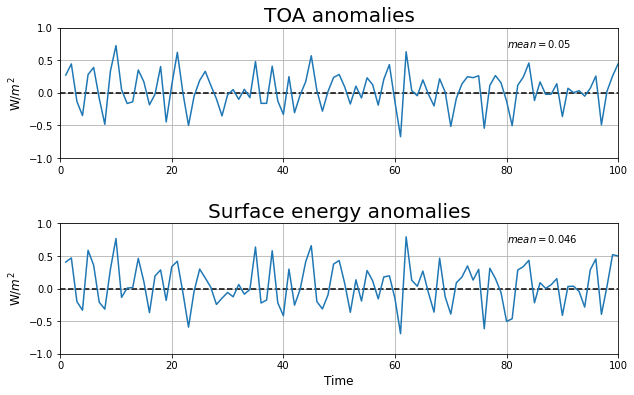

In [33]:
fig, [ax0,ax1] = plt.subplots(2,1,figsize=(10,6))
fig.subplots_adjust(hspace=0.5)
#ax0.plot(res_ocean.time[0:100],res_ocean[0:100].weighted(area).sum('ncol'),color='black',label='CNTL')
#ax0.plot(res_ocean2.time,res_ocean2.weighted(area).sum('ncol'),color='red',label='TC')

toa_diff = toa_ocean2.copy(data=(toa_ocean2.data - toa_ocean.mean('time').data))
res_diff = res_ocean2.copy(data=(res_ocean2.data - res_ocean.mean('time').data))


ax0.plot(np.arange(0, 176, 1),np.zeros(176), color="black", linestyle='--', lw=1.5)
ax0.plot(np.arange(1, 174,1),toa_diff.weighted(area).mean('ncol'))
ax1.plot(np.arange(0, 176, 1),np.zeros(176), color="black", linestyle='--', lw=1.5)
ax1.plot(np.arange(1, 174, 1), res_diff.weighted(area).mean('ncol'))

ax0.set_title("TOA anomalies", fontsize=20)
ax0.set_ylim(-1.,1.)
ax0.set_xlim(0,100)
ax0.set_ylabel('W/$m^2$', fontsize=12)
ax0.grid(True)
ax0.text(80, .7, '$mean=0.05$ ')

ax1.set_title("Surface energy anomalies", fontsize=20)
ax1.set_ylabel("W/$m^2$", fontsize=12)
ax1.set_ylim(-1., 1.)
ax1.set_xlim(0,100)
ax1.text(80, .7, '$mean=0.046$ ')

ax1.grid(True)
ax1.set_xlabel("Time", fontsize=12)
plt.savefig("atm_energy_series.pdf")

In [34]:
toa_diff.weighted(area).mean(('ncol','time'))

<xarray.DataArray ()>
array(0.05013738)

In [35]:
res_diff.weighted(area).mean(('ncol','time'))

<xarray.DataArray 'FSNS' ()>
array(0.04481861)

## 3. Compare accumulated surface energy residual and ocean heat content

In [36]:
res_series = res_ocean2.weighted(area).sum('ncol') - res_ocean.weighted(area).sum('ncol').mean()
res_series = res_series * 365* 24 * 3600   # w to J
res_total = accumulate_sum(res_series,173)

In [37]:
toa_series = toa_ocean2.weighted(area).sum('ncol') - toa_ocean.weighted(area).sum('ncol').mean()
toa_series = toa_series * 365* 24 * 3600   # w to J
toa_total = accumulate_sum(toa_series, 173)

In [38]:
res_series0 = res_ocean2[0:100].weighted(area).sum('ncol') - res_ocean.weighted(area).sum('ncol')
res_series0 = res_series0 * 365* 24 * 3600   # w to J
res_total0 = accumulate_sum(res_series0,100)

In [39]:
res_total.rolling(time=10, center=True).mean()

<xarray.DataArray (time: 173)>
array([           nan,            nan,            nan,            nan,
                  nan, 1.48749436e+22, 1.69403892e+22, 1.82627067e+22,
       1.99307746e+22, 2.28764299e+22, 2.50471682e+22, 2.60487766e+22,
       2.76985949e+22, 3.03155863e+22, 3.21662333e+22, 3.33231228e+22,
       3.53709793e+22, 3.73015932e+22, 3.82574220e+22, 3.84040656e+22,
       3.88626389e+22, 4.01748391e+22, 4.12069108e+22, 4.13875478e+22,
       4.16225690e+22, 4.12208219e+22, 3.99424496e+22, 3.88692583e+22,
       3.86081729e+22, 3.83903128e+22, 3.87168777e+22, 3.84268439e+22,
       3.78236573e+22, 3.85449189e+22, 3.91523296e+22, 3.91877260e+22,
       3.99045146e+22, 4.01120588e+22, 4.04356000e+22, 4.14397557e+22,
       4.24770887e+22, 4.35516818e+22, 4.44062236e+22, 4.41734560e+22,
       4.48961446e+22, 4.69801098e+22, 4.87055607e+22, 5.02548809e+22,
       5.20426393e+22, 5.28643365e+22, 5.30729602e+22, 5.37924220e+22,
       5.47602068e+22, 5.61692660e+22, 5.72879559e+22, 5.74692901e+22,
       5.64172146e+22, 5.72258131e+22, 5.80249050e+22, 5.91889242e+22,
       6.03396528e+22, 6.11951077e+22, 6.17244143e+22, 6.27172756e+22,
       6.31904491e+22, 6.32800051e+22, 6.46256222e+22, 6.49797971e+22,
       6.56849242e+22, 6.65422736e+22, 6.74421372e+22, 6.74565003e+22,
       6.85521589e+22, 6.91440608e+22, 6.98461971e+22, 7.03674726e+22,
       7.00007309e+22, 6.98065936e+22, 6.95963798e+22, 6.98741116e+22,
...
       7.63974829e+22, 7.87371462e+22, 8.04810810e+22, 8.29540475e+22,
       8.51238317e+22, 8.67597414e+22, 8.89826893e+22, 9.16531402e+22,
       9.30836850e+22, 9.25606032e+22, 9.23663879e+22, 9.24789108e+22,
       9.33988014e+22, 9.33925921e+22, 9.30868650e+22, 9.26251097e+22,
       9.19531081e+22, 9.10566021e+22, 9.12871729e+22, 9.23297512e+22,
       9.25613286e+22, 9.25583774e+22, 9.18928310e+22, 9.11094259e+22,
       9.12040963e+22, 9.14720905e+22, 9.17090796e+22, 9.23293600e+22,
       9.23698171e+22, 9.23085904e+22, 9.14410288e+22, 9.13331907e+22,
       9.22483384e+22, 9.41278925e+22, 9.42662869e+22, 9.36378836e+22,
       9.35817785e+22, 9.31435303e+22, 9.30939881e+22, 9.36812504e+22,
       9.52414698e+22, 9.61054749e+22, 9.56479332e+22, 9.50651931e+22,
       9.62749306e+22, 9.73359057e+22, 9.78927495e+22, 9.77781299e+22,
       9.71206830e+22, 9.72127138e+22, 9.72113699e+22, 9.68796584e+22,
       9.76910551e+22, 9.84357268e+22, 9.77647917e+22, 9.71626694e+22,
       9.77668444e+22, 9.84551647e+22, 9.86725121e+22, 9.81856738e+22,
       9.80438547e+22, 9.83967049e+22, 9.88612977e+22, 9.88689940e+22,
       1.00274140e+23, 1.03337156e+23, 1.05315339e+23, 1.07293599e+23,
       1.10231447e+23, 1.13441073e+23, 1.16364055e+23, 1.18909552e+23,
       1.20580585e+23,            nan,            nan,            nan,
                  nan])
Dimensions without coordinates: time

### - surface residual energy contribution 

In [40]:
sfc_series = sfc_ocean2.weighted(area).sum('ncol') - sfc_ocean.weighted(area).sum('ncol').mean()
sfc_series = sfc_series * 365* 24 * 3600   # w to J
sfc_total = accumulate_sum(sfc_series,173)

lhf_series = lhf_ocean2.weighted(area).sum('ncol') - lhf_ocean.weighted(area).sum('ncol').mean()
lhf_series = lhf_series * 365* 24 * 3600   # w to J
lhf_total = accumulate_sum(lhf_series,173)

shf_series = shf_ocean2.weighted(area).sum('ncol') - shf_ocean.weighted(area).sum('ncol').mean()
shf_series = shf_series * 365* 24 * 3600   # w to J
shf_total = accumulate_sum(shf_series,173)


In [41]:
print(lhf_series[30:173].mean('time'))
print(sfc_series[30:173].mean('time'))

<xarray.DataArray ()>
array(1.62579386e+21)
<xarray.DataArray 'FSNS' ()>
array(1.88652464e+21)


Text(0.5, 1.0, 'energy compare')

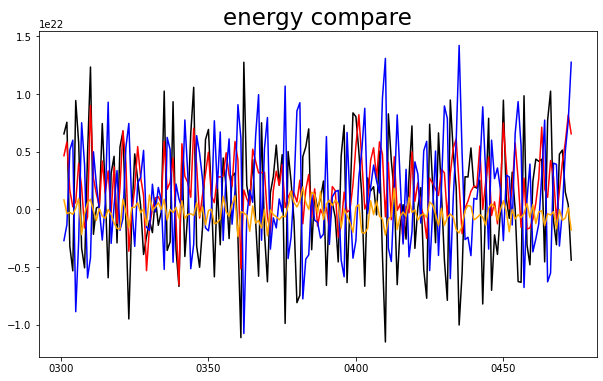

In [42]:
fig, ax0 = plt.subplots(figsize=(10,6))
ax0.plot(res_series.time[0:173],res_series[0:173],color='black',label='atm res')
ax0.plot(sfc_series.time[0:173],sfc_series[0:173],color='red',label='sfc radi')
ax0.plot(lhf_series.time[0:173],lhf_series[0:173],color='blue',label='lhf')
ax0.plot(shf_series.time[0:173],shf_series[0:173],color='orange',label='shf')

ax0.set_title("energy compare",fontsize=23)

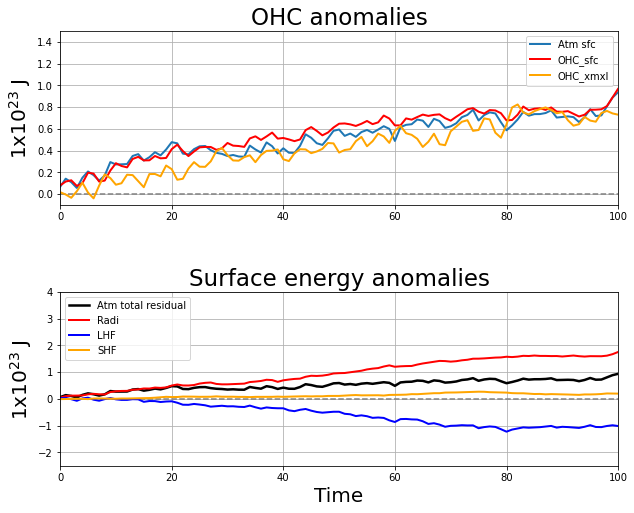

In [43]:

fig, [ax0,ax1] = plt.subplots(2,1,figsize=(10,8))
fig.subplots_adjust(hspace=0.5)

ax0.plot(np.arange(0, 173, 1),np.zeros(173), color="grey", linestyle='--', lw=1.5)
ax0.plot(res_total.time[0:173],res_total[0:173]*1e-23,lw=2,label='Atm sfc')
ax0.plot(np.arange(0,173,step=1),ohc_diff2[0:173]*1e-23,color='red',lw=2,label='OHC_sfc')
ax0.plot(np.arange(0,173,step=1), ohc_diffx[0:173]*1e-23,color="orange",lw=2, label='OHC_xmxl')
ax0.set_title("OHC anomalies",fontsize=23)

handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles, labels)
ax0.grid(True)
ax0.set_ylim(-0.1,1.5)
ax0.set_ylabel('1x$10^{23}$ J',fontsize=20)
ax0.set_xlim(0, 100)
#net = ohc_diff2[0:173] - res_total
#ax1.plot(net[0:173].time, net[0:173])
#ax1.set_title('ohc-res',fontsize=23)
#ax1.set_ylim(0, 2e23)

ax1.plot(np.arange(0, 173, 1),np.zeros(173), color="grey", linestyle='--', lw=1.5)
ax1.plot(res_total.time[0:173],res_total[0:173]* 1e-23,color='black', lw=2.5,label='Atm total residual')
ax1.plot(sfc_total.time[0:173],sfc_total[0:173]* 1e-23,color='red',lw=2,label='Radi')
ax1.plot(lhf_total.time[0:173],lhf_total[0:173]* -1e-23,color='blue',lw=2,label='LHF')
ax1.plot(shf_total.time[0:173],shf_total[0:173]* -1e-23,color='orange',lw=2,label='SHF')
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels)

ax1.set_title("Surface energy anomalies",fontsize=23)
ax1.grid(True)
ax1.set_xlim(0, 100)
ax1.set_ylim(-2.5, 4.)
ax1.set_ylabel('1x$10^{23}$ J',fontsize=20)
ax1.set_xlabel('Time',fontsize=20)
plt.savefig("ohc_atmres_series.pdf")


## 4. Spatial maps of surface heat fluxes -- use regridded data

In [ ]:
dsregrid = xr.open_dataset('./data/regrid_b.e13.B1850C5CN.ne30_g16.sehires24_CNTL_010.cam.h0.ann.radi.0331-0400.nc')
rlhflx = dsregrid.LHFLX
rfsns = dsregrid.FSNS
rflns = dsregrid.FLNS
rshflx = dsregrid.SHFLX

In [ ]:
ddregrid = xr.open_dataset('./data/regrid_b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily.cam.h0.ann.radi.0301-0473.nc')
ddregrid
rlhflx2 = ddregrid.LHFLX
rfsns2 = ddregrid.FSNS
rflns2 = ddregrid.FLNS
rshflx2 = ddregrid.SHFLX

In [44]:
regrid_shf_diff = rshflx[0,:,:].copy(data=rshflx2[70:100].mean('time').data - rshflx.mean('time').data)
regrid_lhf_diff = rlhflx[0,:,:].copy(data=rlhflx2[70:100].mean('time').data - rlhflx.mean('time').data)
regrid_fsns_diff = rfsns[0,:,:].copy(data=rfsns2[70:100].mean('time').data - rfsns.mean('time').data)
regrid_flns_diff = rflns[0,:,:].copy(data=rflns2[70:100].mean('time').data - rflns.mean('time').data)
regrid_sfc_diff = regrid_flns_diff.copy(data=regrid_fsns_diff.data - regrid_flns_diff.data)

In [45]:
dg = xr.open_dataset('regrid_cam_ocnfrac.nc')
ocnfrac = dg.OCNFRAC
# convert latent and sensible heat to downward positive
sfc_diff_ocn = regrid_sfc_diff * ocnfrac[0,:,:]
lhf_diff_ocn = -1*regrid_lhf_diff * ocnfrac[0,:,:]
shf_diff_ocn = -1*regrid_shf_diff * ocnfrac[0,:,:]

total_diff_ocn = shf_diff_ocn.copy(data=(sfc_diff_ocn.data + lhf_diff_ocn.data + shf_diff_ocn.data))


In [46]:
sfc_ocn_control = (rfsns.mean('time').copy(data=rfsns.mean('time').data - rflns.mean('time').data))* ocnfrac[0,:,:]
lhf_ocn_control = -1 * rlhflx.mean('time') * ocnfrac[0,:,:]
shf_ocn_control = -1 * rshflx.mean('time') * ocnfrac[0,:,:]

total_ocn_control = shf_ocn_control.copy(data=(sfc_ocn_control.data + lhf_ocn_control.data + shf_ocn_control.data))

### - significance test of the differences

In [94]:
from scipy.stats import ttest_ind

In [48]:
# time sereis of control
sfc_ocn_s = rfsns2[70:100].copy(data=rfsns2[70:100].data - rflns2[70:100].data) * ocnfrac[0,:,:]
lhf_ocn_s = -1. * rlhflx2[70:100] * ocnfrac[0,:,:]
shf_ocn_s = -1. * rshflx2[70:100] * ocnfrac[0,:,:]
total_ocn_s  = sfc_ocn_s.copy(data=(sfc_ocn_s.data + lhf_ocn_s.data + shf_ocn_s.data))



In [49]:
# time sreis of TC run
sfc_ocn_control_s = rfsns[40:70].copy(data=rfsns[40:70].data - rflns[40:70].data) * ocnfrac[0,:,:]
lhf_ocn_control_s = -1. * rlhflx[40:70] * ocnfrac[0,:,:]
shf_ocn_control_s = -1. * rshflx[40:70] * ocnfrac[0,:,:]
total_ocn_control_s  = sfc_ocn_control_s.copy(data=(sfc_ocn_control_s.data + lhf_ocn_control_s.data + shf_ocn_control_s.data))



In [50]:
t, p = ttest_ind(sfc_ocn_control_s[:,:,:], sfc_ocn_s[:,:,:], equal_var=False)
prob_sfc = xr.DataArray(p, coords=sfc_ocn_control.coords)
del(p)

In [51]:
t, p = ttest_ind(lhf_ocn_control_s[:,:,:], lhf_ocn_s[:,:,:], equal_var=False)
prob_lhf = xr.DataArray(p, coords=sfc_ocn_control.coords)
del(p)

In [52]:
t, p = ttest_ind(shf_ocn_control_s[:,:,:], shf_ocn_s[:,:,:], equal_var=False)
prob_shf = xr.DataArray(p, coords=sfc_ocn_control.coords)
del(p)

In [53]:
t, p = ttest_ind(total_ocn_control_s[:,:,:], total_ocn_s[:,:,:], equal_var=False)
prob_total = xr.DataArray(p, coords=sfc_ocn_control.coords)
del(p)

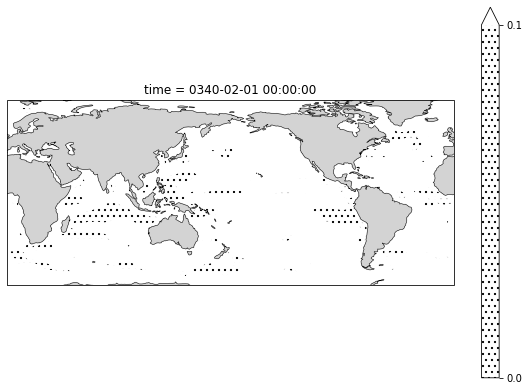

In [54]:
fig = plt.figure(figsize=(22, 15))
fig.tight_layout(pad=-2)

#grid = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[0.85, 0.15],wspace=0.08)
#map_contour_plots(sfc_diff_ocn,2, 2, ax, 1, np.arange(-4,4.5,0.5), gvcmaps.BlueWhiteOrangeRed, "Radiative flux anomalies", "$W/m^2$")

ax = plt.subplot(2, 2, 1, projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)

cf = prob_total.plot.contourf(ax=ax,
                 transform=ccrs.PlateCarree(),
                 levels=[0, 0.1],
                 colors='None',
                 hatches=['..',''],
 #                 add_colorbar=False,
                    zorder=1
                           )

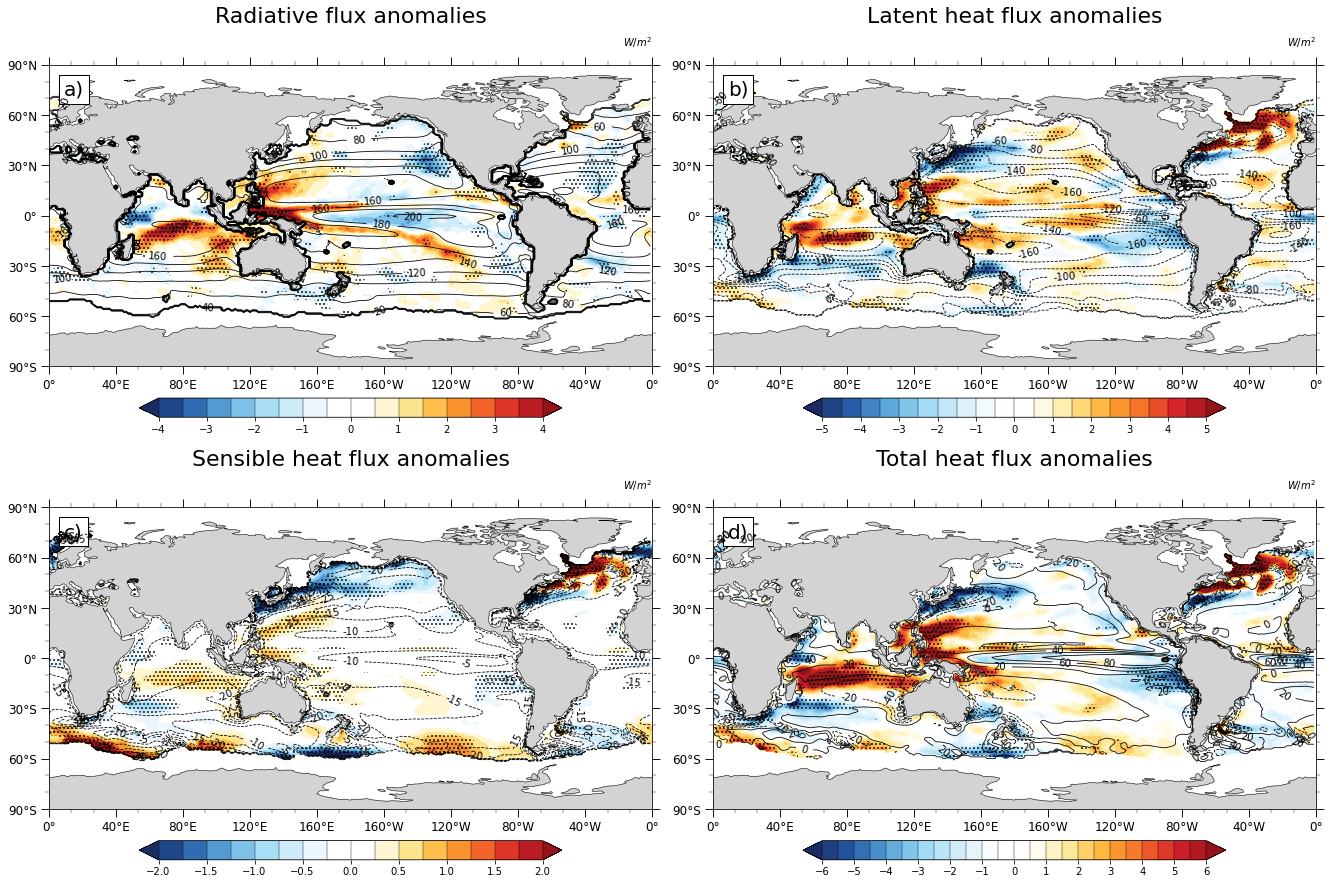

In [81]:
sfc_diff_ocn = gvutil.xr_add_cyclic_longitudes(sfc_diff_ocn, "lon")
lhf_diff_ocn = gvutil.xr_add_cyclic_longitudes(lhf_diff_ocn, "lon")
shf_diff_ocn = gvutil.xr_add_cyclic_longitudes(shf_diff_ocn, "lon")


fig = plt.figure(figsize=(22, 15))
fig.tight_layout(pad=-2)

#grid = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[0.85, 0.15],wspace=0.08)
#map_contour_plots(sfc_diff_ocn,2, 2, ax, 1, np.arange(-4,4.5,0.5), gvcmaps.BlueWhiteOrangeRed, "Radiative flux anomalies", "$W/m^2$")

ax = plt.subplot(2, 2, 1, projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)
contour = sfc_diff_ocn.plot.contourf(ax=ax,
                           transform=ccrs.PlateCarree(),
                           levels=np.arange(-4, 4.5, 0.5),
                           extend='both',
                            cmap = gvcmaps.BlueWhiteOrangeRed,
                           add_colorbar=False,
                           add_labels=False,
                            zorder=0)

cf0 = prob_sfc.plot.contourf(ax=ax,
                 transform=ccrs.PlateCarree(),
                 levels=[0,0.1],
                 colors='None',
                 hatches=['...',''],
                  add_colorbar=False,
                add_labels=False,
                    zorder=1
                           )

contour_control = sfc_ocn_control.plot.contour(ax=ax,
                                            transform=ccrs.PlateCarree(),
                                              levels=np.arange(0,220,20),
                                                linewidths=0.8,
                                              add_labels=False,
                                              colors = "black",
                                              extend='both')

ax.clabel(contour_control, np.arange(20, 220, 20), fmt='%d', inline=True, colors='black')


plt.colorbar(contour,
             ax=ax,
             ticks=np.linspace(-5, 5, 11),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)



gvutil.set_titles_and_labels(ax,maintitle="Radiative flux anomalies",
                             maintitlefontsize=20,righttitle="$W/m^2$",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax, xlim=(-180, 180),
                                 ylim=(-90, 90),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))


gvutil.add_major_minor_ticks(ax, labelsize=12)


gvutil.add_lat_lon_ticklabels(ax)

#----
ax1 = plt.subplot(2,2,2, projection=ccrs.PlateCarree(central_longitude=180))
ax1.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)

contour1 = lhf_diff_ocn.plot.contourf(ax=ax1,
                           transform=ccrs.PlateCarree(),
                           levels=np.arange(-5, 5.5, 0.5),
                           cmap = gvcmaps.BlueWhiteOrangeRed,
                           extend='both',
                           add_colorbar=False,
                           add_labels=False,
                           zorder=0)
cf1 = prob_lhf.plot.contourf(ax=ax1,
                 transform=ccrs.PlateCarree(),
                 levels=[0,0.1],
                 colors='None',
                 hatches=['...',''],
                  add_colorbar=False,
                add_labels=False,
                    zorder=1
                           )


contour1_control = lhf_ocn_control.plot.contour(ax=ax1,
                                            transform=ccrs.PlateCarree(),
                                              levels=np.arange(-220,0,20),
                                              linewidths=0.8,
                                              add_labels=False,
                                              colors = "black",
                                              extend='both')

ax1.clabel(contour1_control, np.arange(-220, -20, 20), fmt='%d', inline=True, colors='black')



plt.colorbar(contour1,
             ax=ax1,
             ticks=np.linspace(-6, 6, 13),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)

gvutil.set_titles_and_labels(ax1,maintitle="Latent heat flux anomalies",
                             maintitlefontsize=20, righttitle="$W/m^2$",righttitlefontsize=10)
# Use geocat.viz.util convenience function to set axes limits & tick values
gvutil.set_axes_limits_and_ticks(ax1, xlim=(-180, 180),
                                 ylim=(-90, 90),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))

gvutil.add_major_minor_ticks(ax1, labelsize=12)
gvutil.add_lat_lon_ticklabels(ax1)



#-------
ax2 = plt.subplot(2,2,3, projection=ccrs.PlateCarree(central_longitude=180))
ax2.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax2.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)

contour2 = shf_diff_ocn.plot.contourf(ax=ax2,
                           transform=ccrs.PlateCarree(),
                           levels=np.arange(-2, 2.25, 0.25),
                           extend='both',
                           cmap = gvcmaps.BlueWhiteOrangeRed,
                           add_colorbar=False,
                           add_labels=False,
                           zorder=0)

cf2 = prob_shf.plot.contourf(ax=ax2,
                 transform=ccrs.PlateCarree(),
                 levels=[0,0.1],
                 colors='None',
                 hatches=['...',''],
                add_labels=False,
                  add_colorbar=False,
                    zorder=1
                           )
contour2_control = shf_ocn_control.plot.contour(ax=ax2,
                                            transform=ccrs.PlateCarree(),
                                              levels=np.arange(-100,20,5),
                                              linewidths=.8,
                                              add_labels=False,
                                              colors = "black",
                                              extend='both')

ax2.clabel(contour2_control, np.arange(-100, 20, 5), fmt='%d', inline=True, colors='black')


plt.colorbar(contour2,
             ax=ax2,
             ticks=np.linspace(-2.5, 2.5, 11),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)
gvutil.set_titles_and_labels(ax2,maintitle="Sensible heat flux anomalies",
                             maintitlefontsize=20, righttitle="$W/m^2$",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax2, xlim=(-180, 180),
                                 ylim=(-90, 90),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))

gvutil.add_major_minor_ticks(ax2, labelsize=12)
gvutil.add_lat_lon_ticklabels(ax2)



#-------
ax3 = plt.subplot(2, 2, 4, projection=ccrs.PlateCarree(central_longitude=180))
ax3.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax3.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)

contour3 = total_diff_ocn.plot.contourf(ax=ax3,
                           transform=ccrs.PlateCarree(),
                           levels=np.arange(-6, 6.5, 0.5),
                          cmap = gvcmaps.BlueWhiteOrangeRed,
                           extend='both',
                           add_colorbar=False,
                           add_labels=False,
                           zorder=0)

cf3 = prob_total.plot.contourf(ax=ax3,
                 transform=ccrs.PlateCarree(),
                 levels=[0,0.1],
                 colors='None',
                 hatches=['...',''],
                  add_colorbar=False,
                    add_labels=False,
                    zorder=1
                           )
contour3_control = total_ocn_control.plot.contour(ax=ax3,
                                            transform=ccrs.PlateCarree(),
                                              levels=np.arange(-100,100,20),
                                              linewidths=.8,
                                              add_labels=False,
                                              colors = "black",
                                              extend='both')

ax3.clabel(contour3_control, np.arange(-100, 100, 20), fmt='%d', inline=True, colors='black')



plt.colorbar(contour3,
             ax=ax3,
             ticks=np.linspace(-7, 7, 15),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)

gvutil.set_titles_and_labels(ax3,maintitle="Total heat flux anomalies",
                             maintitlefontsize=20, righttitle="$W/m^2$",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax3, xlim=(-180, 180),
                                 ylim=(-90, 90),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))


gvutil.add_major_minor_ticks(ax3, labelsize=12)
gvutil.add_lat_lon_ticklabels(ax3)
plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.1,  
                    hspace=0.05) 


ax.text(0.025, 0.9,
            'a)', fontsize=20,
            transform=ax.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

ax1.text(0.025, 0.9,
            'b)', fontsize=20,
            transform=ax1.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

ax2.text(0.025, 0.9,
            'c)', fontsize=20,
            transform=ax2.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

ax3.text(0.025, 0.9,
            'd)', fontsize=20,
            transform=ax3.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))
#plt.show()
plt.savefig("sfc_flux_map.pdf")



anomalies are averaged over the last 30 years, positive is into the ocean.

## 5. Precipitation anomalies

In [240]:
dsp0 = xr.open_dataset('./data/regrid_b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010.cam.h.ann.prect.0301-0400.nc')
precc0 = dsp0.PRECC
precl0 = dsp0.PRECL
#prect0 = dsp0.PRECT

In [241]:
dsp = xr.open_dataset('./data/regrid_b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily.cam.h0.ann.prec.0371-0400.nc')
precc = dsp.PRECC
precl = dsp.PRECL



In [242]:
prect = precc.copy(data=precc.data + precl.data) * 1000 * 24 * 3600. # m/s to mm/h
prect0 = precc0.copy(data=precc0.data+ precl0.data)*1000 * 24 * 3600. # m/s to mm/h

prect_anom = prect.mean('time').copy(data=prect.mean('time').data - prect0.mean('time').data)
prect0_mean = prect0.mean('time') 

### get significance level

In [244]:
t, p = ttest_ind(prect0[:,:,:], prect[:,:,:], equal_var=False)
prob_prec = xr.DataArray(p, coords=prect0_mean.coords)
del(p)

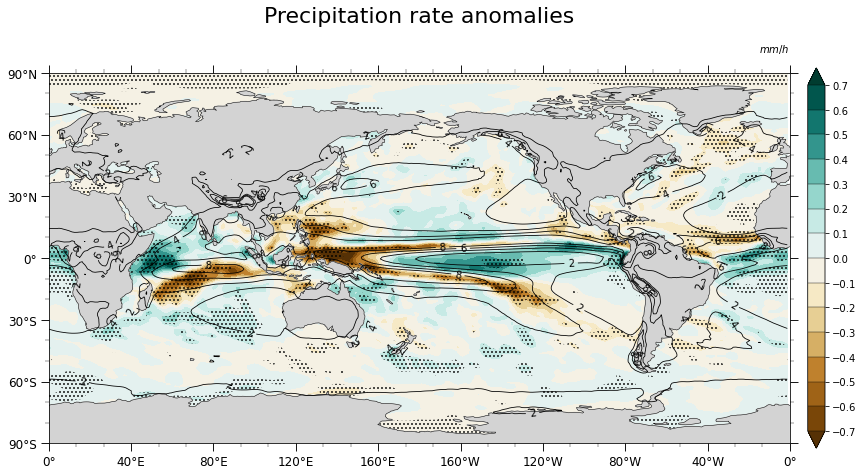

In [245]:
fig = plt.figure(figsize=(16, 10))

#grid = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[0.85, 0.15],wspace=0.08)
ax = plt.subplot(projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)
contour = prect_anom.plot.contourf(ax=ax,
                           transform=ccrs.PlateCarree(),
                           levels=np.arange(-0.7, 0.8, 0.1),
                           extend='both',
                            cmap = gvcmaps.MPL_BrBG,
                           add_colorbar=False,
                           add_labels=False,
                            zorder=0)

cf = prob_prec.plot.contourf(ax=ax,
                 transform=ccrs.PlateCarree(),
                 levels=[0,0.1],
                 colors='None',
                 hatches=['...',''],
                  add_colorbar=False,
                add_labels=False,
                    zorder=0
                           )

contour_control = prect0_mean.plot.contour(ax=ax,
                                            transform=ccrs.PlateCarree(),
                                              levels=np.arange(0,10,2),
                                              linewidths=.8,
                                              add_labels=False,
                                              colors = "black",
                                              extend='both')

ax.clabel(contour_control, np.arange(0, 10, 2), fmt='%d', inline=True, colors='black')



plt.colorbar(contour,
             ax=ax,
             ticks=np.linspace(-1, 1, 21),
             orientation='vertical',
             pad=0.02,
             drawedges=True,
             shrink=0.7)



gvutil.set_titles_and_labels(ax,maintitle="Precipitation rate anomalies",
                             maintitlefontsize=20,righttitle="$mm/h$",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax, xlim=(-180, 180),
                                 ylim=(-90, 90),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))


gvutil.add_major_minor_ticks(ax, labelsize=12)

gvutil.add_lat_lon_ticklabels(ax)
plt.savefig("precip_anomalies.pdf")

## 6. SST,SSS and OHC spatial maps
the time series doesn't show much signal

In [61]:
del dsregrid
del ddregrid

In [62]:
dsregrid = xr.open_dataset('./data/regrid_b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010.cam.h0.TS.033101-040012.nc')
ts0 = dsregrid.TS
ts0

<xarray.DataArray 'TS' (time: 840, lat: 192, lon: 288)>
[46448640 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 0331-02-01 00:00:00 ... 0401-01-01 00:00:00
Attributes:
    units:         K
    long_name:     Surface temperature (radiative)
    cell_methods:  time: mean
    remap:         remapped via ESMF_regrid_with_weights: Bilinear

In [63]:
ddregrid = xr.open_dataset('./data/regrid_b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily.cam.h0.TS.033101-040012.nc')
ts = ddregrid.TS


In [64]:
ts0_clm = ts0.mean('time')
ts_clm = ts[480:840,:,:].mean('time')
ts_clm_anom = ts_clm.copy(data=ts_clm.data-ts0_clm.data)

In [65]:
# now get time series
ts_series = ts[:,0,0].copy(data=ts.mean(('lat','lon')) - ts0_clm.mean(('lat','lon')))


### - use regridded data to get OHC anomaly pattern

In [53]:
dsocn0 = xr.open_dataset('/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010.pop.h.ann.TEMP.0301-0400.1x1.nc')
temp01x1 = dsocn0.TEMP

In [54]:
dsocn = xr.open_dataset('/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily/ocn/hist/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily.pop.h.ann.TEMP.0301-0473.1x1.nc')
temp1x1 = dsocn.TEMP
temp1x1

<xarray.DataArray 'TEMP' (time: 173, z_t: 60, lat: 180, lon: 360)>
[672624000 values with dtype=float32]
Coordinates:
  * time     (time) object 0301-02-01 00:00:00 ... 0473-02-01 00:00:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Attributes:
    long_name:     Potential Temperature
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

In [79]:
temp_diff_1x1 = temp1x1[0,0,:,:].copy(data=temp1x1[70:100,0,:,:].mean('time').data - temp01x1[:,0,:,:].mean('time').data)
temp_diff_1x1

<xarray.DataArray 'TEMP' (lat: 180, lon: 360)>
array([[            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       ...,
       [ 1.06930733e-04,  9.96589661e-05,  9.29832458e-05, ...,
         1.29103661e-04,  1.21712685e-04,  1.14798546e-04],
       [-1.49965286e-04, -1.53660774e-04, -1.58429146e-04, ...,
        -1.38640404e-04, -1.42812729e-04, -1.46269798e-04],
       [-3.45230103e-04, -3.47852707e-04, -3.49164009e-04, ...,
        -3.40104103e-04, -3.42369080e-04, -3.44038010e-04]], dtype=float32)
Coordinates:
    time     object 0301-02-01 00:00:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
    z_t      float32 500.0
Attributes:
    long_name:     Potential Temperature
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

In [80]:
import cf_units as cf

temp01x1_in_K = change_units(dsocn0,"TEMP","TEMP","degK")
heat01x1= calculate_ohc(temp01x1_in_K, dz_in_m, zt_in_m, 'z_t',1000)
heat01x1

(100, 40, 180, 360)


<xarray.DataArray (time: 100, lat: 180, lon: 360)>
array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.14145199e+12, 1.14145437e+12, 1.14145675e+12, ...,
         1.14144487e+12, 1.14144712e+12, 1.14144962e+12],
        [1.14138047e+12, 1.14138197e+12, 1.14138347e+12, ...,
         1.14137622e+12, 1.14137759e+12, 1.14137922e+12],
        [1.14131920e+12, 1.14131970e+12, 1.14132032e+12, ...,
         1.14131745e+12, 1.14131795e+12, 1.14131857e+12]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
...
        [1.14150439e+12, 1.14150614e+12, 1.14150751e+12, ...,
         1.14149964e+12, 1.14150139e+12, 1.14150289e+12],
        [1.14142486e+12, 1.14142586e+12, 1.14142661e+12, ...,
         1.14142223e+12, 1.14142311e+12, 1.14142411e+12],
        [1.14136396e+12, 1.14136409e+12, 1.14136446e+12, ...,
         1.14136284e+12, 1.14136309e+12, 1.14136334e+12]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.14149976e+12, 1.14150251e+12, 1.14150514e+12, ...,
         1.14149163e+12, 1.14149426e+12, 1.14149701e+12],
        [1.14140735e+12, 1.14140860e+12, 1.14140998e+12, ...,
         1.14140310e+12, 1.14140460e+12, 1.14140585e+12],
        [1.14133833e+12, 1.14133895e+12, 1.14133945e+12, ...,
         1.14133708e+12, 1.14133745e+12, 1.14133783e+12]]])
Coordinates:
  * time     (time) object 0301-02-01 00:00:00 ... 0400-02-01 00:00:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5

In [81]:
temp1x1_in_K = change_units(dsocn,"TEMP","TEMP","degK")
heat1x1= calculate_ohc(temp1x1_in_K, dz_in_m, zt_in_m, 'z_t',1000)
heat1x1

(173, 40, 180, 360)


<xarray.DataArray (time: 173, lat: 180, lon: 360)>
array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.14146550e+12, 1.14146750e+12, 1.14146937e+12, ...,
         1.14145975e+12, 1.14146162e+12, 1.14146350e+12],
        [1.14138985e+12, 1.14139097e+12, 1.14139197e+12, ...,
         1.14138660e+12, 1.14138772e+12, 1.14138897e+12],
        [1.14132320e+12, 1.14132357e+12, 1.14132395e+12, ...,
         1.14132182e+12, 1.14132220e+12, 1.14132282e+12]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
...
        [1.14185764e+12, 1.14186126e+12, 1.14186501e+12, ...,
         1.14184638e+12, 1.14184988e+12, 1.14185376e+12],
        [1.14172259e+12, 1.14172484e+12, 1.14172684e+12, ...,
         1.14171609e+12, 1.14171834e+12, 1.14172046e+12],
        [1.14159192e+12, 1.14159267e+12, 1.14159329e+12, ...,
         1.14158929e+12, 1.14159017e+12, 1.14159104e+12]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.14185213e+12, 1.14185613e+12, 1.14186026e+12, ...,
         1.14183975e+12, 1.14184388e+12, 1.14184801e+12],
        [1.14173309e+12, 1.14173559e+12, 1.14173809e+12, ...,
         1.14172534e+12, 1.14172809e+12, 1.14173072e+12],
        [1.14161355e+12, 1.14161455e+12, 1.14161555e+12, ...,
         1.14161055e+12, 1.14161155e+12, 1.14161255e+12]]])
Coordinates:
  * time     (time) object 0301-02-01 00:00:00 ... 0473-02-01 00:00:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5

In [82]:
heat_diff_1x1 = heat1x1[0,:,:].copy(data=heat1x1[70:100].mean('time').data - heat01x1.mean('time').data)
heat_diff_1x1

<xarray.DataArray (lat: 180, lon: 360)>
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.30965405e+08, 1.30465647e+08, 1.30007987e+08, ...,
        1.32157489e+08, 1.31802782e+08, 1.31410561e+08],
       [8.85305582e+07, 8.82500434e+07, 8.79749471e+07, ...,
        8.91853706e+07, 8.90086421e+07, 8.87393812e+07],
       [4.93276753e+07, 4.92343093e+07, 4.91276053e+07, ...,
        4.95860991e+07, 4.95060711e+07, 4.94285439e+07]])
Coordinates:
    time     object 0301-02-01 00:00:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5

In [83]:
heat01x1

<xarray.DataArray (time: 100, lat: 180, lon: 360)>
array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.14145199e+12, 1.14145437e+12, 1.14145675e+12, ...,
         1.14144487e+12, 1.14144712e+12, 1.14144962e+12],
        [1.14138047e+12, 1.14138197e+12, 1.14138347e+12, ...,
         1.14137622e+12, 1.14137759e+12, 1.14137922e+12],
        [1.14131920e+12, 1.14131970e+12, 1.14132032e+12, ...,
         1.14131745e+12, 1.14131795e+12, 1.14131857e+12]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
...
        [1.14150439e+12, 1.14150614e+12, 1.14150751e+12, ...,
         1.14149964e+12, 1.14150139e+12, 1.14150289e+12],
        [1.14142486e+12, 1.14142586e+12, 1.14142661e+12, ...,
         1.14142223e+12, 1.14142311e+12, 1.14142411e+12],
        [1.14136396e+12, 1.14136409e+12, 1.14136446e+12, ...,
         1.14136284e+12, 1.14136309e+12, 1.14136334e+12]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.14149976e+12, 1.14150251e+12, 1.14150514e+12, ...,
         1.14149163e+12, 1.14149426e+12, 1.14149701e+12],
        [1.14140735e+12, 1.14140860e+12, 1.14140998e+12, ...,
         1.14140310e+12, 1.14140460e+12, 1.14140585e+12],
        [1.14133833e+12, 1.14133895e+12, 1.14133945e+12, ...,
         1.14133708e+12, 1.14133745e+12, 1.14133783e+12]]])
Coordinates:
  * time     (time) object 0301-02-01 00:00:00 ... 0400-02-01 00:00:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5

### - get oHC under XMXL

In [84]:
dsxh = xr.open_dataset('/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010.pop.h.monclm.XMXL.1x1.nc')
xmxl1x1 = change_units(dsxh,'XMXL','XMXL','m')


In [85]:
zt_xmxl_1x1 = xmxl1x1.max(dim='time')


In [86]:
deep_temp1x1 = temp1x1_in_K.where(zt_in_m > zt_xmxl_1x1)
deep_temp01x1 = temp01x1_in_K.where(zt_in_m>zt_xmxl_1x1)

In [87]:
heat01x1_x= calculate_ohc(deep_temp01x1, dz_in_m, zt_in_m, 'z_t',1000)
heat01x1_x

(100, 40, 180, 360)


<xarray.DataArray (time: 100, lat: 180, lon: 360)>
array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.04371067e+12, 1.04371292e+12, 1.04371511e+12, ...,
         1.04370386e+12, 1.04370617e+12, 1.04370842e+12],
        [1.04363796e+12, 1.04363908e+12, 1.04364033e+12, ...,
         1.04363377e+12, 1.04363514e+12, 1.04363665e+12],
        [1.05444243e+12, 1.05444280e+12, 1.05444343e+12, ...,
         1.05444080e+12, 1.05444130e+12, 1.05444180e+12]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
...
        [1.04376644e+12, 1.04376807e+12, 1.04376944e+12, ...,
         1.04376206e+12, 1.04376356e+12, 1.04376500e+12],
        [1.04368591e+12, 1.04368673e+12, 1.04368754e+12, ...,
         1.04368347e+12, 1.04368435e+12, 1.04368516e+12],
        [1.05448807e+12, 1.05448832e+12, 1.05448857e+12, ...,
         1.05448694e+12, 1.05448744e+12, 1.05448769e+12]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.04375994e+12, 1.04376244e+12, 1.04376494e+12, ...,
         1.04375206e+12, 1.04375469e+12, 1.04375719e+12],
        [1.04366641e+12, 1.04366766e+12, 1.04366884e+12, ...,
         1.04366253e+12, 1.04366384e+12, 1.04366522e+12],
        [1.05446156e+12, 1.05446206e+12, 1.05446256e+12, ...,
         1.05446031e+12, 1.05446081e+12, 1.05446118e+12]]])
Coordinates:
  * time     (time) object 0301-02-01 00:00:00 ... 0400-02-01 00:00:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5

In [88]:
heat1x1_x= calculate_ohc(deep_temp1x1[70:100], dz_in_m, zt_in_m, 'z_t',1000)


(30, 40, 180, 360)


In [89]:
heat1x1_x

<xarray.DataArray (time: 30, lat: 180, lon: 360)>
array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.04413182e+12, 1.04413569e+12, 1.04413951e+12, ...,
         1.04412013e+12, 1.04412394e+12, 1.04412794e+12],
        [1.04397970e+12, 1.04398202e+12, 1.04398445e+12, ...,
         1.04397226e+12, 1.04397489e+12, 1.04397720e+12],
        [1.05469651e+12, 1.05469726e+12, 1.05469814e+12, ...,
         1.05469351e+12, 1.05469439e+12, 1.05469539e+12]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
...
        [1.04424942e+12, 1.04425461e+12, 1.04425980e+12, ...,
         1.04423379e+12, 1.04423904e+12, 1.04424423e+12],
        [1.04406955e+12, 1.04407255e+12, 1.04407549e+12, ...,
         1.04406036e+12, 1.04406348e+12, 1.04406655e+12],
        [1.05476104e+12, 1.05476241e+12, 1.05476354e+12, ...,
         1.05475779e+12, 1.05475891e+12, 1.05476004e+12]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.04424511e+12, 1.04424948e+12, 1.04425380e+12, ...,
         1.04423167e+12, 1.04423617e+12, 1.04424061e+12],
        [1.04407705e+12, 1.04407955e+12, 1.04408199e+12, ...,
         1.04406886e+12, 1.04407161e+12, 1.04407430e+12],
        [1.05478029e+12, 1.05478129e+12, 1.05478217e+12, ...,
         1.05477717e+12, 1.05477829e+12, 1.05477929e+12]]])
Coordinates:
  * time     (time) object 0371-02-01 00:00:00 ... 0400-02-01 00:00:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5

In [90]:
heat_diff_1x1_x = heat1x1_x[0,:,:].copy(data=heat1x1_x.mean('time').data - heat01x1_x.mean('time').data)
heat_diff_1x1_x

<xarray.DataArray (lat: 180, lon: 360)>
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.31382843e+08, 1.30893505e+08, 1.30414587e+08, ...,
        1.32579095e+08, 1.32242727e+08, 1.31848006e+08],
       [8.91266001e+07, 8.88494198e+07, 8.85816177e+07, ...,
        8.98041288e+07, 8.95938469e+07, 8.93406333e+07],
       [4.95685929e+07, 4.94810623e+07, 4.93568522e+07, ...,
        4.98353529e+07, 4.97490728e+07, 4.96652934e+07]])
Coordinates:
    time     object 0371-02-01 00:00:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5

##  analyze TC -ocean correlatio using TC PDI

In [44]:
ft = xr.open_dataset('trajectory_file_330-450.nc')

In [45]:
traj_data = ft.traj_data
wind = traj_data[:,4,:]
traj  = traj_data.where(wind>10., drop=True)

In [46]:
lon = traj[:,1,:]
lat = traj[:,2,:]
#traj_wp0 = traj.where(lon<280, drop = True)
#traj_wp = traj_wp0.where(traj_wp0[:,1,:]>120, drop=True)

In [47]:
traj_wind = traj[:,4,:]
traj_wind

<xarray.DataArray 'traj_data' (nstorm: 10752, steps: 129)>
array([[45.26096, 41.86576, 45.84743, ...,      nan,      nan,      nan],
       [23.51798, 21.44969, 23.45146, ...,      nan,      nan,      nan],
       [20.23879, 20.42117, 20.6611 , ...,      nan,      nan,      nan],
       ...,
       [23.50543, 24.26297, 22.79744, ...,      nan,      nan,      nan],
       [24.67916, 24.25056, 19.28395, ...,      nan,      nan,      nan],
       [23.57087, 21.11445, 23.79714, ...,      nan,      nan,      nan]],
      dtype=float32)
Dimensions without coordinates: nstorm, steps

In [49]:
traj[10,9,:]

<xarray.DataArray 'traj_data' (steps: 129)>
array([12., 18., 12., 18., 18.,  0.,  6.,  0.,  6., 12., 18.,  0.,  6.,
       12., 18.,  0.,  6., 12., 18.,  0., nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
      dtype=float32)
Dimensions without coordinates: steps

In [50]:
traj_wind.coords["year"] = traj[:,6,:]
traj_wind.coords['month'] = traj[:,7,:]
traj_wind.coords['lat'] = traj[:,2,:]
traj_wind.coords['lon'] = traj[:,1,:]

In [55]:
# 19x72, 5x5 degree boxes from -45-45N,0-360E
box_lat = temp1x1.lat.isel(lat=slice(45,140,5))
box_lon = temp1x1.lon.isel(lon=slice(0,360,5))

In [56]:
tmp_data = np.zeros((120,19,72))
pdi_map = xr.DataArray(data=tmp_data,coords=[('time',temp1x1[0:120].time),('lat',box_lat),('lon',box_lon)])
del tmp_data

In [57]:
stacked = traj_wind.stack(z=("nstorm","steps"))

In [58]:
stacked['z'] = np.arange(0,stacked.size)  # so that we can use z as a new dimension

In [59]:
def get_PDI(var):
    x = var**3
    return x.sum()

In [60]:
box_lat_labels = box_lat + 2.5
box_lat_labels[0:18]

<xarray.DataArray 'lat' (lat: 18)>
array([-42., -37., -32., -27., -22., -17., -12.,  -7.,  -2.,   3.,   8.,
        13.,  18.,  23.,  28.,  33.,  38.,  43.])
Coordinates:
  * lat      (lat) float64 -44.5 -39.5 -34.5 -29.5 -24.5 ... 25.5 30.5 35.5 40.5

###  the buffer array is uded to avoid empty groupby
buffer_array = stacked[0:360].copy(data=stacked[0:360]-1)
buffer_array.data= np.zeros(360)

coord_buffer = buffer_array.coords['lon'] 
coord_buffer.data = np.arange(0,360)
buffer_array.coords['lon'] = coord_buffer

In [61]:
%%time
for iy in np.arange(0,10):
    year_data = stacked.loc[{"z":stacked.year.isin(iy+330)}]
  
    for im in np.arange(0,12):
        month_data = year_data.loc[{"z":year_data.month.isin(im+1)}]
        
        for ilat in np.arange(0,18):
            lat_data = month_data.loc[{"z":np.logical_and(month_data.lat>box_lat[ilat],month_data.lat<=box_lat[ilat+1])}]
            if (lat_data.size!=0):
                #buffer_data = xr.concat(lat_data,buffer_array)
                pdi_map[iy*12+im,ilat,0:71] = lat_data.groupby_bins('lon',box_lon).map(get_PDI)
        
      
    

CPU times: user 16.7 s, sys: 0 ns, total: 16.7 s
Wall time: 17.1 s


In [62]:
pdi_map = pdi_map.fillna(0)
dti = pd.date_range("2018-01-01", periods=120, freq="M")


In [63]:
pdi_map['time']=dti

In [64]:
pdi_map_month = pdi_map.groupby(pdi_map.time.dt.month).mean()

In [65]:
pdi_map_summer = pdi_map_month.sel(month=[7,8,9,10,11])*1e-5

In [66]:
pdi_map_winter = pdi_map_month.sel(month=[12,1,2,3,4])*1e-5

In [91]:
# scaled by 1e-10
pdi_map_ann = pdi_map_month.sum('month')* 3600 *6 *1e-10

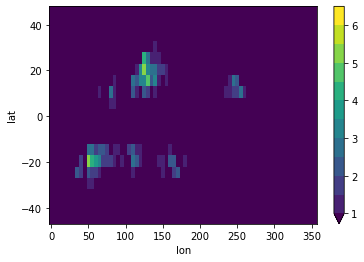

In [103]:
(pdi_map_ann).plot(levels=np.arange(1,7,0.5))

### - significance level for heat and SST

In [95]:
t, p = ttest_ind(heat01x1[:,:,:], heat1x1[70:100,:,:], equal_var=False)
prob_ohc = xr.DataArray(p, coords=temp01x1[:,0,:,:].mean('time').coords)
del(p)

In [96]:
t, p = ttest_ind(heat01x1_x[:,:,:], heat1x1_x[:,:,:], equal_var=False)
prob_ohcx = xr.DataArray(p, coords=temp01x1[:,0,:,:].mean('time').coords)
del(p)

In [97]:
t, p = ttest_ind(temp01x1[:,0,:,:], temp1x1[70:100,0,:,:], equal_var=False)
prob_sst = xr.DataArray(p, coords=temp01x1[:,0,:,:].mean('time').coords)
del(p)

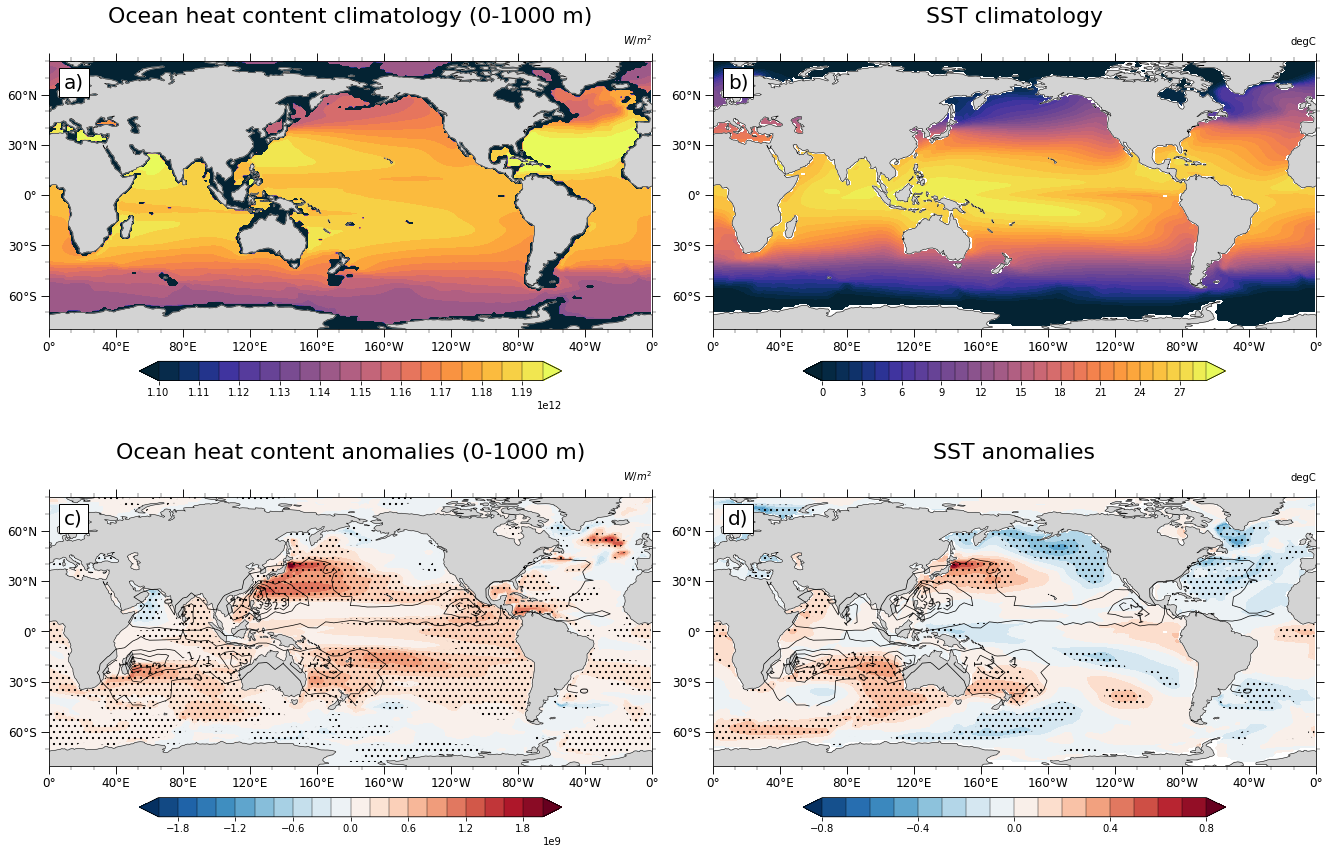

In [110]:
fig = plt.figure(figsize=(22, 15))
fig.tight_layout(pad=-2)

# ocean heat content in control
ax0 = plt.subplot(2, 2, 1, projection=ccrs.PlateCarree(central_longitude=180))
ax0.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax0.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)

contour0 = heat01x1.mean('time').plot.contourf(ax=ax0,
                           transform=ccrs.PlateCarree(),
                           extend='both',
                           cmap = cmocean.cm.thermal,
                           levels=np.arange(1.1e12, 1.2e12, 5e9),
                           add_colorbar=False,
                           add_labels=False,
                           zorder=0)

plt.colorbar(contour0,
             ax=ax0,
#             ticks=np.linspace(-3e9, 3e9, 11),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)



gvutil.set_titles_and_labels(ax0,maintitle="Ocean heat content climatology (0-1000 m)",
                             maintitlefontsize=20,righttitle="$W/m^2$",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax0, xlim=(-180, 180),
                                 ylim=(-80, 80),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))

gvutil.add_major_minor_ticks(ax0, labelsize=12)
gvutil.add_lat_lon_ticklabels(ax0)


#-------------------------
# SST IN CONTROL

ax2 = plt.subplot(2, 2, 2, projection=ccrs.PlateCarree(central_longitude=180))
ax2.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax2.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)

contour2 = temp01x1[:,0,:,:].mean('time').plot.contourf(ax=ax2,
                           transform=ccrs.PlateCarree(),
                           extend='both',
                           cmap = cmocean.cm.thermal,
                           levels=np.arange(0, 30, 1),
                           add_colorbar=False,
                           add_labels=False,
                           zorder=0)

plt.colorbar(contour2,
             ax=ax2,
#             ticks=np.linspace(-3e9, 3e9, 11),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)



gvutil.set_titles_and_labels(ax2,maintitle="SST climatology",
                             maintitlefontsize=20,righttitle="degC",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax2, xlim=(-180, 180),
                                 ylim=(-80, 80),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))

gvutil.add_major_minor_ticks(ax2, labelsize=12)
gvutil.add_lat_lon_ticklabels(ax2)


#-------------------------



#-------------------------
# ohc diff
ax = plt.subplot(2, 2, 3, projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)

contour = heat_diff_1x1.plot.contourf(ax=ax,
                           transform=ccrs.PlateCarree(),
                           extend='both',
                           levels=np.arange(-2e9, 2.1e9, 2e8),
                           add_colorbar=False,
                           add_labels=False,
                           zorder=0)
cf0 = prob_ohc.plot.contourf(ax=ax,
                 transform=ccrs.PlateCarree(),
                 levels=[0,0.05],
                 colors='None',
                 hatches=['..',''],
                  add_colorbar=False,
                add_labels=False,                                                                                       
                    zorder=1
                           )

contourpdi = pdi_map_ann.plot.contour(ax=ax,
                                            transform=ccrs.PlateCarree(),
                                              levels=np.arange(0.1,10.1,1),
                                              linewidths=0.7,
                                              add_labels=False,
                                              colors = "black",
                                              extend='both')
ax.clabel(contourpdi, np.arange(0.1, 10.1, 1), fmt='%d', inline=True, colors='black')

plt.colorbar(contour,
             ax=ax,
             ticks=np.linspace(-3e9, 3e9, 11),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)



gvutil.set_titles_and_labels(ax,maintitle="Ocean heat content anomalies (0-1000 m)",
                             maintitlefontsize=20,righttitle="$W/m^2$",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax, xlim=(-180, 180),
                                 ylim=(-80, 80),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))

gvutil.add_major_minor_ticks(ax, labelsize=12)
gvutil.add_lat_lon_ticklabels(ax)

#----
ax1 = plt.subplot(2, 2, 4, projection=ccrs.PlateCarree(central_longitude=180))
ax1.add_feature(cfeature.LAND,facecolor='lightgray', zorder=1)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.5, zorder=1)

contour1 = temp_diff_1x1.plot.contourf(ax=ax1, 
                                     transform=ccrs.PlateCarree(),
                                     extend='both',
                                     levels = np.arange(-.8, 0.9, 0.1),
                                     add_colorbar=False,
                                     add_labels=False,
                                     zorder=0)

cf1 = prob_sst.plot.contourf(ax=ax1,
                 transform=ccrs.PlateCarree(),
                 levels=[0,0.05],
                 colors='None',
                 hatches=['..',''],
                  add_colorbar=False,
                add_labels=False,
                    zorder=1
                           )

contourpdi2 = pdi_map_ann.plot.contour(ax=ax1,
                                              transform=ccrs.PlateCarree(),
                                              levels=np.arange(0.1,10.1,1),
                                              linewidths=0.7,
                                              add_labels=False,
                                              colors = "black",
                                              extend='both')
ax1.clabel(contourpdi2, np.arange(0.1, 10.1,1), fmt='%d', inline=True, colors='black')
                                              
plt.colorbar(contour1,
             ax=ax1,
             ticks=np.linspace(-2, 2, 11),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)



gvutil.set_titles_and_labels(ax1,maintitle="SST anomalies",
                             maintitlefontsize=20,righttitle="degC",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax1, xlim=(-180, 180),
                                 ylim=(-80, 80),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))

gvutil.add_major_minor_ticks(ax1, labelsize=12)
gvutil.add_lat_lon_ticklabels(ax1)




plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.1,  
                    hspace=0.02) 


ax0.text(0.025, 0.9,
            'a)', fontsize=20,
            transform=ax0.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

ax2.text(0.025, 0.9,
            'b)', fontsize=20,
            transform=ax2.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

ax.text(0.025, 0.9,
            'c)', fontsize=20,
            transform=ax.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

ax1.text(0.025, 0.9,
            'd)', fontsize=20,
            transform=ax1.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))
#plt.show()
plt.savefig("ohc_sst_map.pdf")

In [78]:
temp50_1x1 = temp1x1[0,0,:,:].copy(data=temp1x1[0:5,0,:,:].mean('time').data - temp01x1[:,0,:,:].mean('time').data)
temp50_1x1

<xarray.DataArray 'TEMP' (lat: 180, lon: 360)>
array([[           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       ...,
       [-2.7549267e-04, -2.7596951e-04, -2.7620792e-04, ...,
        -2.7322769e-04, -2.7382374e-04, -2.7465820e-04],
       [-3.0672550e-04, -3.1137466e-04, -3.1661987e-04, ...,
        -2.9230118e-04, -2.9718876e-04, -3.0219555e-04],
       [ 2.5153160e-05,  1.9431114e-05,  1.3947487e-05, ...,
         4.0650368e-05,  3.5285950e-05,  2.9921532e-05]], dtype=float32)
Coordinates:
    time     object 0301-02-01 00:00:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
    z_t      float32 500.0
Attributes:
    long_name:     Potential Temperature
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

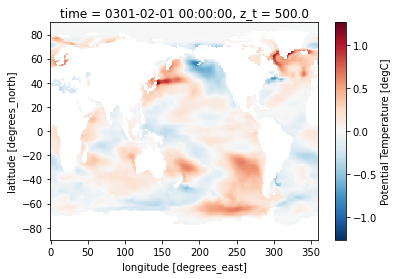

In [79]:
temp50_1x1.plot()

## -Salinity analysis

In [143]:
del dsocn0
del dsocn

In [146]:
dsocn0 = xr.open_dataset('/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010.pop.h.ann.SALT.0331-0400.1x1.nc')
salt01x1 = dsocn0.SALT

In [147]:
salt01x1

<xarray.DataArray 'SALT' (time: 70, z_t: 60, lat: 180, lon: 360)>
[272160000 values with dtype=float32]
Coordinates:
  * time     (time) object 0331-02-01 00:00:00 ... 0400-02-01 00:00:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Attributes:
    long_name:     Salinity
    units:         gram/kilogram
    grid_loc:      3111
    cell_methods:  time: mean

In [148]:
dsocn = xr.open_dataset('/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily/ocn/hist/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily.pop.h.ann.SALT.0330-0473.1x1.nc')
salt1x1 = dsocn.SALT
salt1x1

<xarray.DataArray 'SALT' (time: 144, z_t: 60, lat: 180, lon: 360)>
[559872000 values with dtype=float32]
Coordinates:
  * time     (time) object 0330-02-01 00:00:00 ... 0473-02-01 00:00:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Attributes:
    long_name:     Salinity
    units:         gram/kilogram
    grid_loc:      3111
    cell_methods:  time: mean

In [150]:
salt1x1[70:71]

<xarray.DataArray 'SALT' (time: 1, z_t: 60, lat: 180, lon: 360)>
[3888000 values with dtype=float32]
Coordinates:
  * time     (time) object 0400-02-01 00:00:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Attributes:
    long_name:     Salinity
    units:         gram/kilogram
    grid_loc:      3111
    cell_methods:  time: mean

In [151]:
salt_diff_1x1 = salt1x1[0,0,:,:].copy(data=salt1x1[40:70,0,:,:].mean('time').data - salt01x1[:,0,:,:].mean('time').data)
salt_diff_1x1

<xarray.DataArray 'SALT' (lat: 180, lon: 360)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.00837708, 0.00778961, 0.00718307, ..., 0.01008987, 0.00954056,
        0.00896454],
       [0.01826096, 0.01792526, 0.01758194, ..., 0.01927185, 0.01893234,
        0.01858902],
       [0.02755356, 0.02745819, 0.02733994, ..., 0.02791214, 0.02779388,
        0.02767181]], dtype=float32)
Coordinates:
    time     object 0330-02-01 00:00:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
    z_t      float32 500.0
Attributes:
    long_name:     Salinity
    units:         gram/kilogram
    grid_loc:      3111
    cell_methods:  time: mean

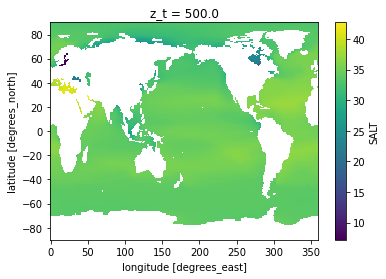

In [158]:
salt01x1[:,0,:,:].mean('time').plot()

### significance level

In [154]:
t, p = ttest_ind(salt01x1[:,0,:,:], salt1x1[40:70,0,:,:], equal_var=False)
prob_sss = xr.DataArray(p, coords=salt01x1[:,0,:,:].mean('time').coords)
del(p)

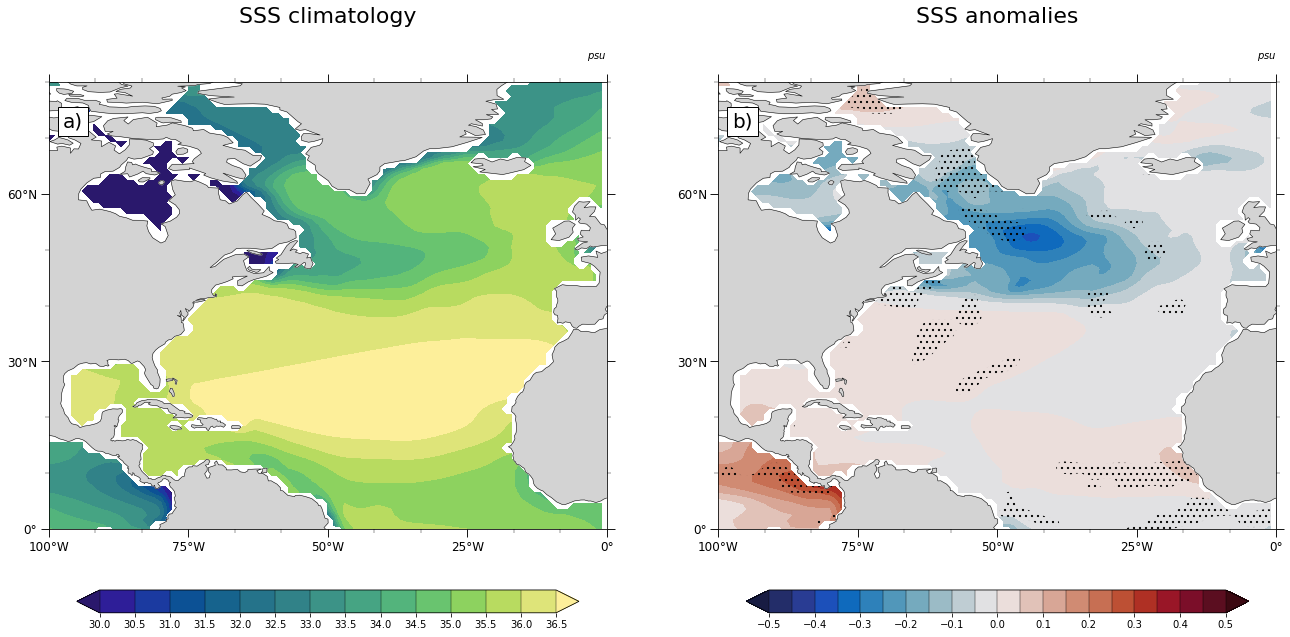

In [326]:
ig = plt.figure(figsize=(22, 15))
fig.tight_layout(pad=-2)

# ocean heat content in control
ax0 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree(central_longitude=180))
ax0.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax0.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)


contour = salt01x1[:,0,:,:].mean('time').plot.contourf(ax=ax0,
                           transform=ccrs.PlateCarree(),
                           extend='both',
                           levels=np.arange(30., 37., 0.5),
                           cmap=cmocean.cm.haline,
                           add_colorbar=False,
                           add_labels=False,
                           zorder=0)


plt.colorbar(contour,
             ax=ax0,
             ticks=np.linspace(30., 37., 15),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.9)



gvutil.set_titles_and_labels(ax0,maintitle="SSS climatology",
                             maintitlefontsize=20,righttitle="$psu$",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax0, xlim=(80, 180),
                                 ylim=(0, 80),
                                 xticks=np.linspace(80, 180, 5),
                                 yticks=np.linspace(-90, 90, 7))

gvutil.add_major_minor_ticks(ax0, labelsize=12)
gvutil.add_lat_lon_ticklabels(ax0)


#---------
ax2 = plt.subplot(1, 2,2, projection=ccrs.PlateCarree(central_longitude=180))
ax2.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax2.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)

contour2 = salt_diff_1x1.plot.contourf(ax=ax2,
                           transform=ccrs.PlateCarree(),
                           extend='both',
                           levels=np.arange(-.5, 0.55, 0.05),
                           cmap=cmocean.cm.balance,
                           add_colorbar=False,
                           add_labels=False,
                           zorder=0)


plt.colorbar(contour2,
             ax=ax2,
             ticks=np.linspace(-.5, .5, 11),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.9)



gvutil.set_titles_and_labels(ax2,maintitle="SSS anomalies",
                             maintitlefontsize=20,righttitle="$psu$",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax2, xlim=(80, 180),
                                 ylim=(0, 80),
                                 xticks=np.linspace(80, 180,5),
                                 yticks=np.linspace(-90, 90, 7))

gvutil.add_major_minor_ticks(ax2, labelsize=12)
gvutil.add_lat_lon_ticklabels(ax2)

cf0 = prob_sss.plot.contourf(ax=ax2,
                 transform=ccrs.PlateCarree(),
                 levels=[0,0.05],
                 colors='None',
                 hatches=['..',''],
                  add_colorbar=False,
                add_labels=False,                                                                                       
                    zorder=1
                           )


ax0.text(0.025, 0.9,
            'a)', fontsize=20,
            transform=ax0.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

ax2.text(0.025, 0.9,
            'b)', fontsize=20,
            transform=ax2.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

ax.text(0.025, 0.9,
            'c)', fontsize=20,
            transform=ax.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

ax1.text(0.025, 0.9,
            'd)', fontsize=20,
            transform=ax1.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))
#plt.show()
plt.savefig("sss_map.pdf")

## -CHECK E-P

In [301]:
del dsocn0
del dsocn

In [297]:
dsocn0 = xr.open_dataset('/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010.pop.h.ann.e-p.0301-0400.1x1.nc')
sfwf01x1 = dsocn0.SFWF
evap_f01x1 = dsocn0.EVAP_F
prec_f01x1 = dsocn0.PREC_F





In [298]:
e_p0_1x1 = evap_f01x1.copy(data=evap_f01x1.data + prec_f01x1.data)

In [305]:
dsocn = xr.open_dataset('./data/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily.pop.h.ann.e-p.0371-0400.1x1.nc')

sfwf_1x1 = dsocn.SFWF
evap_f1x1 = dsocn.EVAP_F
prec_f1x1 = dsocn.PREC_F


In [306]:
e_p_1x1 = evap_f1x1.copy(data=evap_f1x1.data + prec_f1x1.data)

In [309]:
sfwf_diff_1x1 = sfwf_1x1[0,:,:].copy(data=sfwf_1x1.mean('time').data - sfwf01x1[:,:,:].mean('time').data)
sfwf_diff_1x1

<xarray.DataArray 'SFWF' (lat: 180, lon: 360)>
array([[           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       ...,
       [-6.4481537e-07, -6.3985135e-07, -6.3576226e-07, ...,
        -6.6617213e-07, -6.5800486e-07, -6.5065251e-07],
       [-7.9884376e-07, -7.9539677e-07, -7.9184792e-07, ...,
        -8.0858263e-07, -8.0544123e-07, -8.0219252e-07],
       [-8.5473403e-07, -8.5421198e-07, -8.5371357e-07, ...,
        -8.5641659e-07, -8.5583633e-07, -8.5527608e-07]], dtype=float32)
Coordinates:
    time     object 0371-02-01 00:00:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    long_name:     Virtual Salt Flux in FW Flux formulation
    units:         kg/m^2/s
    grid_loc:      2110
    cell_methods:  time: mean

In [310]:
e_p_diff = e_p_1x1[0,:,:].copy(data=e_p_1x1.mean('time').data - e_p0_1x1[:,:,:].mean('time').data)

### significance level

In [311]:
t, p = ttest_ind(e_p0_1x1[:,:,:], e_p_1x1[:,:,:], equal_var=False)
prob_sss = xr.DataArray(p, coords=salt01x1[:,0,:,:].mean('time').coords)
del(p)

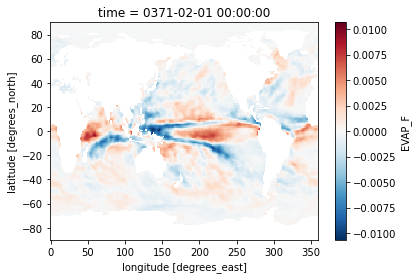

In [312]:
(1000*e_p_diff).plot()

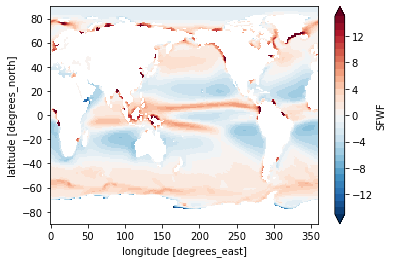

In [320]:
(1e5*sfwf01x1).mean('time').plot(levels=np.arange(-15,16,1))

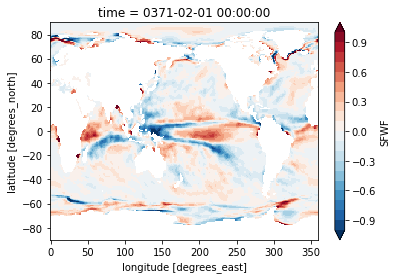

In [316]:
(1e5*sfwf_diff_1x1).plot(levels= np.arange(-1, 1.1,0.1))

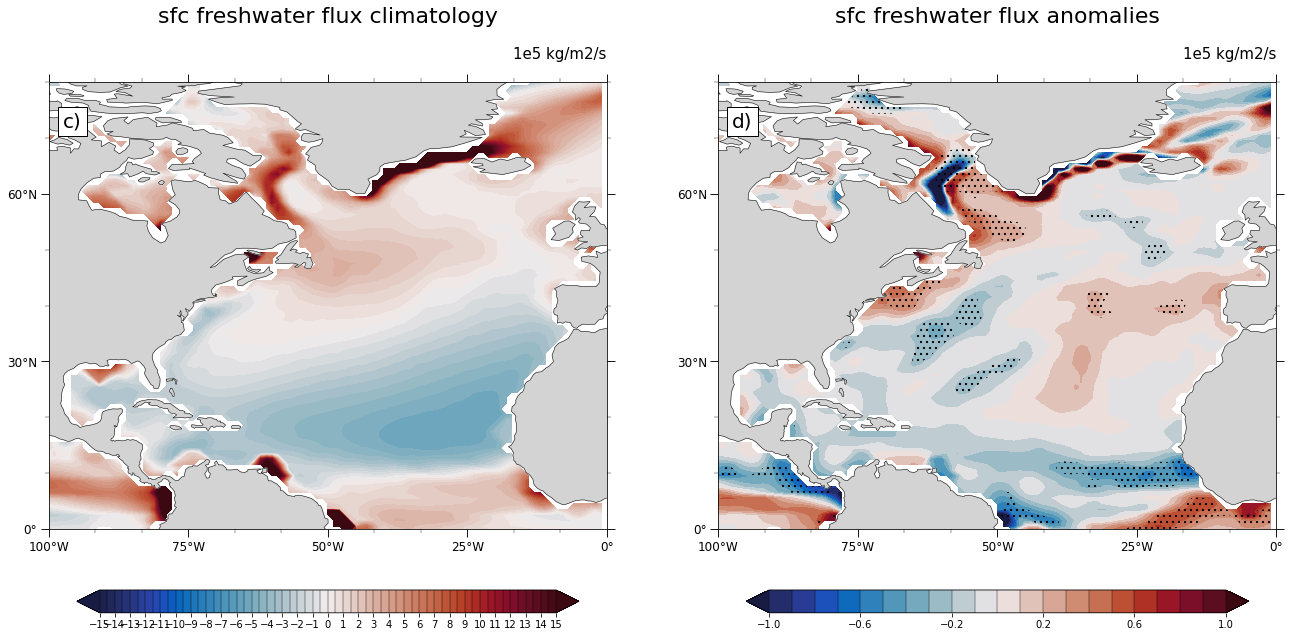

In [325]:
ig = plt.figure(figsize=(22, 15))
fig.tight_layout(pad=-2)

# ocean heat content in control
ax0 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree(central_longitude=180))
ax0.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax0.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)


contour = (1e5*sfwf01x1).mean('time').plot.contourf(ax=ax0,
                           transform=ccrs.PlateCarree(),
                           extend='both',
                           levels=np.arange(-15, 15.5, 0.5),
                           cmap=cmocean.cm.balance,
                           add_colorbar=False,
                           add_labels=False,
                           zorder=0)


plt.colorbar(contour,
             ax=ax0,
             ticks=np.linspace(-15, 15, 31 ),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.9)



gvutil.set_titles_and_labels(ax0,maintitle="sfc freshwater flux climatology",
                             maintitlefontsize=20,righttitle="1e5 kg/m2/s",righttitlefontsize=15)
gvutil.set_axes_limits_and_ticks(ax0, xlim=(80, 180),
                                 ylim=(0, 80),
                                 xticks=np.linspace(80, 180, 5),
                                 yticks=np.linspace(-90, 90, 7))

gvutil.add_major_minor_ticks(ax0, labelsize=12)
gvutil.add_lat_lon_ticklabels(ax0)


#---------
ax2 = plt.subplot(1, 2,2, projection=ccrs.PlateCarree(central_longitude=180))
ax2.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax2.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)

contour2 = (1e5*sfwf_diff_1x1).plot.contourf(ax=ax2,
                           transform=ccrs.PlateCarree(),
                           extend='both',
                           levels=np.arange(-1, 1.1, 0.1),
                           cmap=cmocean.cm.balance,
                           add_colorbar=False,
                           add_labels=False,
                           zorder=0)


plt.colorbar(contour2,
             ax=ax2,
             ticks=np.linspace(-1, 1, 6),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.9)



gvutil.set_titles_and_labels(ax2,maintitle="sfc freshwater flux anomalies",
                             maintitlefontsize=20,righttitle="1e5 kg/m2/s",righttitlefontsize=15)
gvutil.set_axes_limits_and_ticks(ax2, xlim=(80, 180),
                                 ylim=(0, 80),
                                 xticks=np.linspace(80, 180,5),
                                 yticks=np.linspace(-90, 90, 7))

gvutil.add_major_minor_ticks(ax2, labelsize=12)
gvutil.add_lat_lon_ticklabels(ax2)

cf0 = prob_sss.plot.contourf(ax=ax2,
                 transform=ccrs.PlateCarree(),
                 levels=[0,0.05],
                 colors='None',
                 hatches=['..',''],
                  add_colorbar=False,
                add_labels=False,                                                                                       
                    zorder=1
                           )


ax0.text(0.025, 0.9,
            'c)', fontsize=20,
            transform=ax0.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

ax2.text(0.025, 0.9,
            'd)', fontsize=20,
            transform=ax2.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

ax.text(0.025, 0.9,
            'c)', fontsize=20,
            transform=ax.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

ax1.text(0.025, 0.9,
            'd)', fontsize=20,
            transform=ax1.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))
#plt.show()
plt.savefig("sfwf_map.pdf")

## 7. El Nino analysis 

In [43]:
latS = -5.5
latN = 5.5
lonL = 190.
lonR = 241.
nrun = 3

dst = xr.open_dataset("/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010.pop.h.SST.0301-0400.1x1.nc")
TS = dst.TEMP[:,0,:,:]
tropics = TS.sel(lat=slice(latS,latN),lon=slice(lonL,lonR))

time = tropics.time
lat= tropics['lat']
lon = tropics['lon']
ntime = np.size(time)
nlat  = np.size(lat)
nlon = np.size(lon)

In [44]:
ran = np.zeros((12,nlat,nlon)) 
xClm = xr.DataArray(ran,dims = ['month','lat','lon'], coords = [np.arange(1,13),lat,lon])
xClm

i = 0
while i < 12:
    xClm[i,:,:] = tropics[i:ntime:12,:,:].mean('time')
    i = i + 1

# expand then stack to create repeating climatology
    
xClm_4d = xClm.expand_dims({'year':np.arange(1,101)},0)
stacked = xClm_4d.stack(t=('year','month'))
xClm_3d = stacked.transpose('t','lat','lon')
xAnom = tropics
xAnom = tropics-xClm_3d.data

xAnom_avg = xAnom.mean(('lat','lon')).rolling(time=nrun, center=True).mean()
xAnom_min = np.random.rand(ntime)
xAnom_min[:] = -0.5
xAnom_max = np.random.rand(ntime)
xAnom_max[:] = 0.5

Text(0.5, 0, 'year')

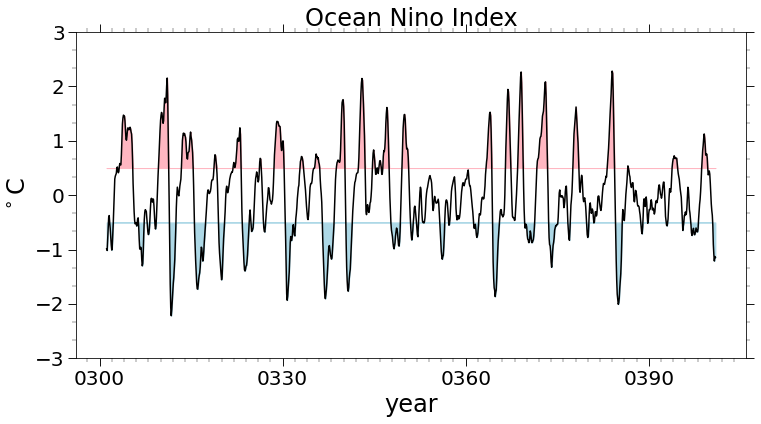

In [45]:
fig,ax = plt.subplots(figsize=(12,6))
x = xAnom_avg.time.dt.year

ax.plot(xAnom_avg.time,xAnom_avg,color='black',label='ONI')
gvutil.add_major_minor_ticks(ax, x_minor_per_major=15, y_minor_per_major=3, labelsize=20)

gvutil.set_axes_limits_and_ticks(ax,ylim=(-3., 3.))
ax.fill_between(xAnom_avg.time.values, xAnom_min, np.min([xAnom_avg.data,xAnom_min],axis=0), color='lightblue', zorder=0)
ax.fill_between(xAnom_avg.time.values, xAnom_max, np.max([xAnom_avg.data,xAnom_max],axis=0), color='lightpink', zorder=1)

ax.set_title('Ocean Nino Index', fontsize=24)#, pad=60.0)
ax.set_ylabel('$^\circ$C', fontsize=24)
ax.set_xlabel('year',fontsize=24)

In [46]:
dst_tc = xr.open_dataset("/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily/ocn/hist/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily.pop.h.SST.0301-0473.1x1.nc")
TS2 = dst_tc.TEMP[:,0,:,:]
tropics2 = TS2.sel(lat=slice(latS,latN),lon=slice(lonL,lonR))
time2 = tropics2.time
ntime2 = np.size(time2)
TS2

<xarray.DataArray 'TEMP' (time: 2088, lat: 180, lon: 360)>
[135302400 values with dtype=float32]
Coordinates:
  * time     (time) object 0301-02-01 00:00:00 ... 0474-01-01 00:00:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
    z_t      float32 500.0
Attributes:
    long_name:     Potential Temperature
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

In [47]:
xClm_4d2 = xClm.expand_dims({'year':np.arange(1,175)},0)
stacked2 = xClm_4d2.stack(t=('year','month'))
xClm_3d2 = stacked2.transpose('t','lat','lon')
xAnom2 = tropics2
xAnom2 = tropics2-xClm_3d2.data

xAnom_avg2 = xAnom2.mean(('lat','lon')).rolling(time=nrun, center=True).mean()
xAnom_min2 = np.random.rand(ntime2)
xAnom_min2[:] = -0.5
xAnom_max2 = np.random.rand(ntime2)
xAnom_max2[:] = 0.5

Text(0.5, 0, 'year')

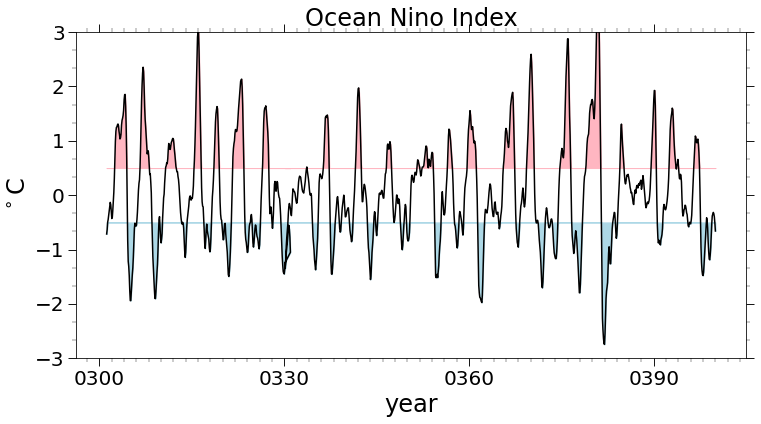

In [ ]:
fig,ax = plt.subplots(figsize=(12,6))
x = xAnom_avg2.time.dt.year

ax.plot(xAnom_avg2.time[0:1200],xAnom_avg2[0:1200],color='black',label='ONI')
gvutil.add_major_minor_ticks(ax, x_minor_per_major=15, y_minor_per_major=3, labelsize=20)

gvutil.set_axes_limits_and_ticks(ax,ylim=(-3., 3.))
ax.fill_between(xAnom_avg2[0:1200].time.values, xAnom_min2[0:1200], np.min([xAnom_avg2[0:1200].data,xAnom_min2[0:1200]],axis=0), color='lightblue', zorder=0)
ax.fill_between(xAnom_avg2[0:1200].time.values, xAnom_max2[0:1200], np.max([xAnom_avg2[0:1200].data,xAnom_max2[0:1200]],axis=0), color='lightpink', zorder=1)

ax.set_title('Ocean Nino Index', fontsize=24)#, pad=60.0)
ax.set_ylabel('$^\circ$C', fontsize=24)
ax.set_xlabel('year',fontsize=24)

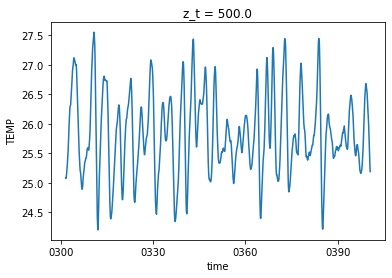

In [87]:
tropics.mean(('lat','lon')).rolling(time=12, center=True).mean().plot()

In [91]:
anom =  tropics.copy(data=tropics2[0:1200].data - tropics.data)


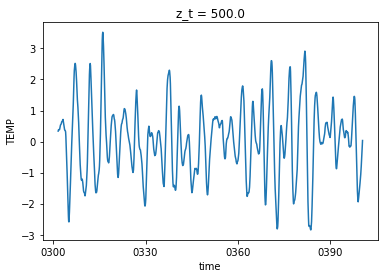

In [92]:

anom.mean(('lat','lon')).rolling(time=12, center=True).mean().plot()

In [9]:
TLAT = ds.TLAT
temp_diff = tempetc.copy(data=(tempetc.data-temp0.mean('time').data))
temp_diff

<xarray.DataArray 'TEMP' (time: 173, z_t: 60, nlat: 384, nlon: 320)>
array([[[[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [-0.01310802, -0.01302063, -0.01317108, ...,         nan,
                  nan,         nan],
         ...,
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [-0.05522311, -0.05483198, -0.05457067, ...,         nan,
                  nan,         nan],
...
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]]]], dtype=float32)
Coordinates:
    TLAT     (nlat, nlon) float64 ...
    TLONG    (nlat, nlon) float64 ...
  * time     (time) object 0301-02-01 00:00:00 ... 0473-02-01 00:00:00
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Potential Temperature
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

In [10]:
#trop1 = temp_diff.where(TLAT<40)
#trop2 = trop1.where(TLAT>-40)
plt_temp =temp_diff.transpose('z_t','time','nlat','nlon')
plt_temp

<xarray.DataArray 'TEMP' (z_t: 60, time: 173, nlat: 384, nlon: 320)>
array([[[[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [-0.01310802, -0.01302063, -0.01317108, ...,         nan,
                  nan,         nan],
         ...,
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [ 0.01014137,  0.00742877,  0.00539005, ...,         nan,
                  nan,         nan],
...
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]],

        [[        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         ...,
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan, ...,         nan,
                  nan,         nan]]]], dtype=float32)
Coordinates:
    TLAT     (nlat, nlon) float64 ...
    TLONG    (nlat, nlon) float64 ...
  * time     (time) object 0301-02-01 00:00:00 ... 0473-02-01 00:00:00
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Potential Temperature
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

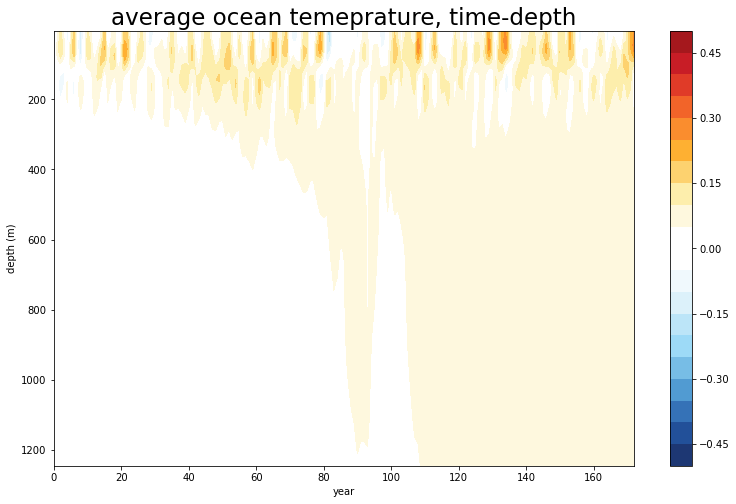

In [15]:
fig3,ax= plt.subplots(figsize=(13, 8))   # now you can reference the first object
cs2 = ax.contourf(np.arange(0,173,1),zt_in_m.isel(z_t=slice(0,42)), plt_temp.isel(z_t=slice(0,42), time=slice(0,173)).mean(('nlat','nlon')),levels=np.arange(-.5,0.55,0.05),cmap=gvcmaps.BlueWhiteOrangeRed)
ax.invert_yaxis()
ax.set_title('average ocean temeprature, time-depth', fontsize=23)
ax.set_ylabel('depth (m)')

ax.set_xlabel('year')
fig3.colorbar(cs2, ax=ax)

## 8. Get  tropical ocean temperature anomalies structure

In [ ]:
#dsocn0 = xr.open_dataset('/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010.pop.h.ann.TEMP.0301-0330.1x1.nc')
#temp01x1 = dsocn0.TEMP
#temp01x1

In [ ]:
#dsocn = xr.open_dataset('/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily/ocn/hist/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily.pop.h.ann.TEMP.0301-0473.1x1.nc')

In [ ]:
#temp1x1 = dsocn.TEMP


In [62]:
trop_diff = temp1x1[:,:,80:100,:].copy(data=(temp1x1[:,:,80:100,:] - temp01x1[:,:,80:100,:].mean('time')))

In [63]:
plt_trop_diff = trop_diff[70:100,0:40,:,120:280].mean(('time','lat')).transpose('z_t','lon')
plt_trop0 =temp01x1[:,:,80:100,:].mean(('time','lat')).transpose('z_t','lon')
#nwp_diff = temp1x1[:,:,30:150,:].mean('lon').copy(data=(temp1x1[:,:,30:150,:].mean('lon') - temp01x1[:,:,30:150,:].mean(('time','lon'))))
nwp_diff = temp1x1[:,:,30:150,120:250].mean('lon').copy(data=(temp1x1[:,:,30:150,120:250].mean('lon') - temp01x1[:,:,30:150,120:250].mean(('time','lon'))))

In [81]:
nwp_diff = temp1x1[:,:,30:150,120:200].mean('lon').copy(data=(temp1x1[:,:,30:150,120:200].mean('lon') - temp01x1[:,:,30:150,120:200].mean(('time','lon'))))

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/ipykernel_launcher.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator


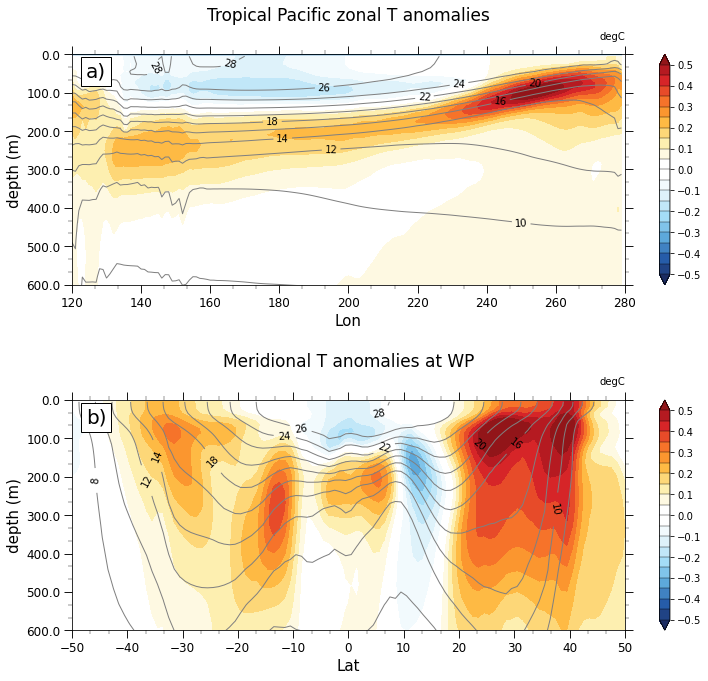

In [83]:
plt_nwp_diff = nwp_diff[70:100,0:40].mean('time').transpose('z_t','lat')
plt_nwp0 = temp01x1[:,:,30:150,120:200].mean(('time','lon'))


fig5,[ax0, ax1] = plt.subplots(2, 1,figsize=(12, 10))   # now you can reference the first object

plt_diff = plt_trop_diff.isel(z_t=slice(0,40)).plot.contourf(ax=ax0,
                                                             levels=np.arange(-0.5, 0.55, 0.05),
                                                             extend='both',
                                                             cmap=gvcmaps.BlueWhiteOrangeRed,
                                                             add_colorbar=False,
                                                             add_labels=False)

#cs0 = ax0.contourf(plt_trop_diff.lon,zt_in_m.isel(z_t=slice(0,40)), plt_trop_diff, levels=np.arange(-.5,0.55,0.05),  extend='both',cmap = gvcmaps.BlueWhiteOrangeRed)

plt0 = plt_trop0.isel(z_t=slice(0,40),lon=slice(120,280)).plot.contour(ax=ax0,
                       levels=np.arange(8,32,2),
                       colors='gray',
                       linewidths=1.0,
                       add_labels=False)
ax0.clabel(plt0, np.arange(8,32,2), fmt='%d', inline=True, colors='black')

# overlay mixed layer depth on top?
cs0 = ax0.plot(np.arange(120,280),hmxl0_in_m[:,80:100,120:280].mean(('time','lat')))



plt.colorbar(plt_diff,
             ax=ax0,
             ticks=np.linspace(-.5, .5, 11),
             orientation='vertical',            
             drawedges=True,
             )

ax0.invert_yaxis()

ax0.set_ylabel('depth (m)',fontsize=15)
ax0.set_xlabel('Lon', fontsize=15)
gvutil.add_major_minor_ticks(ax0, labelsize=12)
gvutil.set_titles_and_labels(ax0,maintitle='Tropical Pacific zonal T anomalies',
                             maintitlefontsize=15,righttitle="degC",righttitlefontsize=10)

gvutil.set_axes_limits_and_ticks(ax0, xlim=(120, 280),
                                 ylim=(60000, 0),
                                 xticks=np.linspace(120, 280, 9))
                               # yticks=np.linspace(400, 0, 100))


ax0.set_yticklabels(np.linspace(0,600,7))
#plt.show()



#-------------------------
#cs1 = ax1.contourf(plt_nwp_diff.lat,zt_in_m.isel(z_t=slice(0,40)), plt_nwp_diff, levels=np.arange(-.5,.55,0.05), extend='both',cmap=gvcmaps.BlueWhiteOrangeRed)
plt_diff1=plt_nwp_diff.isel(z_t=slice(0,40)).plot.contourf(ax=ax1, levels=np.arange(-0.5,0.55, 0.05),extend='both',cmap=gvcmaps.BlueWhiteOrangeRed,
                                   add_colorbar=False,
                                   add_labels=False)


plt1 = plt_nwp0.isel(z_t=slice(0,40)).plot.contour(ax=ax1,
                       levels=np.arange(8,32,2),
                       colors='gray',
                       linewidths=1.0,
                       add_labels=False)
                     
ax1.clabel(plt1, np.arange(8,32,2), fmt='%d', inline=True, colors='black')


plt.colorbar(plt_diff1,
             ax=ax1,
             ticks=np.linspace(-.5, .5, 11),
             orientation='vertical',            
             drawedges=True,
             )

ax1.invert_yaxis()



ax1.set_ylabel('depth (m)',fontsize=15)
ax1.set_xlabel('Lat',fontsize=15)

gvutil.set_titles_and_labels(ax1,maintitle='Meridional T anomalies at WP',
                             maintitlefontsize=15,righttitle="degC",righttitlefontsize=10)

gvutil.set_axes_limits_and_ticks(ax1, xlim=(-50, 50),
                                 ylim=(60000, 0),
                                 xticks=np.linspace(-50, 50, 11))


ax1.set_yticklabels(np.linspace(0,600,7))


plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.1,  
                    hspace=0.5) 


ax0.text(0.025, 0.9,
            'a)', fontsize=20,
            transform=ax0.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

ax1.text(0.025, 0.9,
            'b)', fontsize=20,
            transform=ax1.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))
gvutil.add_major_minor_ticks(ax1, labelsize=12)

plt.savefig("ocn_temp_anom_sections.pdf")
plt.show()

#moc0[:,0,0,:,:].mean('time').plot()


/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  if sys.path[0] == '':


NameError: name 'pdi_map_ann' is not defined

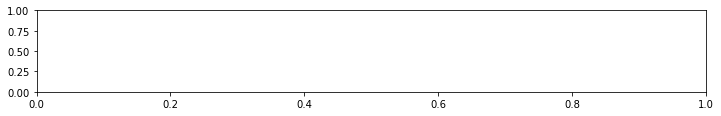

In [74]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig = plt.figure(figsize=(12, 6),constrained_layout=True)
fig.tight_layout(pad=-2)

nrows, ncols = 2,1
widths = [1]
heights = [0.25, 0.75]

spec = fig.add_gridspec(nrows, ncols,width_ratios=widths,
                          height_ratios=heights)

fig.subplots_adjust(hspace=0)

ax0= fig.add_subplot(spec[0,0])

plt_diff_pdi = pdi_map_ann.sel(lat=slice(-20,20),lon=slice(120,280)).mean('lat').plot.line(ax=ax0,
                                                                                          color='black',
                                                                                          linewidth=2.)

ax0.tick_params('x', which='both', bottom=False)

gvutil.set_titles_and_labels(ax0,
                            xlabel=""
                            )
gvutil.set_axes_limits_and_ticks(ax0,
                                 xlim=[120, 280],
                                 ylim=[0, 5],
                                yticks=[1,2,3,4],
                                 xticklabels=[''],
                                 yticklabels=[1,2,3,4]
                                )

#-----------------------------------------------
ax1= fig.add_subplot(spec[1,0])

plt_diff = plt_trop_diff.isel(z_t=slice(0,40)).plot.contourf(ax=ax1,
                                                             levels=np.arange(-0.5, 0.55, 0.05),
                                                             extend='both',
                                                             cmap=gvcmaps.BlueWhiteOrangeRed,
                                                             add_colorbar=False,
                                                             add_labels=False)

#cs0 = ax0.contourf(plt_trop_diff.lon,zt_in_m.isel(z_t=slice(0,40)), plt_trop_diff, levels=np.arange(-.5,0.55,0.05),  extend='both',cmap = gvcmaps.BlueWhiteOrangeRed)

plt0 = plt_trop0.isel(z_t=slice(0,40),lon=slice(120,280)).plot.contour(ax=ax1,
                       levels=np.arange(8,32,2),
                       colors='gray',
                       linewidths=1.0,
                       add_labels=False)
ax1.clabel(plt0, np.arange(8,32,2), fmt='%d', inline=True, colors='black')

# overlay mixed layer depth on top?

cax1 = inset_axes(ax1,
                  width='100%',
                  height='7%',
                  loc='lower left',
                  bbox_to_anchor=(0, -0.35, 1, 1),
                  bbox_transform=ax1.transAxes,
                  borderpad=0.2)


cbar = plt.colorbar(plt_diff,
             cax=cax1,
             ticks=np.linspace(-.5, .5, 11),
             orientation='horizontal',            
             drawedges=True,
             )

ax1.invert_yaxis()
ax1.set_ylabel('depth (m)',fontsize=15)
ax1.set_xlabel('Lon', fontsize=15)
gvutil.add_major_minor_ticks(ax1, labelsize=12)
gvutil.set_titles_and_labels(ax0,
                             maintitle='Tropical Pacific zonal T anomalies',
                             maintitlefontsize=15,righttitle="degC",righttitlefontsize=10)
                            
gvutil.set_axes_limits_and_ticks(ax1, xlim=(120, 280),
                                 ylim=(60000, 0),
                                 xticks=np.linspace(120, 280, 9))
                               # yticks=np.linspace(400, 0, 100))


ax1.set_yticklabels(np.linspace(0,600,7))
#plt.show()


ax1.text(0.01, -2.85,
            'a)', fontsize=20,
            transform=ax0.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

plt.savefig("ocn_temp_anom_horizontal_sections.pdf")

plt.show()


/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  # This is added back by InteractiveShellApp.init_path()
/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/geocat/viz/util.py:187: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)
/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator


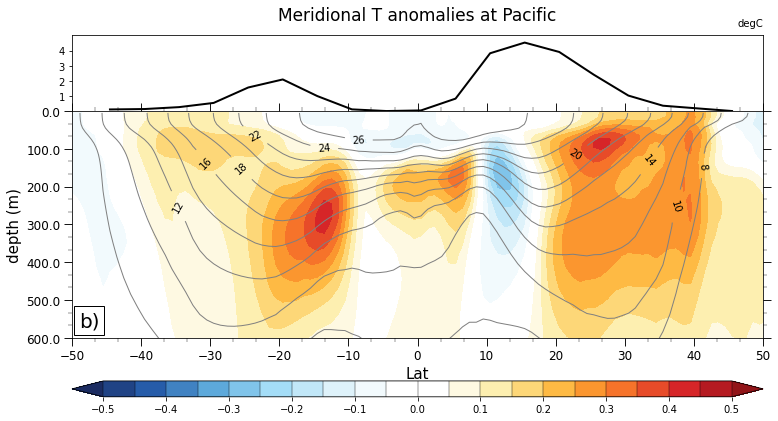

In [256]:
fig = plt.figure(figsize=(12, 6),constrained_layout=True)
#fig.tight_layout(pad=-2)

nrows, ncols = 2,1
widths = [1]
heights = [0.25, 0.75]

spec = fig.add_gridspec(nrows, ncols,width_ratios=widths,
                          height_ratios=heights)

fig.subplots_adjust(hspace=0)

ax0= fig.add_subplot(spec[0,0])

plt_diff_pdi = pdi_map_ann.sel(lat=slice(-50,50),lon=slice(120,270)).mean('lon').plot.line(ax=ax0,
                                                                                          color='black',
                                                                                          linewidth=2.)

ax0.tick_params('x', which='both', bottom=False)

gvutil.set_titles_and_labels(ax0,
                            xlabel=""
                            )
gvutil.set_axes_limits_and_ticks(ax0,
                                 xlim=[-50, 50],
                                 ylim=[0, 5],
                                yticks=[1,2,3,4],
                                 xticklabels=[''],
                                 yticklabels=[1,2,3,4]
                                )

#-----------------------------------------------
ax1= fig.add_subplot(spec[1,0])

plt_diff1=plt_nwp_diff.isel(z_t=slice(0,40)).plot.contourf(ax=ax1, levels=np.arange(-0.5,0.55, 0.05),extend='both',cmap=gvcmaps.BlueWhiteOrangeRed,
                                   add_colorbar=False,
                                   add_labels=False)


plt1 = plt_nwp0.isel(z_t=slice(0,40)).plot.contour(ax=ax1,
                       levels=np.arange(8,32,2),
                       colors='gray',
                       linewidths=1.0,
                       add_labels=False)
                     
ax1.clabel(plt1, np.arange(8,32,2), fmt='%d', inline=True, colors='black')



ax1.invert_yaxis()
ax1.set_ylabel('depth (m)',fontsize=15)
ax1.set_xlabel('Lat',fontsize=15)
gvutil.add_major_minor_ticks(ax1, labelsize=12)

gvutil.set_titles_and_labels(ax0,maintitle='Meridional T anomalies at Pacific',
                             maintitlefontsize=15,righttitle="degC",righttitlefontsize=10)

gvutil.set_axes_limits_and_ticks(ax1, xlim=(-50, 50),
                                 ylim=(60000, 0),
                                 xticks=np.linspace(-50, 50, 11))


ax1.set_yticklabels(np.linspace(0,600,7))



# overlay mixed layer depth on top?

cax1 = inset_axes(ax1,
                  width='100%',
                  height='7%',
                  loc='lower left',
                  bbox_to_anchor=(0, -0.26, 1, 1),
                  bbox_transform=ax1.transAxes,
                  borderpad=0.)


cbar = plt.colorbar(plt_diff1,
             cax=cax1,
             ticks=np.linspace(-.5, .5, 11),
             orientation='horizontal',            
             drawedges=True,
             )

ax1.text(0.01, -2.85,
            'b)', fontsize=20,
            transform=ax0.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))


plt.subplots_adjust(left=0.1, 
                    bottom=0.2,  
                    right=0.9,  
                    top=0.9)  

plt.savefig("ocn_temp_anom_meridional_sections.pdf")
                    





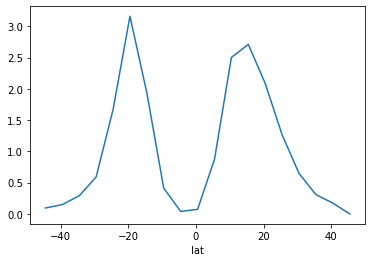

In [219]:
pdi_map_ann.mean('lon').plot()

In [2]:
#hmxl0_in_m[:,:,180:250].mean(('time','lon')).plot()
fig5,ax0 = plt.subplots(2, 1,figsize=(12, 10))   # now you can reference the first object

#plt00 = hmxl0_in_m[:,80:100,120:280].mean(('time','lat')).plot(ax=ax0)
cs0 = ax0[0].plot(hmxl0_in_m[:,80:100,120:280].mean(('time','lat')),color='blue')
cs01 =ax0[0].plot(hmxl_in_m[:,80:100,120:280].mean(('time','lat')),color='red')
cs1 = ax0[1].plot(hmxl_diff[:,80:100,120:280].mean(('time','lat')))      
ax0[0].invert_yaxis()
ax0[1].invert_yaxis()

NameError: name 'plt' is not defined

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


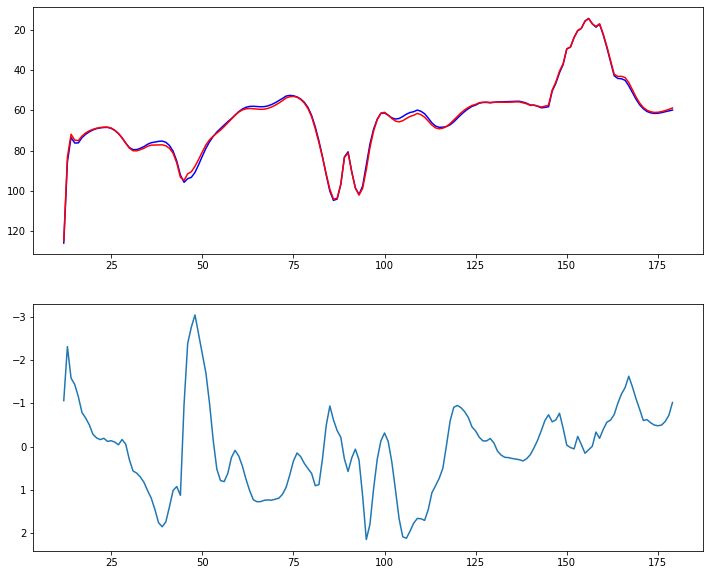

In [59]:
#hmxl0_in_m[:,:,180:250].mean(('time','lon')).plot()
fig5,ax0 = plt.subplots(2, 1,figsize=(12, 10))   # now you can reference the first object

cs0 = ax0[0].plot(hmxl0_in_m[:,:,180:240].mean(('time','lon')),color='blue')
cs01 =ax0[0].plot(hmxl_in_m[:,:,180:240].mean(('time','lon')),color='red')
cs1 = ax0[1].plot(hmxl_diff[:,:,180:240].mean(('time','lon')))      
ax0[0].invert_yaxis()
ax0[1].invert_yaxis()

## 9.Ocean mixed layer depth diagnose

### - annual climatology

In [10]:
dsh = xr.open_dataset("/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily/ocn/hist/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily.pop.h.ann.hmxl.0330-0473.1x1.nc")
hmxl = dsh.HMXL
bsf = dsh.BSF

In [11]:
dsh0 = xr.open_dataset("/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily/ocn/hist/b.e13.B1850C5CN.ne30_g16.005ax_exact.pop.h.ann.hmxl.0301-0320.1x1.nc")
hmxl0= dsh0.HMXL
bsf0 = dsh0.BSF

In [12]:
import cf_units as cf
hmxl0_in_m = change_units(dsh0, "HMXL", "HMXL", "m")
hmxl_in_m = change_units(dsh, "HMXL", "HMXL", "m")

In [261]:
bsf_diff = bsf.copy(data=(bsf.data-bsf0.mean('time').data))
bsf_diff_mask= bsf_diff.where(bsf_diff.data!=0)

In [262]:
hmxl0_in_m

<xarray.DataArray (time: 20, lat: 180, lon: 360)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [60.675507, 60.583717, 60.49168 , ..., 60.941246, 60.85493 ,
         60.76706 ],
        [59.948986, 59.87181 , 59.794228, ..., 60.177982, 60.10207 ,
         60.025738],
        [59.229446, 59.18902 , 59.14863 , ..., 59.350983, 59.31043 ,
         59.26992 ]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [59.54824 , 59.55111 , 59.55359 , ..., 59.539806, 59.542465,
         59.54498 ],
        [59.30736 , 59.303185, 59.298817, ..., 59.31877 , 59.315155,
         59.31135 ],
        [58.969357, 58.96592 , 58.96246 , ..., 58.97956 , 58.976177,
         58.97278 ]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [56.824635, 56.84195 , 56.85852 , ..., 56.77117 , 56.78923 ,
         56.806576],
        [56.01353 , 56.02305 , 56.03211 , ..., 55.982235, 55.99313 ,
         56.00356 ],
        [55.254948, 55.26038 , 55.265747, ..., 55.238216, 55.243866,
         55.249443]]], dtype=float32)
Coordinates:
  * time     (time) object 0301-02-01 00:00:00 ... 0320-02-01 00:00:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5

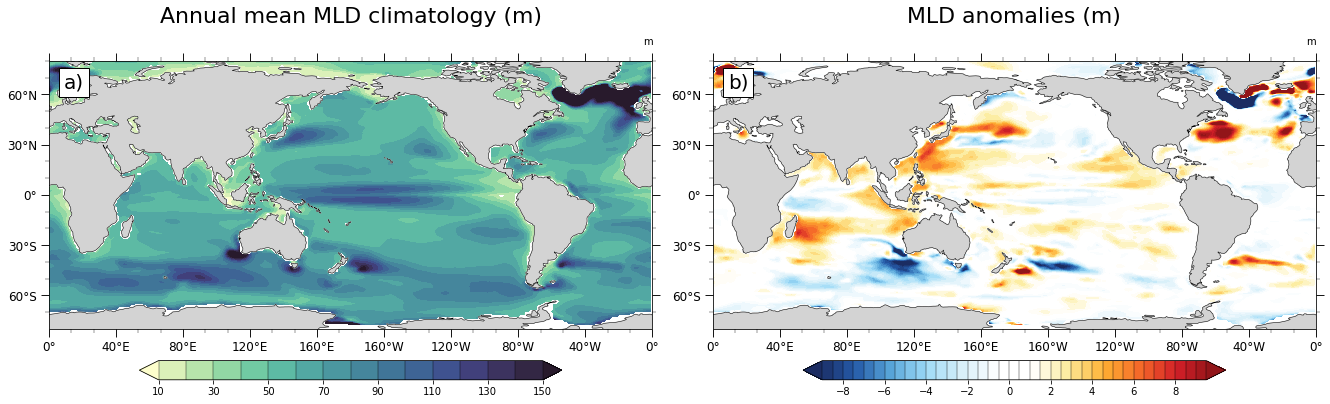

In [15]:
hmxl_diff = hmxl_in_m.copy(data=(hmxl_in_m.data-hmxl0_in_m.mean('time').data))
hmxl_diff_mask= hmxl_diff.where(hmxl_diff.data!=0)

fig = plt.figure(figsize=(22, 15))
fig.tight_layout(pad=-2)

# ocean heat content in control
ax0 = plt.subplot(2, 2, 1, projection=ccrs.PlateCarree(central_longitude=180))
ax0.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax0.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)

levels = np.arange(10,160,10)
contour0 = hmxl0_in_m.mean('time').plot.contourf(ax=ax0,
                           transform=ccrs.PlateCarree(),
                           extend='both',
                           cmap = cmocean.cm.deep,
                           levels=levels,
                           add_colorbar=False,
                           add_labels=False,
                           zorder=0)

plt.colorbar(contour0,
             ax=ax0,
#             ticks=np.linspace(-3e9, 3e9, 11),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)



gvutil.set_titles_and_labels(ax0,maintitle="Annual mean MLD climatology (m)",
                             maintitlefontsize=20,righttitle="m",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax0, xlim=(-180, 180),
                                 ylim=(-80, 80),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))

gvutil.add_major_minor_ticks(ax0, labelsize=12)
gvutil.add_lat_lon_ticklabels(ax0)

#---------
# plot diff

ax1 = plt.subplot(2, 2, 2, projection=ccrs.PlateCarree(central_longitude=180))
ax1.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)
levels2 = np.arange(-9.,10.,0.5)
contour1 = hmxl_diff_mask[40:70,:,:].mean('time').plot.contourf(ax=ax1,
                           transform=ccrs.PlateCarree(),
                           extend='both',
                           cmap = gvcmaps.BlueWhiteOrangeRed,
                           levels=levels2,
                           add_colorbar=False,
                           add_labels=False,
                           zorder=0)





plt.colorbar(contour1,
             ax=ax1,
#             ticks=np.linspace(-3e9, 3e9, 11),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)

gvutil.set_titles_and_labels(ax1,maintitle="MLD anomalies (m)",
                             maintitlefontsize=20,righttitle="m",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax1, xlim=(-180, 180),
                                 ylim=(-80, 80),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))


gvutil.add_major_minor_ticks(ax1, labelsize=12)
gvutil.add_lat_lon_ticklabels(ax1)




plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.1,  
                    hspace=0.05) 


ax0.text(0.025, 0.9,
            'a)', fontsize=20,
            transform=ax0.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

ax1.text(0.025, 0.9,
            'b)', fontsize=20,
            transform=ax1.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

plt.savefig("annual_mld_anom_2panel.pdf")




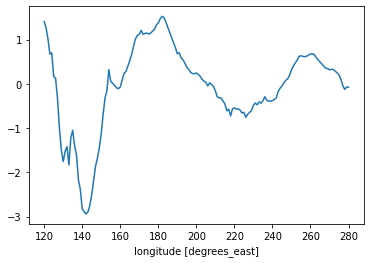

In [17]:
hmxl_diff.sel(lat=slice(-5,5),lon=slice(120,280)).mean(('time','lat')).plot()

### - seasonal hmxl and sst a

In [84]:
dsh0m = xr.open_dataset('/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily/ocn/hist/b.e13.B1850C5CN.ne30_g16.005ax_exact.pop.h.monclm.0301-0320.1x1.nc')
hmxl_m0 = change_units(dsh0m, 'HMXL','HMXL','m')
temp_m0 = change_units(dsh0m,'TEMP','TEMP','degC')


In [85]:
dshm = xr.open_dataset('/glade/scratch/huili7/archive/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily/ocn/hist/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily.pop.h.monclm.0370-0399.1x1.nc')
hmxl_m = change_units(dshm, 'HMXL','HMXL','m')
temp_m = change_units(dshm,'TEMP','TEMP','degC')


In [86]:
hmxl_m0_season = hmxl_m0[0].copy(data=(hmxl_m0[2].data-hmxl_m0[8].data))
hmxl_m_season = hmxl_m[0].copy(data=(hmxl_m[2].data - hmxl_m[8].data))

In [87]:
season_diff = hmxl_m_season.copy(data=hmxl_m_season.data - hmxl_m0_season.data)

In [88]:
hmxl_m_diff = hmxl_m.copy(data=(hmxl_m.data-hmxl_m0.data))
hmxl_m_diff

<xarray.DataArray (time: 12, lat: 180, lon: 360)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-1.9145355 , -1.9283905 , -1.942215  , ..., -1.8733826 ,
         -1.8869781 , -1.9006348 ],
        [-1.4922867 , -1.4927292 , -1.4929276 , ..., -1.4895477 ,
         -1.4907074 , -1.4916153 ],
        [-1.0852966 , -1.0858383 , -1.0863647 , ..., -1.0835495 ,
         -1.0841599 , -1.0847397 ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [-1.2635765 , -1.2802048 , -1.296711  , ..., -1.2132034 ,
         -1.2301025 , -1.2468262 ],
        [-0.8261337 , -0.83514404, -0.8439903 , ..., -0.7980728 ,
         -0.8075943 , -0.81694794],
        [-0.45233917, -0.4544983 , -0.45661163, ..., -0.44555283,
         -0.44786453, -0.45013046]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-1.7938766 , -1.8122177 , -1.8303604 , ..., -1.7375488 ,
         -1.7565155 , -1.7753143 ],
        [-1.3152695 , -1.327919  , -1.3405304 , ..., -1.2771301 ,
         -1.2898712 , -1.3025742 ],
        [-0.7748413 , -0.7794647 , -0.7840347 , ..., -0.7606354 ,
         -0.765419  , -0.77015686]]], dtype=float32)
Coordinates:
  * time     (time) object 0370-02-01 00:00:00 ... 0371-01-01 00:00:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5

In [89]:
temp_m_diff = temp_m.copy(data=temp_m.data - temp_m0.data)
temp_m_diff

<xarray.DataArray (time: 12, z_t: 60, lat: 180, lon: 360)>
array([[[[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [-7.80820847e-05, -8.78572464e-05, -9.70363617e-05, ...,
          -5.66244125e-05, -6.15119934e-05, -6.78300858e-05],
         [-5.98430634e-05, -6.22272491e-05, -6.46114349e-05, ...,
          -5.22136688e-05, -5.48362732e-05, -5.73396683e-05],
         [ 1.70469284e-05,  2.01463699e-05,  2.33650208e-05, ...,
           7.51018524e-06,  1.07288361e-05,  1.38282776e-05]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
...
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]]]],
      dtype=float32)
Coordinates:
  * time     (time) object 0370-02-01 00:00:00 ... 0371-01-01 00:00:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05

In [91]:
nwp_diff_m = temp_m_diff[:,:,30:150,120:200].mean('lon')

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/ipykernel_launcher.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator


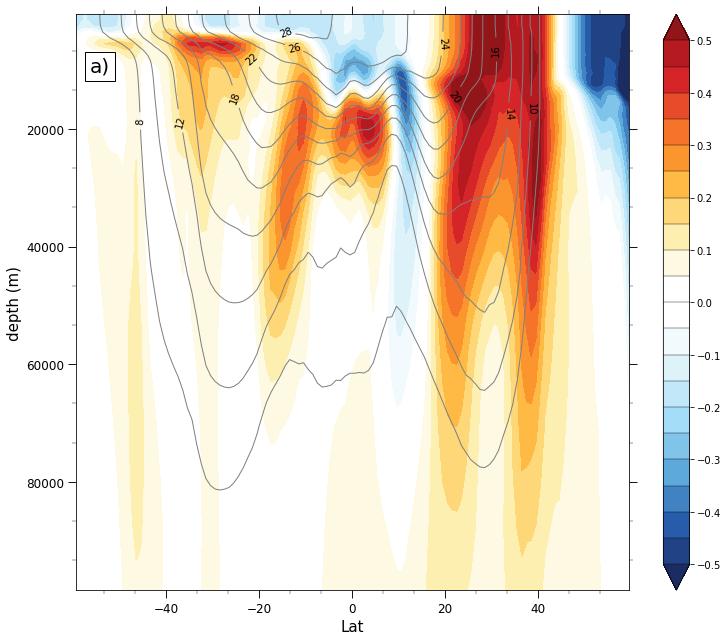

In [101]:
month=1
plt_nwp_diff = nwp_diff_m[month,0:40].transpose('z_t','lat')
plt_nwp0 = temp_m0[month,:,30:150,120:200].mean('lon')


fig5,ax0 = plt.subplots(1, 1,figsize=(12, 10))   # now you can reference the first object



#-------------------------
#cs1 = ax1.contourf(plt_nwp_diff.lat,zt_in_m.isel(z_t=slice(0,40)), plt_nwp_diff, levels=np.arange(-.5,.55,0.05), extend='both',cmap=gvcmaps.BlueWhiteOrangeRed)
plt_diff1=plt_nwp_diff.isel(z_t=slice(0,40)).plot.contourf(ax=ax0, levels=np.arange(-0.5,0.55, 0.05),extend='both',cmap=gvcmaps.BlueWhiteOrangeRed,
                                   add_colorbar=False,
                                   add_labels=False)


plt1 = plt_nwp0.isel(z_t=slice(0,40)).plot.contour(ax=ax0,
                       levels=np.arange(8,32,2),
                       colors='gray',
                       linewidths=1.0,
                       add_labels=False)
                     
ax0.clabel(plt1, np.arange(8,32,2), fmt='%d', inline=True, colors='black')


plt.colorbar(plt_diff1,
             ax=ax0,
             ticks=np.linspace(-.5, .5, 11),
             orientation='vertical',            
             drawedges=True,
             )

ax0.invert_yaxis()



ax0.set_ylabel('depth (m)',fontsize=15)
ax0.set_xlabel('Lat',fontsize=15)

gvutil.set_titles_and_labels(ax1,maintitle='Meridional T anomalies at WP',
                             maintitlefontsize=15,righttitle="degC",righttitlefontsize=10)

gvutil.set_axes_limits_and_ticks(ax1, xlim=(-50, 50),
                                 ylim=(60000, 0),
                                 xticks=np.linspace(-50, 50, 11))


ax1.set_yticklabels(np.linspace(0,600,7))


plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.1,  
                    hspace=0.5) 


ax0.text(0.025, 0.9,
            'a)', fontsize=20,
            transform=ax0.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))


gvutil.add_major_minor_ticks(ax0, labelsize=12)

#plt.savefig("ocn_temp_anom_sections.pdf")
plt.show()

#moc0[:,0,0,:,:].mean('time').plot()


Text(0.025, 0.9, 'b)')

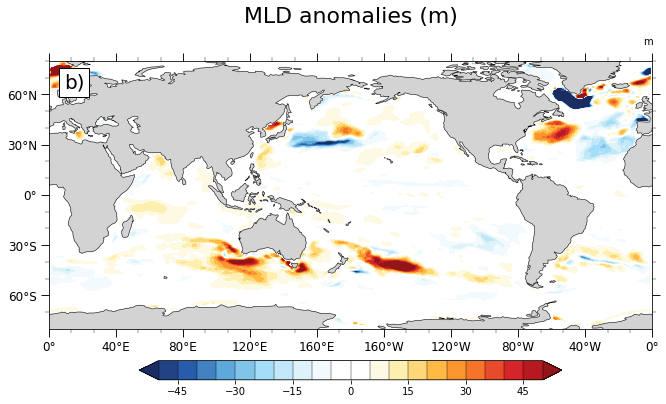

In [270]:
fig = plt.figure(figsize=(22, 15))
fig.tight_layout(pad=-2)

#---------
# plot diff

ax1 = plt.subplot(2, 2, 2, projection=ccrs.PlateCarree(central_longitude=180))
ax1.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)
levels2 = np.arange(-9.,10.,0.5)
contour1 = season_diff.plot.contourf(ax=ax1,
                           transform=ccrs.PlateCarree(),
                           extend='both',
                           cmap = gvcmaps.BlueWhiteOrangeRed,
                           levels=np.arange(-50,55,5),
                           add_colorbar=False,
                           add_labels=False,
                           zorder=0)





plt.colorbar(contour1,
             ax=ax1,
#             ticks=np.linspace(-3e9, 3e9, 11),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)

gvutil.set_titles_and_labels(ax1,maintitle="MLD anomalies (m)",
                             maintitlefontsize=20,righttitle="m",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax1, xlim=(-180, 180),
                                 ylim=(-80, 80),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))


gvutil.add_major_minor_ticks(ax1, labelsize=12)
gvutil.add_lat_lon_ticklabels(ax1)




plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.1,  
                    hspace=0.05) 


ax0.text(0.025, 0.9,
            'a)', fontsize=20,
            transform=ax0.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

ax1.text(0.025, 0.9,
            'b)', fontsize=20,
            transform=ax1.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

#plt.savefig("annual_mld_anom_2panel.pdf")




In [1]:
hmxl_m_diff[2,40:140,120:180].mean('lon').plot()

NameError: name 'hmxl_m_diff' is not defined

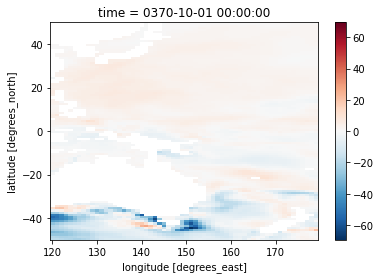

In [113]:
hmxl_m_diff[8,40:140,120:180].plot()

### - animation of tropical sst

 read in monthly climatology file

In [271]:
temp_trop = temp_m_diff.isel(z_t=slice(0,40),lon=slice(120,280), lat=slice(80,100)).mean('lat')
temp_trop0 = temp_m0.isel(z_t=slice(0,40),lon=slice(120,280), lat=slice(80,100)).mean('lat')

temp_nwp = temp_m_diff.isel(z_t=slice(0,40),lon=180, lat=slice(80,150))
temp_nwp0 = temp_m0.isel(z_t=slice(0,40),lon=180, lat=slice(80,150))

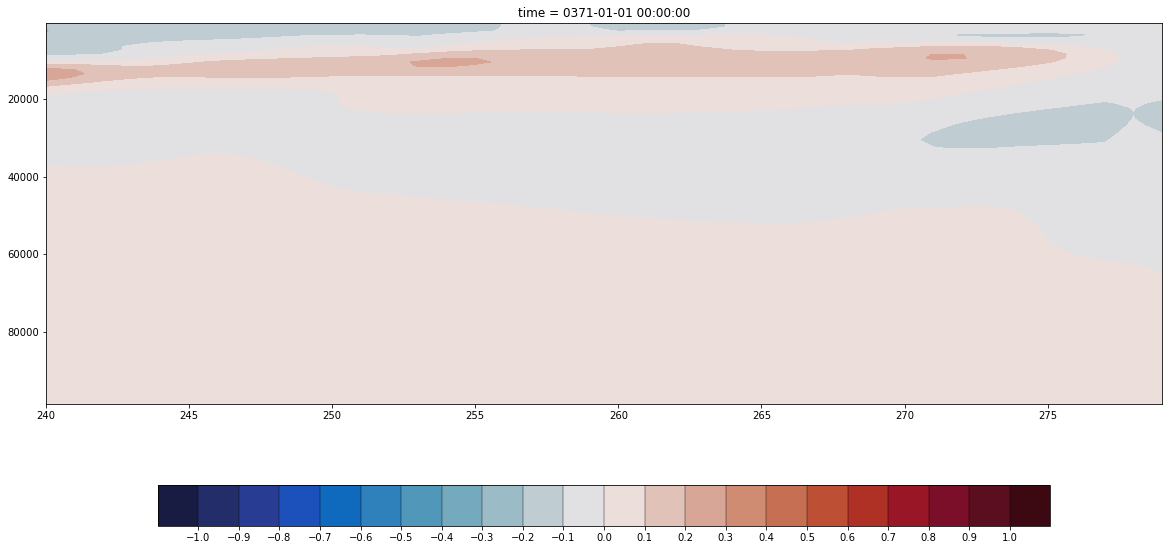

In [272]:
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(20,10))

temp_trop.isel(time=0,z_t=slice(0,40),lon=slice(120,280)).plot.contourf(ax=ax,
                            levels=np.arange(-1.,1.1, 0.1),
                            extend='both',
                           colors=cmocean.cm.balance,
                           cbar_kwargs={
                               "drawedges":True,
                               "extendrect": True,
                               "orientation": "horizontal",
                               "ticks": np.arange(-1.,1.1, 0.1),
                               "label": "",
                               "shrink": 0.80
                           })



# animate function for matplotlib FuncAnimation
def animate(i):
    temp_trop.isel(time=i,z_t=slice(0,40),lon=slice(120,280)).plot.contourf(ax=ax,
                       levels=np.arange(-1, 1.1, 0.1),
                        extend='both',
                       colors=cmocean.cm.balance,
                       add_colorbar=False)



    ax.invert_yaxis()
    
    gvutil.set_titles_and_labels(
        ax,
        xlabel="",
        ylabel="")


# runs the animation initiated with the frame from init and progressed with the animate function
anim = animation.FuncAnimation(fig, animate, frames=12, interval=200)

anim.save('animate_1.gif', writer='pillow', fps=5)



In [ ]:
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(20,10))

levels2= np.arange(-1, 1.1, 0.1)
# animate function for matplotlib FuncAnimation
def animate(i):
    temp_nwp.isel(time=i,z_t=slice(0,40)).plot.contourf(ax=ax,
                       levels=levels2,
                        extend='both',
                       colors=cmocean.cm.balance,
                       add_colorbar=False)
    
    ax.invert_yaxis()

    
    gvutil.set_titles_and_labels(
        ax,
        xlabel="",
        ylabel="")


# runs the animation initiated with the frame from init and progressed with the animate function
anim = animation.FuncAnimation(fig, animate, frames=12, interval=200)

anim.save('animate_2.gif', writer='pillow', fps=5)



In [273]:

hmxl_nh_summer0 = hmxl_m0[7:10].mean('time')
hmxl_nh_winter0 = (hmxl_m0[11] + hmxl_m0[0:3].mean('time') *4 ) / 5.
hmxl_nh_summer = hmxl_m_diff[7:10].mean('time')
hmxl_nh_winter = (hmxl_m_diff[11] + hmxl_m_diff[0:3].mean('time') *4 ) / 5.

In [274]:
temp_m_diff= temp_m.copy(data = (temp_m.data - temp_m0.data))

In [275]:
sst_nh_summer0 =temp_m0.isel(z_t=0,time=slice(6,10)).mean('time')
sst_nh_winter0 = (temp_m0.isel(z_t=0,time=11) + temp_m0.isel(z_t=0,time=slice(0,3)).mean('time') *4 ) / 5.

sst_nh_summer =temp_m_diff.isel(z_t=0,time=slice(6,10)).mean('time')
sst_nh_winter = (temp_m_diff.isel(z_t=0,time=11) + temp_m_diff.isel(z_t=0,time=slice(0,4)).mean('time') *5 ) / 6.

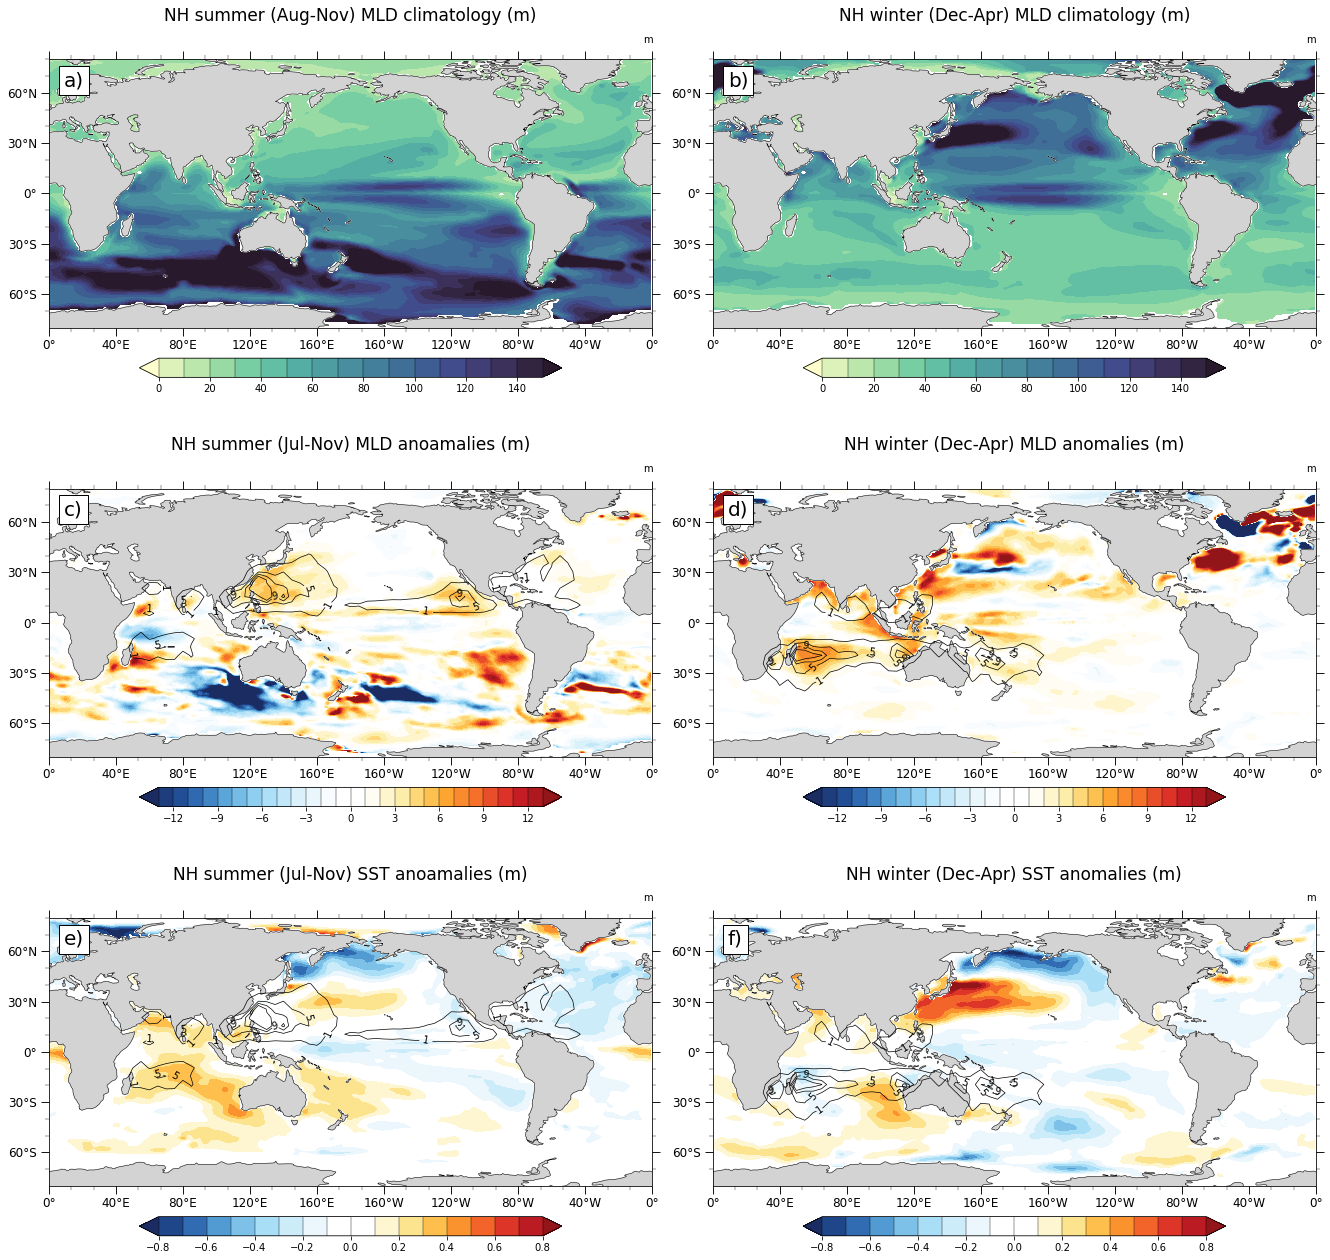

In [278]:
fig = plt.figure(figsize=(22, 22))
fig.tight_layout(pad=-2)

ax0 = plt.subplot(3, 2, 1, projection=ccrs.PlateCarree(central_longitude=180))
ax0.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax0.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)

levels = np.arange(0,160,10)
contour0 = hmxl_nh_summer0.plot.contourf(ax=ax0,
                           transform=ccrs.PlateCarree(),
                           extend='both',
                           cmap = cmocean.cm.deep,
                           levels=levels,
                           add_colorbar=False,
                           add_labels=False,
                           zorder=0)

plt.colorbar(contour0,
             ax=ax0,
#             ticks=np.linspace(-3e9, 3e9, 11),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)



gvutil.set_titles_and_labels(ax0,maintitle="NH summer (Aug-Nov) MLD climatology (m)",
                             maintitlefontsize=15,righttitle="m",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax0, xlim=(-180, 180),
                                 ylim=(-80, 80),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))

gvutil.add_major_minor_ticks(ax0, labelsize=12)
gvutil.add_lat_lon_ticklabels(ax0)


#------------


ax1 = plt.subplot(3, 2, 2, projection=ccrs.PlateCarree(central_longitude=180))
ax1.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax1.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)


contour1 = hmxl_nh_winter0.plot.contourf(ax=ax1,
                           transform=ccrs.PlateCarree(),
                           extend='both',
                           cmap = cmocean.cm.deep,
                           levels=levels,
                           add_colorbar=False,
                           add_labels=False,
                           zorder=0)

plt.colorbar(contour1,
             ax=ax1,
#             ticks=np.linspace(-3e9, 3e9, 11),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)



gvutil.set_titles_and_labels(ax1,maintitle="NH winter (Dec-Apr) MLD climatology (m)",
                             maintitlefontsize=15,righttitle="m",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax1, xlim=(-180, 180),
                                 ylim=(-80, 80),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))



gvutil.add_major_minor_ticks(ax1, labelsize=12)
gvutil.add_lat_lon_ticklabels(ax1)


#--------------


ax2 = plt.subplot(3, 2, 3, projection=ccrs.PlateCarree(central_longitude=180))
ax2.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax2.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)

levels = np.arange(-13.,14.,1)
contour2 = hmxl_nh_summer.plot.contourf(ax=ax2,
                           transform=ccrs.PlateCarree(),
                           extend='both',
                           cmap = gvcmaps.BlueWhiteOrangeRed,
                           #cmap = cmocean.cm.balance,
                           levels=levels,
                           add_colorbar=False,
                           add_labels=False,
                           zorder=0)

contourpdi = pdi_map_summer.sum('month').plot.contour(ax=ax2,
                                              transform=ccrs.PlateCarree(),
                                              levels=np.arange(1,15,4),
                                              linewidths=0.7,
                                              add_labels=False,
                                              colors = "black",
                                              extend='both')
ax2.clabel(contourpdi, [1,5,9], fmt='%d', inline=True, colors='black')
                                              

plt.colorbar(contour2,
             ax=ax2,
#             ticks=np.linspace(-3e9, 3e9, 11),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)



gvutil.set_titles_and_labels(ax2,maintitle="NH summer (Jul-Nov) MLD anoamalies (m)",
                             maintitlefontsize=15,righttitle="m",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax2, xlim=(-180, 180),
                                 ylim=(-80, 80),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))

gvutil.add_major_minor_ticks(ax2, labelsize=12)
gvutil.add_lat_lon_ticklabels(ax2)

#---- winter 

ax3 = plt.subplot(3, 2, 4, projection=ccrs.PlateCarree(central_longitude=180))
ax3.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax3.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)

contour3 = hmxl_nh_winter.plot.contourf(ax=ax3,
                           transform=ccrs.PlateCarree(),
                           extend='both',
                           cmap = gvcmaps.BlueWhiteOrangeRed,
                           levels=levels,
                           add_colorbar=False,
                           add_labels=False,
                           zorder=0)
contourpdi2 = pdi_map_winter.sum('month').plot.contour(ax=ax3,
                                              transform=ccrs.PlateCarree(),
                                              levels=np.arange(1,15,4),
                                              linewidths=0.7,
                                              add_labels=False,
                                              colors = "black",
                                              extend='both')
ax3.clabel(contourpdi2, [1,5,9], fmt='%d', inline=True, colors='black')
                                              

plt.colorbar(contour3,
             ax=ax3,
#             ticks=np.linspace(-3e9, 3e9, 11),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)



gvutil.set_titles_and_labels(ax3,maintitle="NH winter (Dec-Apr) MLD anomalies (m)",
                             maintitlefontsize=15,righttitle="m",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax3, xlim=(-180, 180),
                                 ylim=(-80, 80),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))

gvutil.add_major_minor_ticks(ax3, labelsize=12)
gvutil.add_lat_lon_ticklabels(ax3)


plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.1,  
                    hspace=0.03) 



###############################
# now sst

ax4= plt.subplot(3, 2, 5, projection=ccrs.PlateCarree(central_longitude=180))
ax4.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax4.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)

levels = np.arange(-0.8,0.9,0.1)
contour4 = sst_nh_summer.plot.contourf(ax=ax4,
                           transform=ccrs.PlateCarree(),
                           extend='both',
                                   cmap = gvcmaps.BlueWhiteOrangeRed,
                           levels=levels,
                           add_colorbar=False,
                           add_labels=False,
                           zorder=0)
contourpdi3 = pdi_map_summer.sum('month').plot.contour(ax=ax4,
                                              transform=ccrs.PlateCarree(),
                                              levels=np.arange(1,15,4),
                                              linewidths=0.7,
                                              add_labels=False,
                                              colors = "black",
                                              extend='both')
ax4.clabel(contourpdi3, [1,5,9], fmt='%d', inline=True, colors='black')
                                              

plt.colorbar(contour4,
             ax=ax4,
#             ticks=np.linspace(-3e9, 3e9, 11),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)



gvutil.set_titles_and_labels(ax4,maintitle="NH summer (Jul-Nov) SST anoamalies (m)",
                             maintitlefontsize=15,righttitle="m",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax4, xlim=(-180, 180),
                                 ylim=(-80, 80),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))

gvutil.add_major_minor_ticks(ax4, labelsize=12)
gvutil.add_lat_lon_ticklabels(ax4)

#---- winter 

ax5 = plt.subplot(3, 2, 6, projection=ccrs.PlateCarree(central_longitude=180))
ax5.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
ax5.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)

contour5 = sst_nh_winter.plot.contourf(ax=ax5,
                           transform=ccrs.PlateCarree(),
                           extend='both',
                                   cmap = gvcmaps.BlueWhiteOrangeRed,
                           levels=levels,
                           add_colorbar=False,
                           add_labels=False,
                           zorder=0)
contourpdi4 = pdi_map_winter.sum('month').plot.contour(ax=ax5,
                                              transform=ccrs.PlateCarree(),
                                              levels=np.arange(1,15,4),
                                              linewidths=0.7,
                                              add_labels=False,
                                              colors = "black",
                                              extend='both')
ax5.clabel(contourpdi4, [1,5,9], fmt='%d', inline=True, colors='black')
                                              
plt.colorbar(contour5,
             ax=ax5,
#             ticks=np.linspace(-3e9, 3e9, 11),
             orientation='horizontal',
             pad=0.075,
             drawedges=True,
             shrink=0.7)



gvutil.set_titles_and_labels(ax5,maintitle="NH winter (Dec-Apr) SST anomalies (m)",
                             maintitlefontsize=15,righttitle="m",righttitlefontsize=10)
gvutil.set_axes_limits_and_ticks(ax5, xlim=(-180, 180),
                                 ylim=(-80, 80),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))

gvutil.add_major_minor_ticks(ax5, labelsize=12)
gvutil.add_lat_lon_ticklabels(ax5)


plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.1,  
                    hspace=0.05) 


ax0.text(0.025, 0.9,
            'a)', fontsize=20,
            transform=ax0.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

ax1.text(0.025, 0.9,
            'b)', fontsize=20,
            transform=ax1.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

ax2.text(0.025, 0.9,
            'c)', fontsize=20,
            transform=ax2.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))
ax3.text(0.025, 0.9,
            'd)', fontsize=20,
            transform=ax3.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

ax4.text(0.025, 0.9,
            'e)', fontsize=20,
            transform=ax4.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

ax5.text(0.025, 0.9,
            'f)', fontsize=20,
            transform=ax5.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))
plt.savefig("sst_season_anom_4panel.pdf")

## 11. AMOC diagnostics

In [12]:
ds_moc = xr.open_dataset("./data/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010.pop.h.ann.moc.0370-0399.nc")
moc0 = ds_moc.MOC
heat0 = ds_moc.N_HEAT
heat0

<xarray.DataArray 'N_HEAT' (time: 30, transport_reg: 2, transport_comp: 5, lat_aux_grid: 395)>
[118500 values with dtype=float32]
Coordinates:
    transport_components  (transport_comp) |S256 ...
    transport_regions     (transport_reg) |S256 ...
  * time                  (time) object 0370-02-01 00:00:00 ... 0399-02-01 00...
  * lat_aux_grid          (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
Dimensions without coordinates: transport_reg, transport_comp
Attributes:
    long_name:     Northward Heat Transport
    units:         Pwatt
    cell_methods:  time: mean

In [13]:
mocz_in_m = change_units(ds_moc, "moc_z", "moc_z", "m")

In [14]:
ds_moc_e = xr.open_dataset("./data/b.e13.B1850C5CN.ne30_g16.005ax_exact.pop.h.ann.moc.0301-0320.nc")
moce = ds_moc_e.MOC
heate = ds_moc_e.N_HEAT

In [15]:
ds_moc_hires = xr.open_dataset("./data/b.e13.B1850C5CN.ne120_g16.tuning.005ax.pop.h.N_HEAT.010102-015012.nc")
heat_raw = ds_moc_hires.N_HEAT
heat_hires = heat_raw.groupby(heat_raw.time.dt.year).mean()

In [16]:
ds_moc_tc = xr.open_dataset('./data/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily.pop.h.ann.moc.0330-0473.nc')
moctc = ds_moc_tc.MOC
heattc = ds_moc_tc.N_HEAT
heattc

<xarray.DataArray 'N_HEAT' (time: 144, transport_reg: 2, transport_comp: 5, lat_aux_grid: 395)>
[568800 values with dtype=float32]
Coordinates:
    transport_components  (transport_comp) |S256 ...
    transport_regions     (transport_reg) |S256 ...
  * time                  (time) object 0330-02-01 00:00:00 ... 0473-02-01 00...
  * lat_aux_grid          (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
Dimensions without coordinates: transport_reg, transport_comp
Attributes:
    long_name:     Northward Heat Transport
    units:         Pwatt
    cell_methods:  time: mean

In [17]:
ds_moc_tc1 = xr.open_dataset('./data/b.e13.B1850C5CN.ne30_g16.005ax_exact_tc.pop.h.ann.moc.0301-0330.nc')
moctc1 = ds_moc_tc1.MOC


In [18]:
moc_new=xr.concat([moctc1,moctc],dim="time")
moc_new.isel(moc_comp=0)

<xarray.DataArray 'MOC' (time: 174, transport_reg: 2, moc_z: 61, lat_aux_grid: 395)>
array([[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           2.6008545e-05,  6.6926564e-06, -1.0367975e-06],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           1.6295278e-03,  4.7084593e-04,  1.4793012e-05],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           3.3532390e-03,  9.8003715e-04,  2.9805988e-05],
         ...,
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          -8.8764540e-07, -8.8764540e-07, -8.8764540e-07],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          -5.6731250e-07, -5.6731250e-07, -5.6731250e-07],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

        [[ 8.9128572e-01,  8.9128572e-01,  8.9128572e-01, ...,
           8.3446753e-01,  8.3444822e-01,  8.3444053e-01],
         [ 1.8201240e+00,  1.8201240e+00,  1.8201240e+00, ...,
           5.8209950e-01,  5.8094084e-01,  5.8048481e-01],
         [ 2.6705871e+00,  2.6705871e+00,  2.6705871e+00, ...,
           3.0199635e-01,  2.9962301e-01,  2.9867277e-01],
...
           1.6423622e-06,  1.6423622e-06,  1.6423622e-06],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          -1.5501762e-07, -1.5501762e-07, -1.5501762e-07],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

        [[ 9.5405388e-01,  9.5405388e-01,  9.5405388e-01, ...,
           9.6221828e-01,  9.6222657e-01,  9.6223068e-01],
         [ 1.9955176e+00,  1.9955176e+00,  1.9955176e+00, ...,
           6.6771305e-01,  6.6668063e-01,  6.6627926e-01],
         [ 2.9628119e+00,  2.9628119e+00,  2.9628119e+00, ...,
           3.4449658e-01,  3.4197858e-01,  3.4087881e-01],
         ...,
         [ 3.4477614e-02,  3.4477614e-02,  3.4477614e-02, ...,
          -2.3744468e-08, -2.3744468e-08, -2.3744468e-08],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           3.3319431e-08,  3.3319431e-08,  3.3319431e-08],
         [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]]],
      dtype=float32)
Coordinates:
    transport_regions  (transport_reg) |S256 b'Global Ocean - Marginal Seas' ...
  * time               (time) object 0301-02-01 00:00:00 ... 0473-02-01 00:00:00
  * lat_aux_grid       (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
  * moc_z              (moc_z) float32 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05
Dimensions without coordinates: transport_reg
Attributes:
    long_name:     Meridional Overturning Circulation
    units:         Sverdrups
    coordinates:   lat_aux_grid moc_z moc_components transport_region time
    cell_methods:  time: mean

Find MOC value

In [19]:
moc0_series = moc0[:,:,0,33:59,50:395].max(dim=("moc_z","lat_aux_grid"))
moc0_series[:,0].mean('time')

<xarray.DataArray 'MOC' ()>
array(36.268726, dtype=float32)
Coordinates:
    transport_regions  |S256 b'Global Ocean - Marginal Seas'

In [20]:
moce_series = moce[:,:,0,33:59,50:395].max(dim=("moc_z","lat_aux_grid"))
moce_series[:,:].mean('time')

<xarray.DataArray 'MOC' (transport_reg: 2)>
array([35.887794, 23.278515], dtype=float32)
Coordinates:
    transport_regions  (transport_reg) |S256 ...
Dimensions without coordinates: transport_reg

In [194]:
moce.lat_aux_grid[50:395]

<xarray.DataArray 'lat_aux_grid' (lat_aux_grid: 345)>
array([-52.775135, -52.240894, -51.706654, ...,  88.948814,  89.47441 ,
        90.      ], dtype=float32)
Coordinates:
  * lat_aux_grid  (lat_aux_grid) float32 -52.78 -52.24 -51.71 ... 89.47 90.0
Attributes:
    long_name:  latitude grid for transport diagnostics
    units:      degrees_north
    valid_min:  -79.48815
    valid_max:  90.0

In [21]:
moctc_series = moc_new[:,:,0,33:59,50:395].max(dim=("moc_z","lat_aux_grid"))

In [22]:
moc_anom = moctc_series.copy(data=(moctc_series-moce_series.mean('time')))

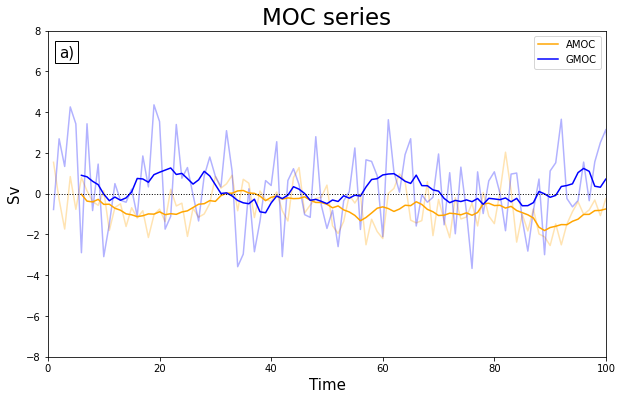

In [212]:
fig, ax0 = plt.subplots(figsize=(10,6))

ax0.plot(np.arange(1,175,step=1), moc_anom[:,1],color="orange",alpha=0.3 )
ax0.plot(np.arange(1,175,step=1), moc_anom[:,0],color="blue", alpha=.3 )

ax0.plot(np.arange(1,175,step=1), moc_anom[:,1].rolling(time=10,center=True).mean(),color="orange", label="AMOC" )
ax0.plot(np.arange(1,175,step=1), moc_anom[:,0].rolling(time=10,center=True).mean(),color="blue", label="GMOC" )

ax0.plot(np.arange(0,175,step=1), np.zeros(175),color="black", lw=1,linestyle=':', )
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles, labels)

gvutil.set_axes_limits_and_ticks(ax0,ylim=(-8., 8.),xlim=(0,100))
ax0.set_title("MOC series",fontsize=23)


ax0.set_ylabel('Sv',fontsize=15)
ax0.set_xlabel('Time', fontsize=15)

ax0.text(0.02, 0.92,
            'a)', fontsize=15,
            transform=ax0.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

plt.savefig("moc_series.pdf")

In [205]:
moc_anom[:,1].rolling(time=10,center=True).mean().isel(time=slice(70,100)).mean()

<xarray.DataArray 'MOC' ()>
array(-1.037304, dtype=float32)
Coordinates:
    transport_regions  |S256 b'Atlantic Ocean + Mediterranean Sea + Labrador ...

In [206]:
-1.03/23

-0.044782608695652176

In [27]:
moc_diff = moc_new.copy(data=moc_new.data - moc0.mean('time').data)
depth=40
plt_moc = moce[:,0,0,0:depth,20:380].mean('time').transpose('moc_z','lat_aux_grid')
plt_moc_tc = moc_new[:,0,0,0:depth,20:380].mean('time').transpose('moc_z','lat_aux_grid')
plt_moc_diff = moc_diff[70:100,0,0,0:depth,20:380].mean('time').transpose('moc_z','lat_aux_grid')

plt_amoc = moce[:,1,0,0:depth,20:380].mean('time').transpose('moc_z','lat_aux_grid')
plt_amoc_tc = moc_new[:,1,0,0:depth,20:380].mean('time').transpose('moc_z','lat_aux_grid')
plt_amoc_diff = moc_diff[70:100,1,0,0:depth,20:380].mean('time').transpose('moc_z','lat_aux_grid')


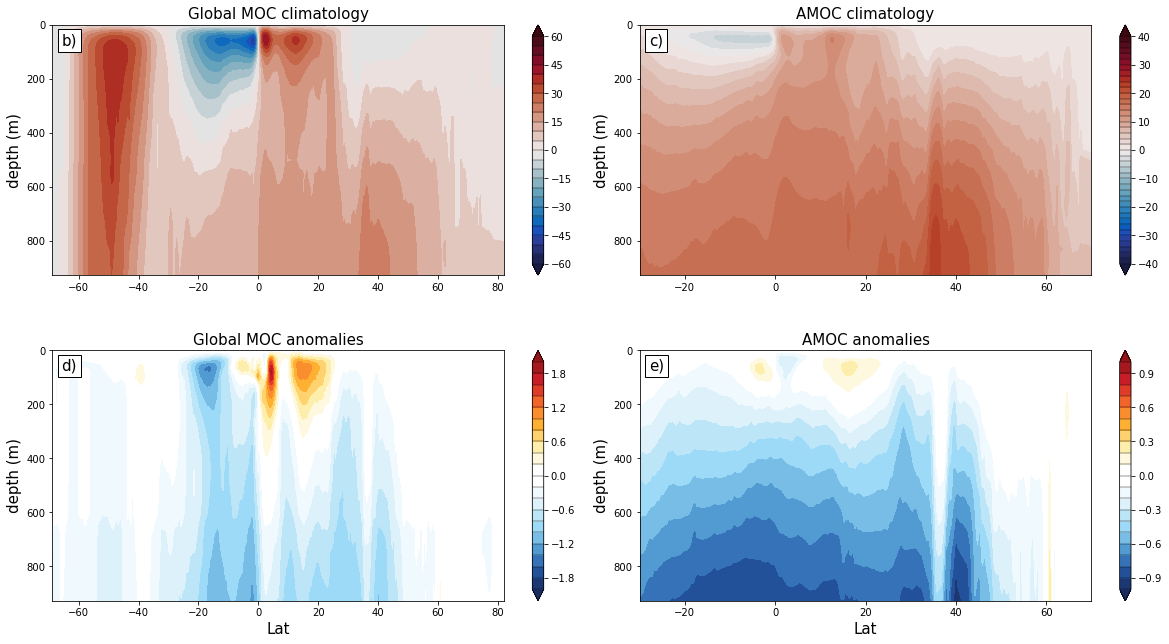

In [28]:
import cmocean
fig5, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2,figsize=(20, 10))   # now you can reference the first object
cs0 = ax0.contourf(plt_moc.lat_aux_grid,mocz_in_m.isel(moc_z=slice(0,depth)), plt_moc, levels=np.arange(-60,65,5),cmap=cmocean.cm.balance, extend='both')
cs1 = ax1.contourf(plt_amoc.lat_aux_grid,mocz_in_m.isel(moc_z=slice(0,depth)), plt_amoc, levels=np.arange(-40,42,2),cmap=cmocean.cm.balance, extend='both')

cs2 = ax2.contourf(plt_moc_diff.lat_aux_grid,mocz_in_m.isel(moc_z=slice(0,depth)), plt_moc_diff,levels=np.arange(-2,2.2,0.2),cmap=gvcmaps.BlueWhiteOrangeRed, extend='both')
cs3 = ax3.contourf(plt_amoc_diff.lat_aux_grid,mocz_in_m.isel(moc_z=slice(0,depth)), plt_amoc_diff,levels=np.arange(-1,1.1,0.1),cmap=gvcmaps.BlueWhiteOrangeRed,extend='both')

ax0.invert_yaxis()
ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_yaxis()

ax0.set_title('Global MOC climatology', fontsize=15)
ax2.set_title('Global MOC anomalies', fontsize=15)

ax1.set_title('AMOC climatology', fontsize=15)
ax3.set_title('AMOC anomalies', fontsize=15)

ax0.set_ylabel('depth (m)',fontsize=15)
ax1.set_ylabel('depth (m)',fontsize=15)
ax2.set_xlabel('Lat', fontsize=15)


ax2.set_ylabel('depth (m)',fontsize=15)
ax3.set_ylabel('depth (m)',fontsize=15)
ax3.set_xlabel('Lat', fontsize=15)

gvutil.set_axes_limits_and_ticks(ax1,xlim=(-30., 70.))
gvutil.set_axes_limits_and_ticks(ax3,xlim=(-30., 70.))



fig5.colorbar(cs0, ax=ax0, drawedges=True)
fig5.colorbar(cs1, ax=ax1, drawedges=True)
fig5.colorbar(cs2, ax=ax2, drawedges=True)
fig5.colorbar(cs3, ax=ax3, drawedges=True)


plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.04,  
                    hspace=0.3) 


ax0.text(0.02, 0.92,
            'b)', fontsize=15,
            transform=ax0.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

ax1.text(0.02, 0.92,
            'c)', fontsize=15,
            transform=ax1.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))

ax2.text(0.02, 0.92,
            'd)', fontsize=15,
            transform=ax2.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))
ax3.text(0.02, 0.92,
            'e)', fontsize=15,
            transform=ax3.transAxes,
            bbox=dict(boxstyle='square, pad=0.25', facecolor='white'))


plt.savefig('moc_4panels_upper.pdf')

### - vertical velocity anomalies

In [29]:
dsv0 = xr.open_dataset('./data/b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010.pop.h.annmean.vel.0331-0400.1x1.nc')
wvel0 = dsv0.WVEL

In [30]:
dsv = xr.open_dataset('./data/b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily.pop.h.annmean.vel.0371-0400.1x1.nc')
wvel = dsv.WVEL

In [31]:
wvel_diff = wvel.copy(data=wvel.data-wvel0.data)
wvel_diff

<xarray.DataArray 'WVEL' (time: 1, z_w_top: 60, lat: 180, lon: 360)>
array([[[[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         ...,
         [ 1.1336249e-09,  1.1475022e-09,  1.1614046e-09, ...,
           1.0974263e-09,  1.1082476e-09,  1.1197732e-09],
         [ 9.8788977e-10,  9.9327568e-10,  9.9835784e-10, ...,
           9.6988573e-10,  9.7619712e-10,  9.8219766e-10],
         [ 7.7725004e-10,  7.8320683e-10,  7.8892382e-10, ...,
           7.5791196e-10,  7.6460527e-10,  7.7105056e-10]],

        [[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
...
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan]],

        [[           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         ...,
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan],
         [           nan,            nan,            nan, ...,
                     nan,            nan,            nan]]]],
      dtype=float32)
Coordinates:
  * time     (time) object 0385-08-02 12:00:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * z_w_top  (z_w_top) float32 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
Attributes:
    long_name:     Vertical Velocity
    units:         centimeter/s
    grid_loc:      3112
    cell_methods:  time: mean

In [32]:
wz_in_m =change_units(dsv0, "z_w_top", "z_w_top", "m")

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: The following kwargs were not used by contour: 'add_labels'
  # Remove the CWD from sys.path while we load stuff.


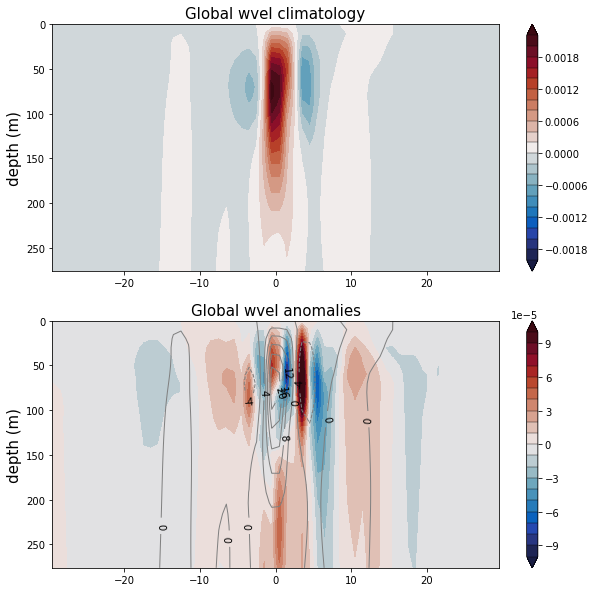

In [46]:
import cmocean
plt_wvel = wvel0[0,0:26,:,200:240].mean('lon')
plt_wvel_diff = wvel_diff[0,0:26,:,200:240].mean('lon')

fig, (ax0, ax1) = plt.subplots(2, 1,figsize=(10, 10))   # now you can reference the first object

cs0 = ax0.contourf(plt_wvel.lat[60:120],wz_in_m.isel(z_w_top=slice(0,26)),plt_wvel[:,60:120], levels=np.arange(-0.002, 0.0022, 0.0002), cmap=cmocean.cm.balance, extend='both')
cs1 = ax1.contourf(plt_wvel_diff.lat[60:120],wz_in_m.isel(z_w_top=slice(0,26)),plt_wvel_diff[:,60:120], levels=np.arange(-0.0001, 0.00011, 0.00001), cmap=cmocean.cm.balance, extend='both')

plt1 = ax1.contour(plt_wvel.lat[60:120],wz_in_m.isel(z_w_top=slice(0,26)),1e4*plt_wvel[:,60:120], levels=np.arange(-20, 24, 4),colors='gray',linewidths=1.0,add_labels=False)


                     
ax1.clabel(plt1, np.arange(-20,24,4), fmt='%d', inline=True, colors='black')

ax0.invert_yaxis()
ax1.invert_yaxis()


ax0.set_title('Global wvel climatology', fontsize=15)
ax1.set_title('Global wvel anomalies', fontsize=15)


ax0.set_ylabel('depth (m)',fontsize=15)
ax1.set_ylabel('depth (m)',fontsize=15)


fig.colorbar(cs0, ax=ax0, drawedges=True)
fig.colorbar(cs1,ax=ax1, drawedges=True)
plt.savefig("wvel_clim_anom.pdf")

## 12. MHT

In [100]:
heattc

<xarray.DataArray 'N_HEAT' (time: 144, transport_reg: 2, transport_comp: 5, lat_aux_grid: 395)>
[568800 values with dtype=float32]
Coordinates:
    transport_components  (transport_comp) |S256 b'Total' ... b'Submeso Advec...
    transport_regions     (transport_reg) |S256 b'Global Ocean - Marginal Sea...
  * time                  (time) object 0330-02-01 00:00:00 ... 0473-02-01 00...
  * lat_aux_grid          (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
Dimensions without coordinates: transport_reg, transport_comp
Attributes:
    long_name:     Northward Heat Transport
    units:         Pwatt
    cell_methods:  time: mean

In [104]:
heattc_series = heattc[70:100, 0, 0, :]
heattc_std = heattc_series.std(dim='time')
conf_lower = heattc_series.mean('time') - heattc_std
conf_upper = heattc_series.mean('time') + heattc_std

In [102]:
heat0_series = heat0[:, 0, 0, :]
heat0_std = heat0_series.std(dim='time')
conf_lower0 = heat0_series.mean('time') - heat0_std
conf_upper0 = heat0_series.mean('time') + heat0_std

In [47]:
heate_series = heat_hires[0:30,0,0,:]
heate_std = heate_series.std(dim='year')
conf_lowere = heate_series.mean('year') - heate_std
conf_uppere = heate_series.mean('year') + heate_std

In [108]:
heat_diff_series = heattc_series.copy(data=heattc_series.data - heat0_series.mean('time').data)
#heat_diff_std = heat_diff_series.std(dim='time')
#conf_lower_diff = heat_diff_series.mean('time') - heat_diff_std
#conf_upper_diff = heat_diff_series.mean('time') + heat_diff_std


In [52]:
heat_hilow_diff = heate_series.mean('year').copy(data=heate_series.mean('year').data - heat0_series.mean('time').data)



In [92]:
def make_axes(plot_size):
    fig, ax1 = plt.subplots(figsize=plot_size)
    ax2 = ax1.twinx()

    # Use geocat.viz.util convenience function to add minor and major tick lines
    gvutil.add_major_minor_ticks(ax1, y_minor_per_major=5, labelsize=14)
    gvutil.add_major_minor_ticks(ax2, y_minor_per_major=5, labelsize=14)


    # Use geocat.viz.util convenience function to set axes tick values
    gvutil.set_axes_limits_and_ticks(ax1, ylim=(-1.9, 1.9), xlim = (-72,72))
    gvutil.set_axes_limits_and_ticks(ax2, ylim=(-0.06, 0.06))


    # Adjust which sides of the plot the tick marks are drawn for each axes
    ax1.tick_params('both', which='both', right=False)
    ax2.tick_params('both', which='both', bottom=False, top=False, left=False)
    return ax1, ax2

In [16]:
heat0_series

<xarray.DataArray 'N_HEAT' (time: 30, transport_reg: 2, lat_aux_grid: 395)>
array([[[         nan,          nan, ..., 4.460871e-05, 5.356488e-07],
        [         nan,          nan, ...,          nan,          nan]],

       [[         nan,          nan, ..., 5.644779e-05, 4.533083e-07],
        [         nan,          nan, ...,          nan,          nan]],

       ...,

       [[         nan,          nan, ..., 3.840793e-06, 4.723320e-06],
        [         nan,          nan, ...,          nan,          nan]],

       [[         nan,          nan, ..., 1.079115e-05, 1.643756e-06],
        [         nan,          nan, ...,          nan,          nan]]],
      dtype=float32)
Coordinates:
    transport_components  |S256 b'Total'
    transport_regions     (transport_reg) |S256 b'Global Ocean - Marginal Sea...
  * time                  (time) object 0370-02-01 00:00:00 ... 0399-02-01 00...
  * lat_aux_grid          (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
Dimensions without coordinates: transport_reg
Attributes:
    long_name:     Northward Heat Transport
    units:         Pwatt
    cell_methods:  time: mean

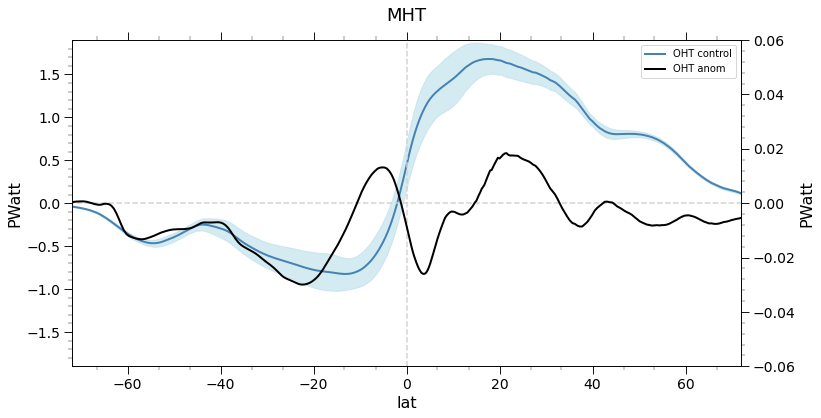

In [109]:
ax1, ax2 = make_axes((12, 6))
x = heattc.lat_aux_grid
cs1 = ax1.plot(x,heat0_series.mean('time'),color='steelblue',linewidth = 2.0,label='OHT control')
ax1.plot(x,np.zeros(np.size(x)), color= "lightgrey", linestyle='--')
plt.vlines(0, -1.9, 1.9, linestyle='--', color='lightgrey')
ax1.fill_between(x, conf_lower0, conf_upper0, color='lightblue', alpha=0.5, zorder=0)


#cs2 = ax1.plot(x, heattc_series.mean('time'), color = "salmon",  linewidth=2., label='OHT TC')
#ax1.fill_between(x, conf_lower, conf_upper, color='lightpink', alpha=0.5,zorder=0)

cs2 = ax2.plot(x, heat_diff_series.mean('time'), color = "black",  linewidth=2., label='OHT anom')
#ax1.fill_between(x, conf_lower_diff, conf_upper_diff, color='lightpink', zorder=0)


#------
#cs3 = ax1.plot(x,heate_series.mean('year'),color='purple',label='OHT hires control')
#plt.vlines(0, -1.9, 1.9, linestyle='--', color='lightgrey')

#cs4 = ax1.plot(x, heat_hilow_diff, color = "red",  linewidth=2., label='OHT anom')




handles, labels = ax1.get_legend_handles_labels()
#handles2, labels2 = ax2.get_legend_handles_labels()

cs = cs1+cs2
labs = [l.get_label() for l in cs]
ax1.legend(cs, labs, loc=0)

gvutil.set_titles_and_labels(ax1, ylabel='PWatt', xlabel='lat',maintitle="MHT")
gvutil.set_titles_and_labels(ax2, ylabel='PWatt')
#plt.savefig("OHT_compare.pdf")

In [16]:
heat0_series

NameError: name 'heat0_series' is not defined

In [46]:
labels

['OHT control']

In [21]:
heat0_clm=heat0[:,0,0,:].mean('time')

/glade/work/huili7/miniconda3/envs/geocat_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [22]:
heattc_clm = heattc[70:100,0,0,:].mean('time')

In [23]:
heat_diff = heat0_clm.copy(data=heattc_clm.data-heat0_clm.data)

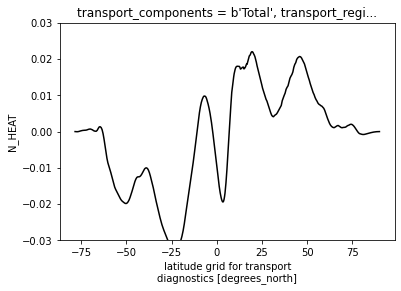

In [38]:
heat_diff.plot(ylim=(-0.03, 0.03),ls='-',color='black')

## get Atlantic and Pacific component

### we calculated the atlantic MHT offline, because it's not in the model output

In [42]:
del dnh0

In [48]:
dnh0 = xr.open_dataset("./b.e13.B1850C5CN.ne30_g16.sehires24_CNTL.010.pop.h.annmean.nheat_at.0301-0400.nc")
dnh0

<xarray.Dataset>
Dimensions:       (lat_aux_grid: 395, ncl1: 395)
Coordinates:
  * lat_aux_grid  (lat_aux_grid) float32 -79.49 -78.95 -78.42 ... 89.47 90.0
Dimensions without coordinates: ncl1
Data variables:
    N_HEAT        (lat_aux_grid) float32 ...
    N_HEAT_AT     (ncl1) float32 ...

In [49]:
nheat0_global = dnh0.N_HEAT
nheat0_at = dnh0.N_HEAT_AT
nheat0_at

<xarray.DataArray 'N_HEAT_AT' (ncl1: 395)>
array([ 0.      ,  0.      ,  0.      , ..., -0.390165, -0.390248, -0.390281],
      dtype=float32)
Dimensions without coordinates: ncl1

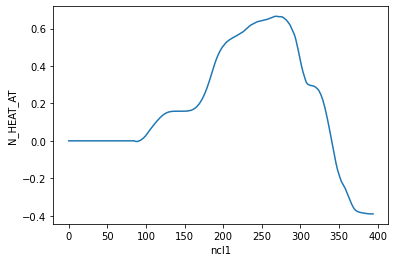

In [46]:
nheat0_at.plot()

now read in tc run

In [57]:
dnh = xr.open_dataset("b.e13.B1850C5CN.ne30_g16.005ax_exact_tcdaily.pop.h.annmean.nheat.0401-0430.nc")
nheat_at = dnh.N_HEAT_AT
nheat_global = dnh.N_HEAT

In [61]:
# get pacific for control
nheat0_pac = nheat0_global.copy(data= nheat0_global.data - nheat0_at.data)

In [62]:
# get pacific for tc run
nheat_pac = nheat_global.copy(data=nheat_global.data - nheat_at.data)
nheat_pac

<xarray.DataArray 'N_HEAT' (lat_aux_grid: 395)>
array([           nan,            nan,  0.0000000e+00, -2.0740335e-04,
       -3.2242613e-03, -6.1051780e-03, -8.7639634e-03, -1.1595721e-02,
       -1.4962446e-02, -1.8456403e-02, -2.2099795e-02, -2.5597416e-02,
       -2.9239651e-02, -3.3256732e-02, -3.7615757e-02, -4.1919298e-02,
       -4.6491709e-02, -5.1309403e-02, -5.6730140e-02, -6.2860727e-02,
       -6.9778606e-02, -7.8033701e-02, -8.7285571e-02, -9.8085165e-02,
       -1.0965582e-01, -1.2352525e-01, -1.3955748e-01, -1.5713133e-01,
       -1.7638116e-01, -1.9638684e-01, -2.1758316e-01, -2.4014901e-01,
       -2.6373130e-01, -2.8793070e-01, -3.1250599e-01, -3.3609906e-01,
       -3.5852441e-01, -3.7903845e-01, -3.9727619e-01, -4.1392967e-01,
       -4.2882273e-01, -4.4170198e-01, -4.5317519e-01, -4.6277684e-01,
       -4.7041520e-01, -4.7649458e-01, -4.7980666e-01, -4.8025200e-01,
       -4.7829485e-01, -4.7314593e-01, -4.6540621e-01, -4.5567912e-01,
       -4.4401368e-01, -4.3283904e-01, -4.2120636e-01, -4.0834785e-01,
       -3.9478618e-01, -3.8014758e-01, -3.6459216e-01, -3.4911618e-01,
       -3.3337662e-01, -3.1736833e-01, -3.0219328e-01, -2.8732014e-01,
       -2.7478054e-01, -2.6484042e-01, -2.5832659e-01, -2.5666222e-01,
       -2.5913584e-01, -2.6348069e-01, -2.7019182e-01, -2.7720252e-01,
       -2.8414541e-01, -2.9276067e-01, -3.0111706e-01, -3.1121328e-01,
       -3.2347479e-01, -3.3826318e-01, -3.5668120e-01, -3.7902749e-01,
...
        5.1077509e-01,  5.1032716e-01,  5.0941050e-01,  5.0805879e-01,
        5.0689358e-01,  5.0436342e-01,  5.0125182e-01,  4.9782765e-01,
        4.9383903e-01,  4.8974249e-01,  4.8570156e-01,  4.8029894e-01,
        4.7452909e-01,  4.6821809e-01,  4.6128070e-01,  4.5464832e-01,
        4.4734457e-01,  4.3910640e-01,  4.3029630e-01,  4.2120445e-01,
        4.1127172e-01,  4.0137935e-01,  3.9301935e-01,  3.8683018e-01,
        3.8324329e-01,  3.7983909e-01,  3.7750912e-01,  3.7676066e-01,
        3.7636873e-01,  3.7600783e-01,  3.7573358e-01,  3.7550688e-01,
        3.7540266e-01,  3.7533471e-01,  3.7518549e-01,  3.7518537e-01,
        3.7518537e-01,  3.7518543e-01,  3.7518540e-01,  3.7518543e-01,
        3.7518537e-01,  3.7518525e-01,  3.7518525e-01,  3.7518531e-01,
        3.7518528e-01,  3.7518531e-01,  3.7518537e-01,  3.7518525e-01,
        3.7518534e-01,  3.7518516e-01,  3.7518516e-01,  3.7518504e-01,
        3.7518519e-01,  3.7518510e-01,  3.7518513e-01,  3.7518543e-01,
        3.7518534e-01,  3.7518525e-01,  3.7518558e-01,  3.7518585e-01,
        3.7518588e-01,  3.7518573e-01,  3.7518603e-01,  3.7518591e-01,
        3.7518594e-01,  3.7518600e-01,  3.7518597e-01,  3.7518606e-01,
        3.7518603e-01,  3.7518606e-01,  3.7518597e-01,  3.7518570e-01,
        3.7518570e-01,  3.7518579e-01,  3.7518570e-01,  3.7518570e-01,
        3.7518573e-01,  3.7518570e-01,  3.7518564e-01], dtype=float32)
Coordinates:
  * lat_aux_grid  (lat_aux_grid) float32 -79.49 -78.95 -78.42 ... 89.47 90.0
Attributes:
    time:          146031.0
    long_name:     Northward Heat Transport
    units:         Pwatt
    coordinates:   lat_aux_grid transport_components transport_regions time
    cell_methods:  time: mean

In [79]:
nheat_at_diff = nheat_global.copy(data=(nheat_at.data - nheat0_at.data))
nheat_pac_diff = nheat_global.copy(data = (nheat_pac.data - nheat0_pac.data))

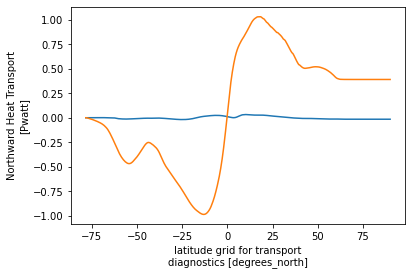

In [86]:
nheat_pac_diff.plot()
nheat0_pac.plot()

In [84]:
nheat_diff = nheat_global.copy(data = nheat_global.data - nheat0_global.data)

In [90]:
nheat0_at['ncl1'] = nheat_global.lat_aux_grid.data

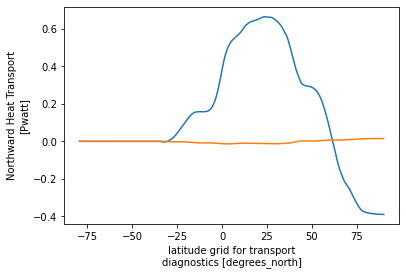

In [91]:
nheat0_at.plot()
nheat_at_diff.plot()

In [117]:
at_conf_lower = nheat0_at.copy(data = nheat0_at.data - heat0_std.data)
at_conf_upper = nheat0_at.copy(data = nheat0_at.data + heat0_std.data)

In [119]:
pac_conf_lower = nheat0_pac.copy(data = nheat0_pac.data - heat0_std.data)
pac_conf_upper = nheat0_pac.copy(data=nheat0_pac.data +heat0_std.data)

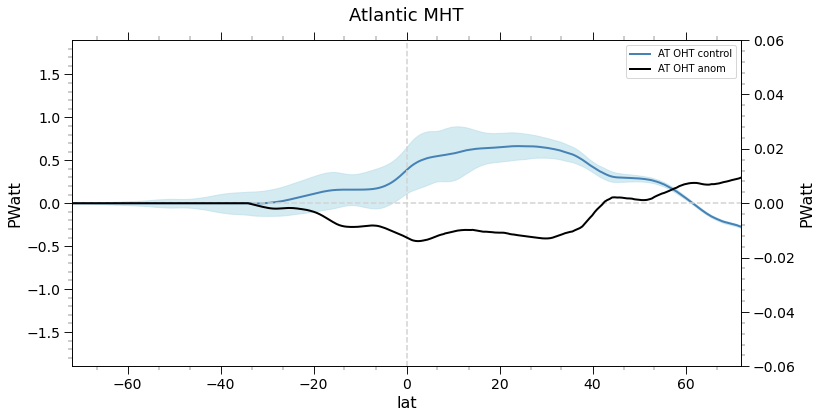

In [125]:

ax1, ax2 = make_axes((12, 6))
x = heattc.lat_aux_grid
cs1 = ax1.plot(x,nheat0_at,color='steelblue',linewidth = 2.0,label='AT OHT control')
ax1.plot(x,np.zeros(np.size(x)), color= "lightgrey", linestyle='--')
plt.vlines(0, -1.9, 1.9, linestyle='--', color='lightgrey')
ax1.fill_between(x, at_conf_lower, at_conf_upper, color='lightblue', alpha=0.5, zorder=0)


#cs2 = ax1.plot(x, heattc_series.mean('time'), color = "salmon",  linewidth=2., label='OHT TC')
#ax1.fill_between(x, conf_lower, conf_upper, color='lightpink', alpha=0.5,zorder=0)

cs2 = ax2.plot(x, nheat_at_diff, color = "black",  linewidth=2., label='AT OHT anom')


handles, labels = ax1.get_legend_handles_labels()

cs = cs1+cs2
labs = [l.get_label() for l in cs]
ax1.legend(cs, labs, loc=0)

gvutil.set_titles_and_labels(ax1, ylabel='PWatt', xlabel='lat',maintitle="Atlantic MHT")
gvutil.set_titles_and_labels(ax2, ylabel='PWatt')
plt.savefig("OHT_compare_at.pdf")

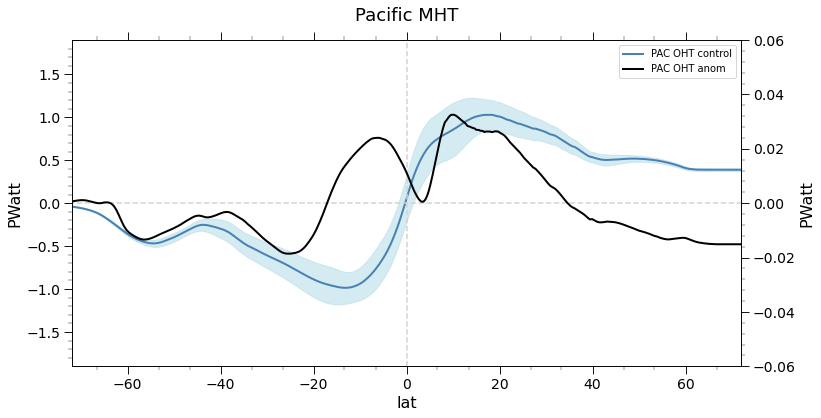

In [124]:

ax1, ax2 = make_axes((12, 6))
x = heattc.lat_aux_grid
cs1 = ax1.plot(x,nheat0_pac,color='steelblue',linewidth = 2.0,label='PAC OHT control')
ax1.plot(x,np.zeros(np.size(x)), color= "lightgrey", linestyle='--')
plt.vlines(0, -1.9, 1.9, linestyle='--', color='lightgrey')
ax1.fill_between(x, pac_conf_lower, pac_conf_upper, color='lightblue', alpha=0.5, zorder=0)


#cs2 = ax1.plot(x, heattc_series.mean('time'), color = "salmon",  linewidth=2., label='OHT TC')
#ax1.fill_between(x, conf_lower, conf_upper, color='lightpink', alpha=0.5,zorder=0)

cs2 = ax2.plot(x, nheat_pac_diff, color = "black",  linewidth=2., label='PAC OHT anom')


handles, labels = ax1.get_legend_handles_labels()

cs = cs1+cs2
labs = [l.get_label() for l in cs]
ax1.legend(cs, labs, loc=0)

gvutil.set_titles_and_labels(ax1, ylabel='PWatt', xlabel='lat',maintitle="Pacific MHT")
gvutil.set_titles_and_labels(ax2, ylabel='PWatt')
plt.savefig("OHT_compare_pac.pdf")